# Imports

In [1]:
import pandas as pd
import sklearn.metrics as metrics
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, date, timedelta
import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
from time import sleep
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Reshape, TimeDistributed, LSTM, Lambda, Bidirectional, RepeatVector, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ProgbarLogger, History
import tensorflow as tf
import keras.backend as K
from IPython.display import display
from tensorflow.keras.metrics import get as metric_get
import re
import talos
from copy import deepcopy, copy
import time
import util
import functools 
import itertools
import networkx as nx
from typing import List, Iterator, Tuple, Dict, Union
import json
import inspect
import os

# Set up GPU:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)

# Load data
load hospitalisations and trends

In [2]:
# topics considered
list_topics = {
    'Fièvre': '/m/0cjf0',
    'Mal de gorge': '/m/0b76bty',
    #'Dyspnée': '/m/01cdt5',
    #'Agueusie': '/m/05sfr2',
    #'Anosmie': '/m/0m7pl',
    #'Coronavirus': '/m/01cpyy',
    #'Virus': '/m/0g9pc',
    #'Température corporelle humaine': '/g/1213j0cz',
    #'Épidémie': '/m/0hn9s',
    'Symptôme': '/m/01b_06',
    #'Thermomètre': '/m/07mf1',
    #'Grippe espagnole': '/m/01c751',
    #'Paracétamol': '/m/0lbt3',
    #'Respiration': '/m/02gy9_',
    #'Toux': '/m/01b_21'
}

# hospitalisations features given as input
list_hosp_features = [
    'NEW_HOSP',
    'TOT_HOSP',
    #'TOT_HOSP_log',
    #'TOT_HOSP_pct',
]

europe = False  # if True, use european countries. Otherwise, use french regions and belgium

Additional information: what is the target, should some features remain unscaled?

In [3]:
# target, should be one of the hosp features
target = 'NEW_HOSP'

cumsum = False  # if True, the target will be accumulated over each day

# features that should not be scaled
unscaled = [
    #'NEW_HOSP',
    #'TOT_HOSP',
    #'TOT_HOSP_log',
    #'TOT_HOSP_pct',
    #'Fièvre',
    #'Mal de gorge',
    #'Dyspnée',
    #'Agueusie',
    #'Anosmie',
    #'Coronavirus',
    #'Virus',
    #'Température corporelle humaine',
    #'Épidémie',
    #'Symptôme',
    #'Thermomètre',
    #'Grippe espagnole',
    #'Paracétamol',
    #'Respiration',
    #'Toux',
]

Type of prediction: how many days as input sould be used to predict how many days as output? Should we give a prediction on all days or only on the last?

In [4]:
date_begin = "2020-02-01"
n_forecast = 20
n_samples = 30
predict_one = False

In [5]:
validation_metrics = [metric_get("MeanSquaredError"), metric_get('MeanAbsoluteError'), 
                      metric_get('RootMeanSquaredError')]

url_world = "../data/hospi/world.csv"
url_pop = "../data/population.txt"
url_trends = "../data/trends/model/"
url_hospi_belgium = "../data/hospi/be-covid-hospi.csv"
url_department_france = "france_departements.csv"
url_hospi_france_new = "../data/hospi/fr-covid-hospi.csv"
url_hospi_france_tot = "../data/hospi/fr-covid-hospi-total.csv"
if europe:
    population = util.get_world_population(url_pop)
    renaming = {v: k for k, v in util.european_geocodes.items()}
    geocodes = {k: v for k, v in util.european_geocodes.items() if population[k] > 1_000_000}
    df_hospi = util.hospi_world(url_world, geocodes, renaming, new_hosp=True, date_begin=date_begin)
    augment_population = {k: v/1000 for k, v in population.items()}
else:
    geocodes = util.french_region_and_be
    population = pd.read_csv(url_department_france).groupby('regionTrends').agg({'population': 'sum'})
    augment_population = {k: pop['population'] / 100_000 for k, pop in population.iterrows()}  # pop per 100.000
    df_hospi = util.hospi_french_region_and_be(url_hospi_france_tot, url_hospi_france_new, url_hospi_belgium, 
                                           url_department_france, util.french_region_and_be, new_hosp=True, 
                                           tot_hosp=True, date_begin=date_begin)
df_trends = util.create_df_trends(url_trends, list_topics, geocodes)  # TODO deal with augmented data
for k in df_hospi.keys(): # Rolling average of 7 days 
    df_hospi[k] = df_hospi[k].rolling(7, center=True).mean().dropna()
    df_trends[k] = df_trends[k].rolling(7, center=True).mean().dropna()
merged_df = {k: pd.merge(df_hospi[k], df_trends[k], left_index=True, right_index=True).dropna() for k,v in geocodes.items()}
    
scaler_generator = MinMaxScaler
dg = util.DataGenerator(merged_df, n_samples, n_forecast, target, scaler_generator=scaler_generator, scaler_type='batch',
                       augment_merge=3, augment_adjacency=util.france_region_adjacency, augment_population=augment_population,
                       predict_one=predict_one, cumsum=cumsum, data_columns=list_hosp_features)
n_features = dg.n_features
target_idx = dg.target_idx

### Encoder decoder model

In [6]:
if not predict_one:
    weights_loss = np.array([(1/x) for x in range(1, n_forecast+1)])
else:
    weights_loss = 1

def custom_loss_function(y_true, y_pred):
    y_true = y_true * weights_loss
    y_pred = y_pred * weights_loss
    return tf.keras.losses.mean_squared_error(y_true, y_pred)

def get_encoder_decoder(batch_input_shape):
    model = Sequential()
    #model.add(Bidirectional(LSTM(8, return_sequences=True, stateful=False), 
    #                        input_shape=(n_samples, n_features), merge_mode="ave"))
    model.add(LSTM(16, return_sequences=True, stateful=False, batch_input_shape=batch_input_shape, recurrent_dropout=0))
    model.add(LSTM(8, return_sequences=False, stateful=False))
    model.add(RepeatVector(n_forecast))  # repeat
    model.add(LSTM(8, return_sequences=True, stateful=False))  # dec
    if not predict_one:
        model.add(LSTM(16, return_sequences=True, stateful=False))  # dec
        model.add(TimeDistributed(Dense(1)))
        model.add(Reshape((n_forecast,)))
    else:
        model.add(LSTM(16, return_sequences=False, stateful=False))  # dec
        model.add(Dense(1))
        model.add(Reshape((1,)))
    model.compile(loss=custom_loss_function, optimizer='adam', metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError()])
    return model
    
get_encoder_decoder((1, n_samples, n_features)).output_shape

(1, 20)

### Variation of encoder decoder

In [7]:
def get_simple_autoencoder(batch_input_shape):
    model = Sequential()
    #model.add(Bidirectional(LSTM(8, return_sequences=True, stateful=False), 
    #                        input_shape=(n_samples, n_features), merge_mode="ave"))
    model.add(LSTM(32, return_sequences=False, stateful=False, batch_input_shape=batch_input_shape))
    model.add(Dense(n_forecast))
    
    model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError()])
    return model
get_simple_autoencoder((1, n_samples, n_features)).output_shape

(1, 20)

## Models to beat
### MultiStepLastBaseline
This model repeats the last value of hospitalisations `n_forecast` time

In [8]:
class MultiStepLastLayer(tf.keras.Model):
    """
    repeat the last hospitalisations given as input n_forecast time
    """
    def call(self, inputs, *args, **kwargs):
        a = inputs[:, -1:, target_idx:target_idx+1]  # target of the last days
        # a = tf.where(tf.not_equal(a, 0), tf.zeros_like(a), a)
        if not predict_one:
            return tf.tile(
                a,
                [1, n_forecast, 1]   # repeat target n_forecast time
            )
        else:
            return tf.tile(a, [1, 1, 1])
        
class MultiStepLastBaseline(tf.keras.Model):
    """
    repeat the last hospitalisations given as input n_forecast time
    """
    def __init__(self, batch_input_shape=None, *args, **kwargs):
        super(MultiStepLastBaseline, self).__init__(name='')
        self.total = tf.Variable(initial_value=tf.zeros((1,)), trainable=False)
        self.multi_step = MultiStepLastLayer()
        self.reshape = Reshape((n_forecast,))
    
    def call(self, input_tensor, training=False):
        x = self.multi_step(input_tensor)
        return self.reshape(x)
        
    def get_weights(self):
        return None
    
    def set_weights(self, *args, **kwargs):
        return None

def get_baseline(*args, **kwargs):
    model = MultiStepLastBaseline(*args, **kwargs)
    model.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError()])
    return model

### Linear regression
linear regression of the last `n_sample` days used to predict the next `n_forecast` days

In [9]:
class LinearRegressionHospi(tf.keras.Model):
    """
    repeat the last hospitalisations given as input n_forecast time
    """
    def predict(self, inputs, *args, **kwargs):
        y = inputs[:, :, target_idx]  # target of the last days
        length = len(inputs)
        x = np.arange(n_samples).reshape(-1,1)  # dates of the target
        if not predict_one:
            result = np.zeros((length, n_forecast))
            for i in range(length):
                regr = LinearRegression().fit(x, y[i])  # linear regression of (days, target)
                result[i] = regr.predict(np.arange(n_samples, n_samples+n_forecast).reshape(-1,1))
        else:
            result = np.zeros((length, 1))
            for i in range(length):
                regr = LinearRegression().fit(x, y[i])
                result[i] = regre.predict([n_samples+n_forecast-1])
        return result
        
def get_custom_linear_regression(*args, **kwargs):
    model = LinearRegressionHospi()
    model.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError()])
    return model

### 1 fully connected layer (Dense model)
Using only the target in the fit

In [10]:
DenseModel = Sequential()
DenseModel.add(Lambda(lambda x: x[:,:,target_idx]))  # select only the target of the previous days
if not predict_one:
    DenseModel.add(Dense(n_forecast))   # predict the next target based on the previous ones
else:
    DenseModel.add(Dense(1))
DenseModel.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

def get_dense_model(batch_input_shape):
    model = Sequential()
    model.add(Lambda(lambda x: x[:,:,target_idx], batch_input_shape=batch_input_shape))  # select only the target of the previous days
    model.add(Dense(n_forecast))   # predict the next target based on the previous ones
    model.compile(loss=tf.losses.MeanSquaredError(),
                          metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError()])
    return model

# Metrics and plot functions

In [11]:
def plot_prediction_vs_actual(df_y_real, df_y_predicted, prediction_dates, cur_loc, horizon=1, mode=0):
    """
    plot the prediction done on a specific horizon along with the last points of data before
    """
    if not predict_one:
        if mode == 0:
            horizon_range = range(horizon, horizon+1)
        elif mode == 1:
            horizon_range = range(1, horizon+1)
    else:
        horizon_range = [1]

    df_real = df_y_real[cur_loc]
    df_pred = df_y_predicted[cur_loc]
    prediction_dates = prediction_dates[:, horizon]
    
    for horizon in horizon_range:
        fig = plt.figure(figsize=(6,3))
        expected = df_real[f"{target}(t+{horizon})"].values
        plt.plot(prediction_dates, expected, marker=".", label="True value")
        prediction = df_pred[f"{target}(t+{horizon})"].values

        if not predict_one:
            plot_label = f"Prediction horizon {horizon}"
        else:
            plot_label = f"Prediction horizon {n_forecast}"
        plt.plot(prediction_dates, prediction, marker='.', label=plot_label)

        ax = fig.axes[0]
        # set locator
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
        # set formatter
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
        # set font and rotation for date tick labels
        plt.gcf().autofmt_xdate()
        plt.title(f"Plot true and predicted values for {cur_loc}")
        plt.legend()
        plt.grid()
        plt.show()
        
def compute_error(Y_expected, Y_actual) -> pd.DataFrame:
    MAE = mean_absolute_error(Y_expected, Y_actual, multioutput="raw_values")
    MSE = mean_squared_error(Y_expected, Y_actual, multioutput="raw_values")
    values = {}
    for t in range(n_forecast):
        values[f'MAE(t+{t+1})'] = [MAE[t]]
        values[f'MSE(t+{t+1})'] = [MSE[t]]
    return pd.DataFrame(values)

# Simple prediction
use a percentage of values for training and the remaining values for testing

In [12]:
# X% for training, remaining for test
ratio_training = 0.9
nb_datapoints = dg.batch_size
max_train = int(ratio_training * nb_datapoints)
train_idx = np.array(range(max_train))
test_idx = np.array(range(max_train, nb_datapoints))
X_train = dg.get_x(train_idx, scaled=True)
Y_train = dg.get_y(train_idx, scaled=True)

#X_test_unscaled = dg.get_x(test_idx, scaled=False)
#Y_test_unscaled = dg.get_y(test_idx, scaled=False)

X_test = dg.get_x(test_idx, scaled=True, use_previous_scaler=True, geo=dg.loc_init)
X_test_unscaled = dg.get_x(test_idx, scaled=False, geo=dg.loc_init)
Y_test = dg.get_y(test_idx, scaled=False, geo=dg.loc_init)
Y_test_real = dg.remove_padded_y(Y_test, idx=test_idx, geo=dg.loc_init)

### Encoder decoder

In [13]:
batch_input = len(X_train)
encoder_decoder_train = get_encoder_decoder(batch_input_shape=(batch_input, n_samples, n_features))
encoder_decoder_train.summary()
start = time.time()
encoder_decoder_train.fit(X_train, Y_train, epochs=300, verbose=1, batch_size=batch_input)
end = time.time() - start
print(f"computed in {str(str(timedelta(seconds=end)))} s")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (61576, 30, 16)           1216      
_________________________________________________________________
lstm_6 (LSTM)                (61576, 8)                800       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (61576, 20, 8)            0         
_________________________________________________________________
lstm_7 (LSTM)                (61576, 20, 8)            544       
_________________________________________________________________
lstm_8 (LSTM)                (61576, 20, 16)           1600      
_________________________________________________________________
time_distributed_1 (TimeDist (61576, 20, 1)            17        
_________________________________________________________________
reshape_1 (Reshape)          (61576, 20)              

1/1 [==============================] - 0s 111ms/step - loss: 0.0052 - mse: 0.0616 - mae: 0.2145 - root_mean_squared_error: 0.2483
Epoch 50/300
1/1 [==============================] - 0s 111ms/step - loss: 0.0052 - mse: 0.0592 - mae: 0.2098 - root_mean_squared_error: 0.2434
Epoch 51/300
1/1 [==============================] - 0s 110ms/step - loss: 0.0051 - mse: 0.0571 - mae: 0.2054 - root_mean_squared_error: 0.2389
Epoch 52/300
1/1 [==============================] - 0s 111ms/step - loss: 0.0050 - mse: 0.0551 - mae: 0.2013 - root_mean_squared_error: 0.2348
Epoch 53/300
1/1 [==============================] - 0s 101ms/step - loss: 0.0049 - mse: 0.0533 - mae: 0.1975 - root_mean_squared_error: 0.2309
Epoch 54/300
1/1 [==============================] - 0s 99ms/step - loss: 0.0049 - mse: 0.0517 - mae: 0.1939 - root_mean_squared_error: 0.2273
Epoch 55/300
1/1 [==============================] - 0s 100ms/step - loss: 0.0048 - mse: 0.0502 - mae: 0.1906 - root_mean_squared_error: 0.2240
Epoch 56/300


1/1 [==============================] - 0s 99ms/step - loss: 0.0020 - mse: 0.0337 - mae: 0.1294 - root_mean_squared_error: 0.1836
Epoch 107/300
1/1 [==============================] - 0s 99ms/step - loss: 0.0019 - mse: 0.0333 - mae: 0.1281 - root_mean_squared_error: 0.1826
Epoch 108/300
1/1 [==============================] - 0s 99ms/step - loss: 0.0019 - mse: 0.0330 - mae: 0.1270 - root_mean_squared_error: 0.1816
Epoch 109/300
1/1 [==============================] - 0s 99ms/step - loss: 0.0019 - mse: 0.0326 - mae: 0.1258 - root_mean_squared_error: 0.1806
Epoch 110/300
1/1 [==============================] - 0s 99ms/step - loss: 0.0018 - mse: 0.0323 - mae: 0.1247 - root_mean_squared_error: 0.1798
Epoch 111/300
1/1 [==============================] - 0s 100ms/step - loss: 0.0018 - mse: 0.0320 - mae: 0.1237 - root_mean_squared_error: 0.1789
Epoch 112/300
1/1 [==============================] - 0s 99ms/step - loss: 0.0017 - mse: 0.0318 - mae: 0.1227 - root_mean_squared_error: 0.1782
Epoch 113/30

1/1 [==============================] - 0s 99ms/step - loss: 6.0202e-04 - mse: 0.0261 - mae: 0.1016 - root_mean_squared_error: 0.1615
Epoch 163/300
1/1 [==============================] - 0s 99ms/step - loss: 5.9739e-04 - mse: 0.0261 - mae: 0.1017 - root_mean_squared_error: 0.1614
Epoch 164/300
1/1 [==============================] - 0s 99ms/step - loss: 5.9275e-04 - mse: 0.0260 - mae: 0.1017 - root_mean_squared_error: 0.1612
Epoch 165/300
1/1 [==============================] - 0s 99ms/step - loss: 5.8814e-04 - mse: 0.0258 - mae: 0.1017 - root_mean_squared_error: 0.1607
Epoch 166/300
1/1 [==============================] - 0s 99ms/step - loss: 5.8364e-04 - mse: 0.0257 - mae: 0.1016 - root_mean_squared_error: 0.1602
Epoch 167/300
1/1 [==============================] - 0s 100ms/step - loss: 5.7933e-04 - mse: 0.0255 - mae: 0.1015 - root_mean_squared_error: 0.1597
Epoch 168/300
1/1 [==============================] - 0s 99ms/step - loss: 5.7520e-04 - mse: 0.0253 - mae: 0.1014 - root_mean_square

1/1 [==============================] - 0s 99ms/step - loss: 4.3707e-04 - mse: 0.0223 - mae: 0.0949 - root_mean_squared_error: 0.1495
Epoch 218/300
1/1 [==============================] - 0s 99ms/step - loss: 4.3567e-04 - mse: 0.0223 - mae: 0.0943 - root_mean_squared_error: 0.1492
Epoch 219/300
1/1 [==============================] - 0s 99ms/step - loss: 4.3351e-04 - mse: 0.0223 - mae: 0.0950 - root_mean_squared_error: 0.1492
Epoch 220/300
1/1 [==============================] - 0s 103ms/step - loss: 4.3130e-04 - mse: 0.0222 - mae: 0.0946 - root_mean_squared_error: 0.1490
Epoch 221/300
1/1 [==============================] - 0s 99ms/step - loss: 4.2983e-04 - mse: 0.0221 - mae: 0.0940 - root_mean_squared_error: 0.1487
Epoch 222/300
1/1 [==============================] - 0s 99ms/step - loss: 4.2776e-04 - mse: 0.0221 - mae: 0.0947 - root_mean_squared_error: 0.1487
Epoch 223/300
1/1 [==============================] - 0s 100ms/step - loss: 4.2564e-04 - mse: 0.0220 - mae: 0.0943 - root_mean_squar

1/1 [==============================] - 0s 100ms/step - loss: 3.5151e-04 - mse: 0.0193 - mae: 0.0898 - root_mean_squared_error: 0.1388
Epoch 273/300
1/1 [==============================] - 0s 99ms/step - loss: 3.5064e-04 - mse: 0.0191 - mae: 0.0889 - root_mean_squared_error: 0.1384
Epoch 274/300
1/1 [==============================] - 0s 99ms/step - loss: 3.4940e-04 - mse: 0.0192 - mae: 0.0899 - root_mean_squared_error: 0.1385
Epoch 275/300
1/1 [==============================] - 0s 99ms/step - loss: 3.4788e-04 - mse: 0.0191 - mae: 0.0889 - root_mean_squared_error: 0.1381
Epoch 276/300
1/1 [==============================] - 0s 99ms/step - loss: 3.4651e-04 - mse: 0.0190 - mae: 0.0891 - root_mean_squared_error: 0.1380
Epoch 277/300
1/1 [==============================] - 0s 99ms/step - loss: 3.4546e-04 - mse: 0.0190 - mae: 0.0893 - root_mean_squared_error: 0.1379
Epoch 278/300
1/1 [==============================] - 0s 98ms/step - loss: 3.4450e-04 - mse: 0.0189 - mae: 0.0885 - root_mean_square

In [14]:
batch_input = len(X_test)
encoder_decoder_prediction = get_encoder_decoder(batch_input_shape=(batch_input, n_samples, n_features) )
encoder_decoder_prediction.set_weights(encoder_decoder_train.get_weights())

Y_pred = np.squeeze(encoder_decoder_prediction.predict(X_test, batch_size=batch_input))
Y_pred_unscaled = dg.inverse_transform_y(Y_pred, idx=test_idx, geo=dg.loc_init)
Y_pred_real = dg.remove_padded_y(Y_pred_unscaled, idx=test_idx, geo=dg.loc_init)

compute_error(Y_test_real, Y_pred_real)

,MAE(t+1),MSE(t+1),MAE(t+2),MSE(t+2),MAE(t+3),MSE(t+3),MAE(t+4),MSE(t+4),MAE(t+5),MSE(t+5),...,MAE(t+16),MSE(t+16),MAE(t+17),MSE(t+17),MAE(t+18),MSE(t+18),MAE(t+19),MSE(t+19),MAE(t+20),MSE(t+20)
0,4.216298,46.30147,4.923568,56.079559,5.755735,80.966191,6.583991,111.297434,7.133885,130.539596,...,8.250472,185.043326,8.40026,195.326674,8.621356,205.724282,8.825004,217.266567,9.080662,234.622359


### Simple autoencoder

In [15]:
batch_input = len(X_train)
simple_autoencoder_train = get_simple_autoencoder(batch_input_shape=(batch_input, n_samples, n_features))
simple_autoencoder_train.summary()
start = time.time()
simple_autoencoder_train.fit(X_train, Y_train, epochs=500, verbose=1, batch_size=batch_input)
end = time.time() - start
print(f"computed in {str(str(timedelta(seconds=end)))} s")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (61576, 32)               4480      
_________________________________________________________________
dense_5 (Dense)              (61576, 20)               660       
Total params: 5,140
Trainable params: 5,140
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
1/1 [==============================] - 1s 1s/step - loss: 0.1643 - mse: 0.1643 - mae: 0.3445 - root_mean_squared_error: 0.4053
Epoch 2/500
1/1 [==============================] - 0s 70ms/step - loss: 0.1591 - mse: 0.1591 - mae: 0.3375 - root_mean_squared_error: 0.3989
Epoch 3/500
1/1 [==============================] - 0s 68ms/step - loss: 0.1544 - mse: 0.1544 - mae: 0.3309 - root_mean_squared_error: 0.3930
Epoch 4/500
1/1 [==============================] - 0s 69ms/step - loss: 0.1501 - mse: 0.1501 

1/1 [==============================] - 0s 68ms/step - loss: 0.0302 - mse: 0.0302 - mae: 0.1266 - root_mean_squared_error: 0.1738
Epoch 55/500
1/1 [==============================] - 0s 69ms/step - loss: 0.0298 - mse: 0.0298 - mae: 0.1256 - root_mean_squared_error: 0.1725
Epoch 56/500
1/1 [==============================] - 0s 66ms/step - loss: 0.0294 - mse: 0.0294 - mae: 0.1244 - root_mean_squared_error: 0.1714
Epoch 57/500
1/1 [==============================] - 0s 68ms/step - loss: 0.0291 - mse: 0.0291 - mae: 0.1230 - root_mean_squared_error: 0.1705
Epoch 58/500
1/1 [==============================] - 0s 68ms/step - loss: 0.0288 - mse: 0.0288 - mae: 0.1219 - root_mean_squared_error: 0.1696
Epoch 59/500
1/1 [==============================] - 0s 67ms/step - loss: 0.0285 - mse: 0.0285 - mae: 0.1210 - root_mean_squared_error: 0.1689
Epoch 60/500
1/1 [==============================] - 0s 66ms/step - loss: 0.0283 - mse: 0.0283 - mae: 0.1205 - root_mean_squared_error: 0.1682
Epoch 61/500
1/1 [=

1/1 [==============================] - 0s 67ms/step - loss: 0.0216 - mse: 0.0216 - mae: 0.1074 - root_mean_squared_error: 0.1469
Epoch 112/500
1/1 [==============================] - 0s 66ms/step - loss: 0.0215 - mse: 0.0215 - mae: 0.1073 - root_mean_squared_error: 0.1467
Epoch 113/500
1/1 [==============================] - 0s 68ms/step - loss: 0.0214 - mse: 0.0214 - mae: 0.1071 - root_mean_squared_error: 0.1464
Epoch 114/500
1/1 [==============================] - 0s 68ms/step - loss: 0.0214 - mse: 0.0214 - mae: 0.1068 - root_mean_squared_error: 0.1461
Epoch 115/500
1/1 [==============================] - 0s 67ms/step - loss: 0.0213 - mse: 0.0213 - mae: 0.1065 - root_mean_squared_error: 0.1459
Epoch 116/500
1/1 [==============================] - 0s 69ms/step - loss: 0.0212 - mse: 0.0212 - mae: 0.1062 - root_mean_squared_error: 0.1456
Epoch 117/500
1/1 [==============================] - 0s 68ms/step - loss: 0.0211 - mse: 0.0211 - mae: 0.1060 - root_mean_squared_error: 0.1454
Epoch 118/500

1/1 [==============================] - 0s 66ms/step - loss: 0.0174 - mse: 0.0174 - mae: 0.0956 - root_mean_squared_error: 0.1321
Epoch 169/500
1/1 [==============================] - 0s 69ms/step - loss: 0.0174 - mse: 0.0174 - mae: 0.0953 - root_mean_squared_error: 0.1318
Epoch 170/500
1/1 [==============================] - 0s 68ms/step - loss: 0.0173 - mse: 0.0173 - mae: 0.0951 - root_mean_squared_error: 0.1316
Epoch 171/500
1/1 [==============================] - 0s 67ms/step - loss: 0.0172 - mse: 0.0172 - mae: 0.0949 - root_mean_squared_error: 0.1313
Epoch 172/500
1/1 [==============================] - 0s 66ms/step - loss: 0.0172 - mse: 0.0172 - mae: 0.0947 - root_mean_squared_error: 0.1311
Epoch 173/500
1/1 [==============================] - 0s 68ms/step - loss: 0.0171 - mse: 0.0171 - mae: 0.0945 - root_mean_squared_error: 0.1308
Epoch 174/500
1/1 [==============================] - 0s 67ms/step - loss: 0.0171 - mse: 0.0171 - mae: 0.0943 - root_mean_squared_error: 0.1306
Epoch 175/500

1/1 [==============================] - 0s 73ms/step - loss: 0.0153 - mse: 0.0153 - mae: 0.0879 - root_mean_squared_error: 0.1237
Epoch 226/500
1/1 [==============================] - 0s 71ms/step - loss: 0.0153 - mse: 0.0153 - mae: 0.0884 - root_mean_squared_error: 0.1236
Epoch 227/500
1/1 [==============================] - 0s 71ms/step - loss: 0.0152 - mse: 0.0152 - mae: 0.0879 - root_mean_squared_error: 0.1235
Epoch 228/500
1/1 [==============================] - 0s 70ms/step - loss: 0.0152 - mse: 0.0152 - mae: 0.0879 - root_mean_squared_error: 0.1234
Epoch 229/500
1/1 [==============================] - 0s 76ms/step - loss: 0.0152 - mse: 0.0152 - mae: 0.0881 - root_mean_squared_error: 0.1233
Epoch 230/500
1/1 [==============================] - 0s 73ms/step - loss: 0.0152 - mse: 0.0152 - mae: 0.0876 - root_mean_squared_error: 0.1232
Epoch 231/500
1/1 [==============================] - 0s 73ms/step - loss: 0.0152 - mse: 0.0152 - mae: 0.0880 - root_mean_squared_error: 0.1231
Epoch 232/500

1/1 [==============================] - 0s 68ms/step - loss: 0.0142 - mse: 0.0142 - mae: 0.0853 - root_mean_squared_error: 0.1191
Epoch 283/500
1/1 [==============================] - 0s 67ms/step - loss: 0.0142 - mse: 0.0142 - mae: 0.0845 - root_mean_squared_error: 0.1190
Epoch 284/500
1/1 [==============================] - 0s 66ms/step - loss: 0.0142 - mse: 0.0142 - mae: 0.0853 - root_mean_squared_error: 0.1190
Epoch 285/500
1/1 [==============================] - 0s 68ms/step - loss: 0.0141 - mse: 0.0141 - mae: 0.0844 - root_mean_squared_error: 0.1189
Epoch 286/500
1/1 [==============================] - 0s 68ms/step - loss: 0.0141 - mse: 0.0141 - mae: 0.0851 - root_mean_squared_error: 0.1188
Epoch 287/500
1/1 [==============================] - 0s 66ms/step - loss: 0.0141 - mse: 0.0141 - mae: 0.0844 - root_mean_squared_error: 0.1187
Epoch 288/500
1/1 [==============================] - 0s 68ms/step - loss: 0.0141 - mse: 0.0141 - mae: 0.0848 - root_mean_squared_error: 0.1186
Epoch 289/500

1/1 [==============================] - 0s 68ms/step - loss: 0.0133 - mse: 0.0133 - mae: 0.0815 - root_mean_squared_error: 0.1152
Epoch 340/500
1/1 [==============================] - 0s 73ms/step - loss: 0.0132 - mse: 0.0132 - mae: 0.0814 - root_mean_squared_error: 0.1151
Epoch 341/500
1/1 [==============================] - 0s 77ms/step - loss: 0.0132 - mse: 0.0132 - mae: 0.0819 - root_mean_squared_error: 0.1150
Epoch 342/500
1/1 [==============================] - 0s 76ms/step - loss: 0.0132 - mse: 0.0132 - mae: 0.0817 - root_mean_squared_error: 0.1149
Epoch 343/500
1/1 [==============================] - 0s 78ms/step - loss: 0.0132 - mse: 0.0132 - mae: 0.0812 - root_mean_squared_error: 0.1149
Epoch 344/500
1/1 [==============================] - 0s 68ms/step - loss: 0.0132 - mse: 0.0132 - mae: 0.0814 - root_mean_squared_error: 0.1148
Epoch 345/500
1/1 [==============================] - 0s 71ms/step - loss: 0.0132 - mse: 0.0132 - mae: 0.0817 - root_mean_squared_error: 0.1148
Epoch 346/500

1/1 [==============================] - 0s 67ms/step - loss: 0.0124 - mse: 0.0124 - mae: 0.0786 - root_mean_squared_error: 0.1115
Epoch 397/500
1/1 [==============================] - 0s 73ms/step - loss: 0.0124 - mse: 0.0124 - mae: 0.0785 - root_mean_squared_error: 0.1115
Epoch 398/500
1/1 [==============================] - 0s 76ms/step - loss: 0.0124 - mse: 0.0124 - mae: 0.0785 - root_mean_squared_error: 0.1114
Epoch 399/500
1/1 [==============================] - 0s 75ms/step - loss: 0.0124 - mse: 0.0124 - mae: 0.0784 - root_mean_squared_error: 0.1113
Epoch 400/500
1/1 [==============================] - 0s 77ms/step - loss: 0.0124 - mse: 0.0124 - mae: 0.0784 - root_mean_squared_error: 0.1113
Epoch 401/500
1/1 [==============================] - 0s 76ms/step - loss: 0.0124 - mse: 0.0124 - mae: 0.0784 - root_mean_squared_error: 0.1112
Epoch 402/500
1/1 [==============================] - 0s 70ms/step - loss: 0.0124 - mse: 0.0124 - mae: 0.0783 - root_mean_squared_error: 0.1111
Epoch 403/500

1/1 [==============================] - 0s 70ms/step - loss: 0.0121 - mse: 0.0121 - mae: 0.0773 - root_mean_squared_error: 0.1102
Epoch 454/500
1/1 [==============================] - 0s 69ms/step - loss: 0.0123 - mse: 0.0123 - mae: 0.0790 - root_mean_squared_error: 0.1107
Epoch 455/500
1/1 [==============================] - 0s 72ms/step - loss: 0.0124 - mse: 0.0124 - mae: 0.0799 - root_mean_squared_error: 0.1112
Epoch 456/500
1/1 [==============================] - 0s 77ms/step - loss: 0.0122 - mse: 0.0122 - mae: 0.0787 - root_mean_squared_error: 0.1104
Epoch 457/500
1/1 [==============================] - 0s 78ms/step - loss: 0.0121 - mse: 0.0121 - mae: 0.0772 - root_mean_squared_error: 0.1098
Epoch 458/500
1/1 [==============================] - 0s 76ms/step - loss: 0.0121 - mse: 0.0121 - mae: 0.0767 - root_mean_squared_error: 0.1102
Epoch 459/500
1/1 [==============================] - 0s 75ms/step - loss: 0.0122 - mse: 0.0122 - mae: 0.0766 - root_mean_squared_error: 0.1104
Epoch 460/500

In [16]:
batch_input = len(X_test)
simple_autoencoder_pred = get_simple_autoencoder(batch_input_shape=(batch_input, n_samples, n_features) )
simple_autoencoder_pred.set_weights(simple_autoencoder_train.get_weights())

Y_pred = simple_autoencoder_pred.predict(X_test, batch_size=batch_input)
Y_pred_unscaled = dg.inverse_transform_y(Y_pred, idx=test_idx, geo=dg.loc_init)
Y_pred_real = dg.remove_padded_y(Y_pred_unscaled, idx=test_idx, geo=dg.loc_init)

compute_error(Y_test_real, Y_pred_real)

,MAE(t+1),MSE(t+1),MAE(t+2),MSE(t+2),MAE(t+3),MSE(t+3),MAE(t+4),MSE(t+4),MAE(t+5),MSE(t+5),...,MAE(t+16),MSE(t+16),MAE(t+17),MSE(t+17),MAE(t+18),MSE(t+18),MAE(t+19),MSE(t+19),MAE(t+20),MSE(t+20)
0,4.859568,58.411693,6.075467,98.424237,6.427463,116.993777,7.380563,149.153733,6.929693,116.823133,...,10.041596,295.167095,9.719341,260.226641,9.399061,237.026055,10.680075,333.488576,10.974743,373.631021


### Baseline

In [17]:
baseline_model= get_baseline()
Y_pred_unscaled = np.squeeze(baseline_model.predict(X_test_unscaled))
Y_pred_real = dg.remove_padded_y(Y_pred_unscaled, idx=test_idx, geo=dg.loc_init)
compute_error(Y_pred_real, Y_test_real)

,MAE(t+1),MSE(t+1),MAE(t+2),MSE(t+2),MAE(t+3),MSE(t+3),MAE(t+4),MSE(t+4),MAE(t+5),MSE(t+5),...,MAE(t+16),MSE(t+16),MAE(t+17),MSE(t+17),MAE(t+18),MSE(t+18),MAE(t+19),MSE(t+19),MAE(t+20),MSE(t+20)
0,2.389393,12.022092,3.648033,28.055514,4.727504,49.239597,5.623507,70.83885,6.427616,96.242919,...,9.762542,253.885128,9.96974,267.768117,10.202899,282.481652,10.45039,297.655497,10.727664,316.01504


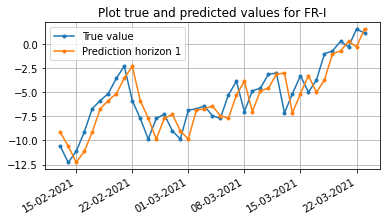

In [18]:
loc = 'BE'
df_predicted = dg.remove_padded_y(Y_pred_unscaled, idx=test_idx, return_type='dict_df', geo=dg.loc_init)
df_actual = dg.remove_padded_y(Y_test, idx=test_idx, return_type='dict_df', geo=dg.loc_init)
plot_prediction_vs_actual(df_actual, df_predicted, dg.get_y_dates(test_idx), 'FR-I', horizon=1)

# def plot_prediction_vs_actual(df_y_real, df_y_predicted, prediction_dates, cur_loc, horizon=1, mode=0):

### Dense model

In [19]:
batch_size = len(X_train)
batch_input_shape = (batch_size, n_samples, n_features)
dense_model_train = get_dense_model(batch_input_shape)
print(dense_model_train.output_shape)
dense_model_train.summary()
start = time.time()
dense_model_train.fit(X_train, Y_train, epochs=400, verbose=1, batch_size=batch_size)
end = time.time() - start
print(f"computed in {str(str(timedelta(seconds=end)))} s")

(61576, 20)
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (61576, 30)               0         
_________________________________________________________________
dense_7 (Dense)              (61576, 20)               620       
Total params: 620
Trainable params: 620
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
1/1 [==============================] - 0s 151ms/step - loss: 0.3921 - mse: 0.3921 - mae: 0.5040 - root_mean_squared_error: 0.6262
Epoch 2/400
1/1 [==============================] - 0s 7ms/step - loss: 0.3566 - mse: 0.3566 - mae: 0.4770 - root_mean_squared_error: 0.5972
Epoch 3/400
1/1 [==============================] - 0s 10ms/step - loss: 0.3333 - mse: 0.3333 - mae: 0.4587 - root_mean_squared_error: 0.5773
Epoch 4/400
1/1 [==============================] - 0s 5ms/step - loss: 0.3151 - mse

1/1 [==============================] - 0s 5ms/step - loss: 0.0775 - mse: 0.0775 - mae: 0.1968 - root_mean_squared_error: 0.2784
Epoch 55/400
1/1 [==============================] - 0s 5ms/step - loss: 0.0761 - mse: 0.0761 - mae: 0.1947 - root_mean_squared_error: 0.2759
Epoch 56/400
1/1 [==============================] - 0s 5ms/step - loss: 0.0748 - mse: 0.0748 - mae: 0.1927 - root_mean_squared_error: 0.2735
Epoch 57/400
1/1 [==============================] - 0s 5ms/step - loss: 0.0735 - mse: 0.0735 - mae: 0.1908 - root_mean_squared_error: 0.2711
Epoch 58/400
1/1 [==============================] - 0s 5ms/step - loss: 0.0723 - mse: 0.0723 - mae: 0.1890 - root_mean_squared_error: 0.2688
Epoch 59/400
1/1 [==============================] - 0s 6ms/step - loss: 0.0711 - mse: 0.0711 - mae: 0.1872 - root_mean_squared_error: 0.2666
Epoch 60/400
1/1 [==============================] - 0s 6ms/step - loss: 0.0700 - mse: 0.0700 - mae: 0.1854 - root_mean_squared_error: 0.2645
Epoch 61/400
1/1 [========

1/1 [==============================] - 0s 5ms/step - loss: 0.0424 - mse: 0.0424 - mae: 0.1365 - root_mean_squared_error: 0.2058
Epoch 113/400
1/1 [==============================] - 0s 6ms/step - loss: 0.0420 - mse: 0.0420 - mae: 0.1359 - root_mean_squared_error: 0.2050
Epoch 114/400
1/1 [==============================] - 0s 5ms/step - loss: 0.0417 - mse: 0.0417 - mae: 0.1353 - root_mean_squared_error: 0.2042
Epoch 115/400
1/1 [==============================] - 0s 5ms/step - loss: 0.0414 - mse: 0.0414 - mae: 0.1347 - root_mean_squared_error: 0.2034
Epoch 116/400
1/1 [==============================] - 0s 5ms/step - loss: 0.0411 - mse: 0.0411 - mae: 0.1342 - root_mean_squared_error: 0.2026
Epoch 117/400
1/1 [==============================] - 0s 5ms/step - loss: 0.0407 - mse: 0.0407 - mae: 0.1336 - root_mean_squared_error: 0.2019
Epoch 118/400
1/1 [==============================] - 0s 6ms/step - loss: 0.0404 - mse: 0.0404 - mae: 0.1330 - root_mean_squared_error: 0.2011
Epoch 119/400
1/1 [=

1/1 [==============================] - 0s 6ms/step - loss: 0.0300 - mse: 0.0300 - mae: 0.1141 - root_mean_squared_error: 0.1731
Epoch 170/400
1/1 [==============================] - 0s 6ms/step - loss: 0.0299 - mse: 0.0299 - mae: 0.1139 - root_mean_squared_error: 0.1728
Epoch 171/400
1/1 [==============================] - 0s 6ms/step - loss: 0.0297 - mse: 0.0297 - mae: 0.1137 - root_mean_squared_error: 0.1725
Epoch 172/400
1/1 [==============================] - 0s 5ms/step - loss: 0.0296 - mse: 0.0296 - mae: 0.1135 - root_mean_squared_error: 0.1721
Epoch 173/400
1/1 [==============================] - 0s 6ms/step - loss: 0.0295 - mse: 0.0295 - mae: 0.1134 - root_mean_squared_error: 0.1718
Epoch 174/400
1/1 [==============================] - 0s 5ms/step - loss: 0.0294 - mse: 0.0294 - mae: 0.1131 - root_mean_squared_error: 0.1715
Epoch 175/400
1/1 [==============================] - 0s 6ms/step - loss: 0.0293 - mse: 0.0293 - mae: 0.1130 - root_mean_squared_error: 0.1712
Epoch 176/400
1/1 [=

1/1 [==============================] - 0s 5ms/step - loss: 0.0259 - mse: 0.0259 - mae: 0.1077 - root_mean_squared_error: 0.1609
Epoch 227/400
1/1 [==============================] - 0s 6ms/step - loss: 0.0258 - mse: 0.0258 - mae: 0.1079 - root_mean_squared_error: 0.1607
Epoch 228/400
1/1 [==============================] - 0s 6ms/step - loss: 0.0258 - mse: 0.0258 - mae: 0.1076 - root_mean_squared_error: 0.1606
Epoch 229/400
1/1 [==============================] - 0s 6ms/step - loss: 0.0258 - mse: 0.0258 - mae: 0.1078 - root_mean_squared_error: 0.1605
Epoch 230/400
1/1 [==============================] - 0s 6ms/step - loss: 0.0257 - mse: 0.0257 - mae: 0.1074 - root_mean_squared_error: 0.1604
Epoch 231/400
1/1 [==============================] - 0s 7ms/step - loss: 0.0257 - mse: 0.0257 - mae: 0.1077 - root_mean_squared_error: 0.1603
Epoch 232/400
1/1 [==============================] - 0s 6ms/step - loss: 0.0256 - mse: 0.0256 - mae: 0.1073 - root_mean_squared_error: 0.1601
Epoch 233/400
1/1 [=

1/1 [==============================] - 0s 6ms/step - loss: 0.0242 - mse: 0.0242 - mae: 0.1050 - root_mean_squared_error: 0.1556
Epoch 284/400
1/1 [==============================] - 0s 5ms/step - loss: 0.0242 - mse: 0.0242 - mae: 0.1046 - root_mean_squared_error: 0.1555
Epoch 285/400
1/1 [==============================] - 0s 6ms/step - loss: 0.0242 - mse: 0.0242 - mae: 0.1049 - root_mean_squared_error: 0.1554
Epoch 286/400
1/1 [==============================] - 0s 5ms/step - loss: 0.0241 - mse: 0.0241 - mae: 0.1045 - root_mean_squared_error: 0.1554
Epoch 287/400
1/1 [==============================] - 0s 6ms/step - loss: 0.0241 - mse: 0.0241 - mae: 0.1048 - root_mean_squared_error: 0.1553
Epoch 288/400
1/1 [==============================] - 0s 6ms/step - loss: 0.0241 - mse: 0.0241 - mae: 0.1044 - root_mean_squared_error: 0.1553
Epoch 289/400
1/1 [==============================] - 0s 6ms/step - loss: 0.0241 - mse: 0.0241 - mae: 0.1047 - root_mean_squared_error: 0.1552
Epoch 290/400
1/1 [=

1/1 [==============================] - 0s 5ms/step - loss: 0.0232 - mse: 0.0232 - mae: 0.1023 - root_mean_squared_error: 0.1525
Epoch 341/400
1/1 [==============================] - 0s 5ms/step - loss: 0.0232 - mse: 0.0232 - mae: 0.1026 - root_mean_squared_error: 0.1524
Epoch 342/400
1/1 [==============================] - 0s 5ms/step - loss: 0.0232 - mse: 0.0232 - mae: 0.1022 - root_mean_squared_error: 0.1524
Epoch 343/400
1/1 [==============================] - 0s 5ms/step - loss: 0.0232 - mse: 0.0232 - mae: 0.1025 - root_mean_squared_error: 0.1523
Epoch 344/400
1/1 [==============================] - 0s 6ms/step - loss: 0.0232 - mse: 0.0232 - mae: 0.1022 - root_mean_squared_error: 0.1523
Epoch 345/400
1/1 [==============================] - 0s 10ms/step - loss: 0.0232 - mse: 0.0232 - mae: 0.1025 - root_mean_squared_error: 0.1523
Epoch 346/400
1/1 [==============================] - 0s 6ms/step - loss: 0.0232 - mse: 0.0232 - mae: 0.1021 - root_mean_squared_error: 0.1522
Epoch 347/400
1/1 [

1/1 [==============================] - 0s 3ms/step - loss: 0.0226 - mse: 0.0226 - mae: 0.1008 - root_mean_squared_error: 0.1504
Epoch 398/400
1/1 [==============================] - 0s 4ms/step - loss: 0.0226 - mse: 0.0226 - mae: 0.1005 - root_mean_squared_error: 0.1503
Epoch 399/400
1/1 [==============================] - 0s 4ms/step - loss: 0.0226 - mse: 0.0226 - mae: 0.1008 - root_mean_squared_error: 0.1503
Epoch 400/400
1/1 [==============================] - 0s 5ms/step - loss: 0.0226 - mse: 0.0226 - mae: 0.1004 - root_mean_squared_error: 0.1503
computed in 0:00:03.174850 s


In [20]:
batch_size = len(X_test)
dense_model_pred = get_dense_model(batch_input_shape=(batch_size, n_samples, n_features) )
dense_model_pred.set_weights(dense_model_train.get_weights())

Y_pred = np.squeeze(dense_model_pred.predict(X_test, batch_size=batch_size))
Y_pred_unscaled = dg.inverse_transform_y(Y_pred, idx=test_idx, geo=dg.loc_init)
Y_pred_real = dg.remove_padded_y(Y_pred_unscaled, idx=test_idx, geo=dg.loc_init)

compute_error(Y_pred_real, Y_test_real)

,MAE(t+1),MSE(t+1),MAE(t+2),MSE(t+2),MAE(t+3),MSE(t+3),MAE(t+4),MSE(t+4),MAE(t+5),MSE(t+5),...,MAE(t+16),MSE(t+16),MAE(t+17),MSE(t+17),MAE(t+18),MSE(t+18),MAE(t+19),MSE(t+19),MAE(t+20),MSE(t+20)
0,4.183613,37.64569,5.518753,67.801497,6.902325,100.78906,6.93938,110.519651,7.441996,125.528128,...,9.955083,260.233671,10.418484,282.095582,10.592799,306.915463,10.677025,304.047939,11.250903,325.497256


# Walk forward analysis
Several windows are generated and the error is computed over time on each of those windows
At each iteration, the previous test set is added to the new training set and another test set is created

Exemple:
1.  - train:  [0, 1, 2, 3, 4, 5]
    - test: [6, 7]
2.  - train:  [0, 1, 2, 3, 4, 5, 6, 7]
    - test: [8, 9]

and so on

In [21]:
class ValidationLogger(ProgbarLogger):
    """
    compute metrics on the validation set, using a different batch size than the training set
    at the end of each epoch, the weights of the training model are used to set the validation model
    the error is computed based on the unscaled and unpadded values
    """
    
    def __init__(self, validation_model, val_batch_size, X_val, Y_val, val_idx, val_geo):
        """
        :param validation_model: validation model ready to be used
        :param X_val: X validation set
        :param Y_val: Y validation set, already unscaled and unpadded
        :param val_idx: validation idx
        :param val_geo: validation geoloc
        """
        super(ValidationLogger, self).__init__(count_mode='steps')
        self.validation_model = validation_model
        self.val_batch_size = val_batch_size
        self.X_val = X_val
        self.Y_val = Y_val
        self.val_idx = val_idx
        self.val_geo = val_geo
    
    def on_epoch_end(self, epoch, logs=None):
        """
        at the end of each epoch, compute the metrics asked on the validation set
        """
        self.validation_model.set_weights(self.model.get_weights())
        Y_pred = self.validation_model.predict(self.X_val, batch_size=self.val_batch_size)
        Y_pred = dg.inverse_transform_y(Y_pred, geo=self.val_geo, idx=self.val_idx)
        Y_pred = dg.remove_padded_y(Y_pred, geo=self.val_geo, idx=self.val_idx)
        for metric in validation_metrics:
            metric.reset_states()
            metric.update_state(Y_pred, self.Y_val)
            logs[f"val_{metric.name}"] = metric.result().numpy()  # prepend name for validation set
        super(ValidationLogger, self).on_epoch_end(epoch, logs)
        


In [22]:
def walk_forward_evaluation_untrainable(model_generator: callable, nb_fit_first: int, nb_validation: int, 
                                        nb_test: int, verbose: int = 1, *args, **kwargs) -> pd.DataFrame:
    """
    walk forward evaluation for an untrainable model
    """
    # initial index used
    max_len = dg.batch_size
    train_idx = np.arange(nb_fit_first)
    valid_idx = np.arange(nb_fit_first, nb_fit_first + nb_validation)  # validation set is simply ignored
    if nb_fit_first + nb_validation >= max_len:
        finished = True  # no test can be done
    else:
        finished = False  # a test set can be created
        test_idx = np.arange(nb_fit_first + nb_validation, min(nb_fit_first + nb_validation + nb_test, max_len))
    df_error = pd.DataFrame()
    walk = 0
    last_iter = False  # True when the last iteration is reached
    while not finished:
        X_train = dg.get_x(train_idx)  # set the scalers
        Y_train = dg.get_y(train_idx)
        X_test = dg.get_x(test_idx, geo=dg.loc_init, use_previous_scaler=True)
        Y_test_real = dg.get_y(test_idx, geo=dg.loc_init, scaled=False)
        Y_test_real = dg.remove_padded_y(Y_test_real, geo=dg.loc_init, idx=test_idx)
        
        batch_size = len(X_test)
        model_pred = model_generator(batch_input_shape=(batch_size, n_samples, n_features))
        Y_predicted = model_pred.predict(X_test, batch_size=batch_size)
        Y_predicted_real = dg.inverse_transform_y(Y_predicted, geo=dg.loc_init, idx=test_idx)
        Y_predicted_real = dg.remove_padded_y(Y_predicted_real, geo=dg.loc_init, idx=test_idx)
        
        
        # compute the error using the unpadded and unscaled data
        error = compute_error(Y_test_real, Y_predicted_real)
        name = f'walk {walk + 1}'
        error['walk'] = name
        error['nb_test_datapoints'] = len(Y_test_real)
        error['days_train'] = len(train_idx)
        error['days_valid'] = len(valid_idx)
        error['days_test'] = len(test_idx)
        error = error.set_index('walk')
        df_error = df_error.append(error)

        if verbose != 0:
            display(df_error)
        if last_iter:
            finished = True
        # indexes for next fit
        train_idx = np.arange(train_idx[-1] + 1 + nb_test)
        valid_idx += nb_test
        if test_idx[-1] + nb_test >= max_len:  # last iteration, less points can be used for the test set
            last_iter = True  # last iteration to be done
            test_idx = np.arange(test_idx[-1], max_len)
        else:
            test_idx += nb_test
        walk += 1
    return df_error


def walk_forward_evaluation(model_generator: callable, nb_fit_first: int, nb_validation: int, nb_test: int, 
                            epochs: int = 400, plot=False, verbose: int = 1,
                            return_history: bool = False, batch_size_fun: callable = None,
                            es_stop_val: bool = False, *args, **kwargs
                           ) -> Union[pd.DataFrame, List[History]]:
    """
    evaluates a model using a walk forward evaluation: multiples fit are done, each followed by at most nb_test
    to evaluate the model
    :param model_generator: function returning the model to evaluate
    :param nb_fit_first: number of datapoints used for the first fit
    :param nb_validation: number of datapoints used for each evaluation set
    :param nb_test: number of datapoints used for the test set (at most)
    :param epochs: number of epochs used on each fit
    :param callbacks: list of callbacks to use
    :param verbose: verbose level. Passed to fit and used to display the error dataframe
    :param return_history: if True, returns the list of history of each walk
    :param batch_size_fun: function used to compute the batch size based on the X_train tensor
        if not specified, default to batch_size = len(train_idx)
    """
    # initial index used
    max_len = dg.batch_size
    train_idx = np.arange(nb_fit_first)
    valid_idx = np.arange(nb_fit_first, nb_fit_first + nb_validation)
    if nb_fit_first + nb_validation >= max_len:
        finished = True  # no test can be done
    else:
        finished = False  # a test set can be created
        test_idx = np.arange(nb_fit_first + nb_validation, min(nb_fit_first + nb_validation + nb_test, max_len))
    df_error = pd.DataFrame()
    walk = 0
    last_iter = False  # True when the last iteration is reached
    all_history = []
    
    while not finished:
        X_train = dg.get_x(train_idx)
        Y_train = dg.get_y(train_idx)
        if batch_size_fun is None:
            batch_size = len(X_train)
        else:
            batch_size = batch_size_fun(X_train)
            
        if len(valid_idx) > 0:
            X_val = dg.get_x(valid_idx, geo=dg.loc_init, use_previous_scaler=True)
            Y_val_real = dg.get_y(valid_idx, geo=dg.loc_init, scaled=False)
            Y_val_real = dg.remove_padded_y(Y_val_real, geo=dg.loc_init, idx=valid_idx)
            batch_size_val = len(X_val)
            model_validation = model_generator(batch_input_shape=(batch_size_val, n_samples, n_features))
            val_log = ValidationLogger(model_validation, len(X_val), X_val, Y_val_real, valid_idx, dg.loc_init)
            if es_stop_val:
                callbacks = [val_log, EarlyStopping(monitor="val_root_mean_squared_error", patience=25)]
            else:
                callbacks = [val_log]
        else:
            callbacks = None
            
        model_train = model_generator(batch_input_shape=(batch_size, n_samples, n_features))

        history = model_train.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, callbacks=callbacks, verbose=verbose)
        
        # test only on the unaugmented data without padding
        batch_size = len(test_idx)
        # construct a new model and use the previous weights to set it
        model_pred = model_generator(batch_input_shape=(batch_size, n_samples, n_features))
        model_pred.set_weights(model_train.get_weights())
        X_test = dg.get_x(test_idx, geo=dg.loc_init, use_previous_scaler=True)
        Y_test = dg.get_y(test_idx, geo=dg.loc_init, use_previous_scaler=True)
        Y_test_real = dg.get_y(test_idx, geo=dg.loc_init, scaled=False)
        Y_test_real = dg.remove_padded_y(Y_test_real, geo=dg.loc_init, idx=test_idx)
        Y_predicted = model_pred.predict(X_test, batch_size=batch_size)
        Y_predicted_real = dg.inverse_transform_y(Y_predicted, geo=dg.loc_init, idx=test_idx)
        Y_predicted_real = dg.remove_padded_y(Y_predicted_real, geo=dg.loc_init, idx=test_idx)        
        if return_history:
            # add test metrics to the history for this walk, based on the unpadded unscaled data 
            # except for the loss
            for metric in model_train.metrics:
                metric.reset_states()
                if metric.name == 'loss':
                    metric.update_state(Y_predicted_real, Y_test_real)
                else:
                    # compute metric accross each horizon
                    for i in range(n_forecast):
                        metric.update_state(Y_predicted_real[:, i], Y_test_real[:, i])
                        history.history[f"test_{metric.name}(t+{i+1})"] = [metric.result().numpy()]
                        metric.reset_states()
                    # compute mean of metric on all horizon
                    metric.update_state(Y_predicted_real, Y_test_real)
                # prepend name for test set
                history.history[f"test_{metric.name}"] = [metric.result().numpy()]
            # add number of unpadded datapoints
            history.history['nb_test_datapoints'] = [len(Y_test_real)]
            all_history.append(history)
        if not return_history or verbose != 0:
            # compute the error using the unpadded and unscaled data
            error = compute_error(Y_test_real, Y_predicted_real)
            name = f'walk {walk + 1}'
            error['walk'] = name
            error['nb_test_datapoints'] = len(Y_test_real)
            error['days_train'] = len(train_idx)
            error['days_valid'] = len(valid_idx)
            error['days_test'] = len(test_idx)
            error = error.set_index('walk')
            df_error = df_error.append(error)
        if verbose != 0:
            display(df_error)
        if last_iter:
            finished = True
        # indexes for next fit
        train_idx = np.arange(train_idx[-1] + 1 + nb_test)
        valid_idx += nb_test
        if test_idx[-1] + nb_test >= max_len:  # last iteration, less points can be used for the test set
            last_iter = True  # last iteration to be done
            test_idx = np.arange(test_idx[-1], max_len)
        else:
            test_idx += nb_test
        walk += 1
    if not return_history:
        df_error.loc['mean'] = df_error.mean()
        
    return df_error if not return_history else all_history

In [29]:
no_div = lambda x : len(x)
df_errors = walk_forward_evaluation(get_encoder_decoder, 250, 0, 30, epochs=110, verbose=1, batch_size_fun=no_div,
                                   es_stop_val=False)

Epoch 1/110
1/1 [==============================] - 2s 2s/step - loss: 0.0088 - mse: 0.1321 - mae: 0.2358 - root_mean_squared_error: 0.3635
Epoch 2/110
1/1 [==============================] - 0s 75ms/step - loss: 0.0087 - mse: 0.1274 - mae: 0.2267 - root_mean_squared_error: 0.3569
Epoch 3/110
1/1 [==============================] - 0s 76ms/step - loss: 0.0086 - mse: 0.1230 - mae: 0.2181 - root_mean_squared_error: 0.3507
Epoch 4/110
1/1 [==============================] - 0s 76ms/step - loss: 0.0085 - mse: 0.1189 - mae: 0.2107 - root_mean_squared_error: 0.3449
Epoch 5/110
1/1 [==============================] - 0s 82ms/step - loss: 0.0083 - mse: 0.1151 - mae: 0.2046 - root_mean_squared_error: 0.3393
Epoch 6/110
1/1 [==============================] - 0s 75ms/step - loss: 0.0082 - mse: 0.1116 - mae: 0.1999 - root_mean_squared_error: 0.3340
Epoch 7/110
1/1 [==============================] - 0s 75ms/step - loss: 0.0081 - mse: 0.1082 - mae: 0.1964 - root_mean_squared_error: 0.3289
Epoch 8/110
1/1

,MAE(t+1),MSE(t+1),MAE(t+2),MSE(t+2),MAE(t+3),MSE(t+3),MAE(t+4),MSE(t+4),MAE(t+5),MSE(t+5),...,MAE(t+18),MSE(t+18),MAE(t+19),MSE(t+19),MAE(t+20),MSE(t+20),nb_test_datapoints,days_train,days_valid,days_test
walk,,,,,,,,,,,,,,,,,,,,,
walk 1,33.891014,2276.377162,26.887035,2355.19168,31.85681,3619.692992,32.282559,3765.408654,31.273521,3417.26623,...,31.089489,2797.947726,31.134304,2821.224502,31.078934,2813.836267,690,250,0,30


Epoch 1/110
1/1 [==============================] - 2s 2s/step - loss: 0.0099 - mse: 0.1221 - mae: 0.2252 - root_mean_squared_error: 0.3495
Epoch 2/110
1/1 [==============================] - 0s 86ms/step - loss: 0.0098 - mse: 0.1177 - mae: 0.2178 - root_mean_squared_error: 0.3431
Epoch 3/110
1/1 [==============================] - 0s 82ms/step - loss: 0.0096 - mse: 0.1132 - mae: 0.2116 - root_mean_squared_error: 0.3365
Epoch 4/110
1/1 [==============================] - 0s 83ms/step - loss: 0.0095 - mse: 0.1087 - mae: 0.2064 - root_mean_squared_error: 0.3297
Epoch 5/110
1/1 [==============================] - 0s 83ms/step - loss: 0.0093 - mse: 0.1041 - mae: 0.2022 - root_mean_squared_error: 0.3227
Epoch 6/110
1/1 [==============================] - 0s 84ms/step - loss: 0.0092 - mse: 0.0996 - mae: 0.1986 - root_mean_squared_error: 0.3156
Epoch 7/110
1/1 [==============================] - 0s 83ms/step - loss: 0.0090 - mse: 0.0952 - mae: 0.1957 - root_mean_squared_error: 0.3085
Epoch 8/110
1/1

,MAE(t+1),MSE(t+1),MAE(t+2),MSE(t+2),MAE(t+3),MSE(t+3),MAE(t+4),MSE(t+4),MAE(t+5),MSE(t+5),...,MAE(t+18),MSE(t+18),MAE(t+19),MSE(t+19),MAE(t+20),MSE(t+20),nb_test_datapoints,days_train,days_valid,days_test
walk,,,,,,,,,,,,,,,,,,,,,
walk 1,33.891014,2276.377162,26.887035,2355.191680,31.856810,3619.692992,32.282559,3765.408654,31.273521,3417.266230,...,31.089489,2797.947726,31.134304,2821.224502,31.078934,2813.836267,690,250,0,30
walk 2,30.888036,1653.121248,31.357681,1999.916558,35.629586,2847.297159,40.099847,3774.797508,43.711747,4511.987041,...,48.639819,4025.513836,48.867974,4022.085807,49.202930,4045.991321,690,280,0,30


Epoch 1/110
1/1 [==============================] - 2s 2s/step - loss: 0.0101 - mse: 0.1286 - mae: 0.2431 - root_mean_squared_error: 0.3586
Epoch 2/110
1/1 [==============================] - 0s 92ms/step - loss: 0.0099 - mse: 0.1239 - mae: 0.2353 - root_mean_squared_error: 0.3520
Epoch 3/110
1/1 [==============================] - 0s 93ms/step - loss: 0.0098 - mse: 0.1191 - mae: 0.2286 - root_mean_squared_error: 0.3451
Epoch 4/110
1/1 [==============================] - 0s 91ms/step - loss: 0.0096 - mse: 0.1143 - mae: 0.2228 - root_mean_squared_error: 0.3381
Epoch 5/110
1/1 [==============================] - 0s 93ms/step - loss: 0.0095 - mse: 0.1095 - mae: 0.2176 - root_mean_squared_error: 0.3309
Epoch 6/110
1/1 [==============================] - 0s 91ms/step - loss: 0.0093 - mse: 0.1047 - mae: 0.2129 - root_mean_squared_error: 0.3236
Epoch 7/110
1/1 [==============================] - 0s 91ms/step - loss: 0.0092 - mse: 0.1000 - mae: 0.2087 - root_mean_squared_error: 0.3162
Epoch 8/110
1/1

,MAE(t+1),MSE(t+1),MAE(t+2),MSE(t+2),MAE(t+3),MSE(t+3),MAE(t+4),MSE(t+4),MAE(t+5),MSE(t+5),...,MAE(t+18),MSE(t+18),MAE(t+19),MSE(t+19),MAE(t+20),MSE(t+20),nb_test_datapoints,days_train,days_valid,days_test
walk,,,,,,,,,,,,,,,,,,,,,
walk 1,33.891014,2276.377162,26.887035,2355.191680,31.856810,3619.692992,32.282559,3765.408654,31.273521,3417.266230,...,31.089489,2797.947726,31.134304,2821.224502,31.078934,2813.836267,690,250,0,30
walk 2,30.888036,1653.121248,31.357681,1999.916558,35.629586,2847.297159,40.099847,3774.797508,43.711747,4511.987041,...,48.639819,4025.513836,48.867974,4022.085807,49.202930,4045.991321,690,280,0,30
walk 3,11.685720,301.558285,13.987858,376.261562,17.796556,650.786983,15.254118,540.510029,12.451928,392.258414,...,21.992727,1642.279062,21.798974,1632.429737,21.585757,1622.211532,690,310,0,30


Epoch 1/110
1/1 [==============================] - 3s 3s/step - loss: 0.0111 - mse: 0.1422 - mae: 0.2744 - root_mean_squared_error: 0.3771
Epoch 2/110
1/1 [==============================] - 0s 103ms/step - loss: 0.0109 - mse: 0.1339 - mae: 0.2605 - root_mean_squared_error: 0.3660
Epoch 3/110
1/1 [==============================] - 0s 99ms/step - loss: 0.0107 - mse: 0.1260 - mae: 0.2474 - root_mean_squared_error: 0.3550
Epoch 4/110
1/1 [==============================] - 0s 100ms/step - loss: 0.0105 - mse: 0.1183 - mae: 0.2363 - root_mean_squared_error: 0.3440
Epoch 5/110
1/1 [==============================] - 0s 100ms/step - loss: 0.0103 - mse: 0.1109 - mae: 0.2271 - root_mean_squared_error: 0.3331
Epoch 6/110
1/1 [==============================] - 0s 99ms/step - loss: 0.0101 - mse: 0.1038 - mae: 0.2193 - root_mean_squared_error: 0.3222
Epoch 7/110
1/1 [==============================] - 0s 100ms/step - loss: 0.0099 - mse: 0.0971 - mae: 0.2124 - root_mean_squared_error: 0.3116
Epoch 8/110

,MAE(t+1),MSE(t+1),MAE(t+2),MSE(t+2),MAE(t+3),MSE(t+3),MAE(t+4),MSE(t+4),MAE(t+5),MSE(t+5),...,MAE(t+18),MSE(t+18),MAE(t+19),MSE(t+19),MAE(t+20),MSE(t+20),nb_test_datapoints,days_train,days_valid,days_test
walk,,,,,,,,,,,,,,,,,,,,,
walk 1,33.891014,2276.377162,26.887035,2355.191680,31.856810,3619.692992,32.282559,3765.408654,31.273521,3417.266230,...,31.089489,2797.947726,31.134304,2821.224502,31.078934,2813.836267,690,250,0,30
walk 2,30.888036,1653.121248,31.357681,1999.916558,35.629586,2847.297159,40.099847,3774.797508,43.711747,4511.987041,...,48.639819,4025.513836,48.867974,4022.085807,49.202930,4045.991321,690,280,0,30
walk 3,11.685720,301.558285,13.987858,376.261562,17.796556,650.786983,15.254118,540.510029,12.451928,392.258414,...,21.992727,1642.279062,21.798974,1632.429737,21.585757,1622.211532,690,310,0,30
walk 4,8.522693,157.755638,19.310074,1128.025699,26.141576,2428.842782,24.564105,2639.762221,21.749523,2208.252094,...,15.098253,495.444274,15.618334,532.254402,16.259822,577.492237,690,340,0,30


Epoch 1/110
1/1 [==============================] - 2s 2s/step - loss: 0.0110 - mse: 0.1467 - mae: 0.2855 - root_mean_squared_error: 0.3830
Epoch 2/110
1/1 [==============================] - 0s 109ms/step - loss: 0.0108 - mse: 0.1395 - mae: 0.2744 - root_mean_squared_error: 0.3735
Epoch 3/110
1/1 [==============================] - 0s 109ms/step - loss: 0.0106 - mse: 0.1325 - mae: 0.2636 - root_mean_squared_error: 0.3641
Epoch 4/110
1/1 [==============================] - 0s 109ms/step - loss: 0.0104 - mse: 0.1258 - mae: 0.2536 - root_mean_squared_error: 0.3547
Epoch 5/110
1/1 [==============================] - 0s 108ms/step - loss: 0.0101 - mse: 0.1193 - mae: 0.2446 - root_mean_squared_error: 0.3454
Epoch 6/110
1/1 [==============================] - 0s 108ms/step - loss: 0.0099 - mse: 0.1129 - mae: 0.2365 - root_mean_squared_error: 0.3361
Epoch 7/110
1/1 [==============================] - 0s 108ms/step - loss: 0.0097 - mse: 0.1068 - mae: 0.2289 - root_mean_squared_error: 0.3268
Epoch 8/1

,MAE(t+1),MSE(t+1),MAE(t+2),MSE(t+2),MAE(t+3),MSE(t+3),MAE(t+4),MSE(t+4),MAE(t+5),MSE(t+5),...,MAE(t+18),MSE(t+18),MAE(t+19),MSE(t+19),MAE(t+20),MSE(t+20),nb_test_datapoints,days_train,days_valid,days_test
walk,,,,,,,,,,,,,,,,,,,,,
walk 1,33.891014,2276.377162,26.887035,2355.191680,31.856810,3619.692992,32.282559,3765.408654,31.273521,3417.266230,...,31.089489,2797.947726,31.134304,2821.224502,31.078934,2813.836267,690,250,0,30
walk 2,30.888036,1653.121248,31.357681,1999.916558,35.629586,2847.297159,40.099847,3774.797508,43.711747,4511.987041,...,48.639819,4025.513836,48.867974,4022.085807,49.202930,4045.991321,690,280,0,30
walk 3,11.685720,301.558285,13.987858,376.261562,17.796556,650.786983,15.254118,540.510029,12.451928,392.258414,...,21.992727,1642.279062,21.798974,1632.429737,21.585757,1622.211532,690,310,0,30
walk 4,8.522693,157.755638,19.310074,1128.025699,26.141576,2428.842782,24.564105,2639.762221,21.749523,2208.252094,...,15.098253,495.444274,15.618334,532.254402,16.259822,577.492237,690,340,0,30
walk 5,17.637493,810.003537,8.711992,219.205996,11.689298,423.745652,10.273818,280.483629,10.954835,267.011492,...,51.856631,6386.986316,52.924450,6576.095731,53.857251,6783.106815,322,370,0,14


In [17]:
df_errors = walk_forward_evaluation(get_encoder_decoder, 250, 10, 30, epochs=300, verbose=1, batch_size_fun=no_div,
                                   es_stop_val=False)

Epoch 1/300
1/1 [==============================] - 3s 3s/step - loss: 0.0087 - mse: 0.1274 - mae: 0.2248 - root_mean_squared_error: 0.3569 - val_mean_squared_error: 12819.6621 - val_mean_absolute_error: 76.3948 - val_root_mean_squared_error: 113.2239
Epoch 2/300
1/1 [==============================] - 0s 111ms/step - loss: 0.0086 - mse: 0.1214 - mae: 0.2136 - root_mean_squared_error: 0.3485 - val_mean_squared_error: 11708.5752 - val_mean_absolute_error: 72.7158 - val_root_mean_squared_error: 108.2062
Epoch 3/300
1/1 [==============================] - 0s 112ms/step - loss: 0.0084 - mse: 0.1159 - mae: 0.2042 - root_mean_squared_error: 0.3404 - val_mean_squared_error: 10689.0928 - val_mean_absolute_error: 69.0638 - val_root_mean_squared_error: 103.3881
Epoch 4/300
1/1 [==============================] - 0s 114ms/step - loss: 0.0083 - mse: 0.1107 - mae: 0.1975 - root_mean_squared_error: 0.3327 - val_mean_squared_error: 9757.3838 - val_mean_absolute_error: 65.4378 - val_root_mean_squared_erro

1/1 [==============================] - 0s 109ms/step - loss: 0.0035 - mse: 0.0571 - mae: 0.1738 - root_mean_squared_error: 0.2389 - val_mean_squared_error: 9669.5840 - val_mean_absolute_error: 55.9783 - val_root_mean_squared_error: 98.3340
Epoch 66/300
1/1 [==============================] - 0s 106ms/step - loss: 0.0034 - mse: 0.0557 - mae: 0.1725 - root_mean_squared_error: 0.2361 - val_mean_squared_error: 9026.2002 - val_mean_absolute_error: 53.9414 - val_root_mean_squared_error: 95.0063
Epoch 67/300
1/1 [==============================] - 0s 106ms/step - loss: 0.0033 - mse: 0.0545 - mae: 0.1714 - root_mean_squared_error: 0.2334 - val_mean_squared_error: 8447.5137 - val_mean_absolute_error: 51.9933 - val_root_mean_squared_error: 91.9104
Epoch 68/300
1/1 [==============================] - 0s 103ms/step - loss: 0.0033 - mse: 0.0534 - mae: 0.1704 - root_mean_squared_error: 0.2311 - val_mean_squared_error: 7896.8848 - val_mean_absolute_error: 50.0394 - val_root_mean_squared_error: 88.8644
E

1/1 [==============================] - 0s 105ms/step - loss: 7.5856e-04 - mse: 0.0309 - mae: 0.1154 - root_mean_squared_error: 0.1758 - val_mean_squared_error: 1920.2766 - val_mean_absolute_error: 19.6536 - val_root_mean_squared_error: 43.8210
Epoch 130/300
1/1 [==============================] - 0s 106ms/step - loss: 7.4335e-04 - mse: 0.0307 - mae: 0.1149 - root_mean_squared_error: 0.1753 - val_mean_squared_error: 1959.0580 - val_mean_absolute_error: 19.9297 - val_root_mean_squared_error: 44.2612
Epoch 131/300
1/1 [==============================] - 0s 100ms/step - loss: 7.2860e-04 - mse: 0.0306 - mae: 0.1144 - root_mean_squared_error: 0.1748 - val_mean_squared_error: 2002.7102 - val_mean_absolute_error: 20.2455 - val_root_mean_squared_error: 44.7516
Epoch 132/300
1/1 [==============================] - 0s 105ms/step - loss: 7.1433e-04 - mse: 0.0304 - mae: 0.1139 - root_mean_squared_error: 0.1743 - val_mean_squared_error: 2042.4351 - val_mean_absolute_error: 20.5606 - val_root_mean_squar

Epoch 161/300
1/1 [==============================] - 0s 102ms/step - loss: 4.7216e-04 - mse: 0.0277 - mae: 0.1082 - root_mean_squared_error: 0.1663 - val_mean_squared_error: 2088.6086 - val_mean_absolute_error: 24.6837 - val_root_mean_squared_error: 45.7013
Epoch 162/300
1/1 [==============================] - 0s 104ms/step - loss: 4.6736e-04 - mse: 0.0276 - mae: 0.1081 - root_mean_squared_error: 0.1661 - val_mean_squared_error: 2110.5281 - val_mean_absolute_error: 24.9360 - val_root_mean_squared_error: 45.9405
Epoch 163/300
1/1 [==============================] - 0s 108ms/step - loss: 4.6269e-04 - mse: 0.0275 - mae: 0.1081 - root_mean_squared_error: 0.1658 - val_mean_squared_error: 2133.1228 - val_mean_absolute_error: 25.1840 - val_root_mean_squared_error: 46.1857
Epoch 164/300
1/1 [==============================] - 0s 104ms/step - loss: 4.5812e-04 - mse: 0.0274 - mae: 0.1080 - root_mean_squared_error: 0.1656 - val_mean_squared_error: 2157.2378 - val_mean_absolute_error: 25.4377 - val_r

Epoch 193/300
1/1 [==============================] - 0s 111ms/step - loss: 3.4826e-04 - mse: 0.0248 - mae: 0.1018 - root_mean_squared_error: 0.1574 - val_mean_squared_error: 3269.4155 - val_mean_absolute_error: 33.1461 - val_root_mean_squared_error: 57.1788
Epoch 194/300
1/1 [==============================] - 0s 106ms/step - loss: 3.4503e-04 - mse: 0.0247 - mae: 0.1015 - root_mean_squared_error: 0.1571 - val_mean_squared_error: 3295.8672 - val_mean_absolute_error: 33.2462 - val_root_mean_squared_error: 57.4096
Epoch 195/300
1/1 [==============================] - 0s 109ms/step - loss: 3.4184e-04 - mse: 0.0246 - mae: 0.1011 - root_mean_squared_error: 0.1567 - val_mean_squared_error: 3329.0332 - val_mean_absolute_error: 33.3753 - val_root_mean_squared_error: 57.6978
Epoch 196/300
1/1 [==============================] - 0s 105ms/step - loss: 3.3869e-04 - mse: 0.0244 - mae: 0.1008 - root_mean_squared_error: 0.1564 - val_mean_squared_error: 3361.4875 - val_mean_absolute_error: 33.4909 - val_r

Epoch 225/300
1/1 [==============================] - 0s 103ms/step - loss: 2.6450e-04 - mse: 0.0203 - mae: 0.0910 - root_mean_squared_error: 0.1426 - val_mean_squared_error: 3150.4451 - val_mean_absolute_error: 30.0854 - val_root_mean_squared_error: 56.1288
Epoch 226/300
1/1 [==============================] - 0s 106ms/step - loss: 2.6177e-04 - mse: 0.0202 - mae: 0.0890 - root_mean_squared_error: 0.1421 - val_mean_squared_error: 3113.7004 - val_mean_absolute_error: 29.8035 - val_root_mean_squared_error: 55.8005
Epoch 227/300
1/1 [==============================] - 0s 101ms/step - loss: 2.5972e-04 - mse: 0.0201 - mae: 0.0884 - root_mean_squared_error: 0.1416 - val_mean_squared_error: 3272.4978 - val_mean_absolute_error: 30.3964 - val_root_mean_squared_error: 57.2057
Epoch 228/300
1/1 [==============================] - 0s 102ms/step - loss: 2.5790e-04 - mse: 0.0199 - mae: 0.0895 - root_mean_squared_error: 0.1410 - val_mean_squared_error: 3101.2986 - val_mean_absolute_error: 29.4917 - val_r

Epoch 257/300
1/1 [==============================] - 0s 101ms/step - loss: 2.0178e-04 - mse: 0.0145 - mae: 0.0746 - root_mean_squared_error: 0.1206 - val_mean_squared_error: 2544.7297 - val_mean_absolute_error: 23.1406 - val_root_mean_squared_error: 50.4453
Epoch 258/300
1/1 [==============================] - 0s 105ms/step - loss: 2.0017e-04 - mse: 0.0144 - mae: 0.0744 - root_mean_squared_error: 0.1199 - val_mean_squared_error: 2440.8274 - val_mean_absolute_error: 22.6006 - val_root_mean_squared_error: 49.4047
Epoch 259/300
1/1 [==============================] - 0s 108ms/step - loss: 1.9858e-04 - mse: 0.0142 - mae: 0.0735 - root_mean_squared_error: 0.1191 - val_mean_squared_error: 2499.3445 - val_mean_absolute_error: 22.7649 - val_root_mean_squared_error: 49.9934
Epoch 260/300
1/1 [==============================] - 0s 104ms/step - loss: 1.9700e-04 - mse: 0.0140 - mae: 0.0735 - root_mean_squared_error: 0.1184 - val_mean_squared_error: 2394.6445 - val_mean_absolute_error: 22.2379 - val_r

Epoch 289/300
1/1 [==============================] - 0s 103ms/step - loss: 1.6270e-04 - mse: 0.0103 - mae: 0.0617 - root_mean_squared_error: 0.1014 - val_mean_squared_error: 1488.5778 - val_mean_absolute_error: 16.8987 - val_root_mean_squared_error: 38.5821
Epoch 290/300
1/1 [==============================] - 0s 100ms/step - loss: 1.6252e-04 - mse: 0.0102 - mae: 0.0612 - root_mean_squared_error: 0.1012 - val_mean_squared_error: 1692.7625 - val_mean_absolute_error: 17.8498 - val_root_mean_squared_error: 41.1432
Epoch 291/300
1/1 [==============================] - 0s 104ms/step - loss: 1.6184e-04 - mse: 0.0102 - mae: 0.0619 - root_mean_squared_error: 0.1012 - val_mean_squared_error: 1495.7712 - val_mean_absolute_error: 16.9143 - val_root_mean_squared_error: 38.6752
Epoch 292/300
1/1 [==============================] - 0s 97ms/step - loss: 1.6046e-04 - mse: 0.0100 - mae: 0.0608 - root_mean_squared_error: 0.1002 - val_mean_squared_error: 1475.2616 - val_mean_absolute_error: 16.8156 - val_ro

,MAE(t+1),MSE(t+1),MAE(t+2),MSE(t+2),MAE(t+3),MSE(t+3),MAE(t+4),MSE(t+4),MAE(t+5),MSE(t+5),...,MAE(t+18),MSE(t+18),MAE(t+19),MSE(t+19),MAE(t+20),MSE(t+20),nb_test_datapoints,days_train,days_valid,days_test
walk,,,,,,,,,,,,,,,,,,,,,
walk 1,7.394378,147.777518,6.916687,128.259888,9.026905,192.478539,11.463426,288.138842,13.482703,387.987492,...,20.682134,1209.51016,20.551544,1224.341838,20.370684,1229.458748,690,250,10,30


Epoch 1/300
1/1 [==============================] - 2s 2s/step - loss: 0.0100 - mse: 0.1290 - mae: 0.2378 - root_mean_squared_error: 0.3592 - val_mean_squared_error: 4502.0522 - val_mean_absolute_error: 49.9908 - val_root_mean_squared_error: 67.0973
Epoch 2/300
1/1 [==============================] - 0s 118ms/step - loss: 0.0098 - mse: 0.1227 - mae: 0.2262 - root_mean_squared_error: 0.3504 - val_mean_squared_error: 3854.0710 - val_mean_absolute_error: 46.5840 - val_root_mean_squared_error: 62.0812
Epoch 3/300
1/1 [==============================] - 0s 112ms/step - loss: 0.0096 - mse: 0.1166 - mae: 0.2169 - root_mean_squared_error: 0.3415 - val_mean_squared_error: 3246.1892 - val_mean_absolute_error: 43.0235 - val_root_mean_squared_error: 56.9753
Epoch 4/300
1/1 [==============================] - 0s 115ms/step - loss: 0.0094 - mse: 0.1106 - mae: 0.2098 - root_mean_squared_error: 0.3325 - val_mean_squared_error: 2684.2185 - val_mean_absolute_error: 39.2768 - val_root_mean_squared_error: 51.

1/1 [==============================] - 0s 112ms/step - loss: 0.0038 - mse: 0.0554 - mae: 0.1521 - root_mean_squared_error: 0.2354 - val_mean_squared_error: 909.4752 - val_mean_absolute_error: 17.7451 - val_root_mean_squared_error: 30.1575
Epoch 66/300
1/1 [==============================] - 0s 113ms/step - loss: 0.0037 - mse: 0.0547 - mae: 0.1512 - root_mean_squared_error: 0.2339 - val_mean_squared_error: 993.6424 - val_mean_absolute_error: 18.3574 - val_root_mean_squared_error: 31.5221
Epoch 67/300
1/1 [==============================] - 0s 114ms/step - loss: 0.0036 - mse: 0.0539 - mae: 0.1503 - root_mean_squared_error: 0.2321 - val_mean_squared_error: 1080.8542 - val_mean_absolute_error: 18.9728 - val_root_mean_squared_error: 32.8763
Epoch 68/300
1/1 [==============================] - 0s 114ms/step - loss: 0.0035 - mse: 0.0528 - mae: 0.1494 - root_mean_squared_error: 0.2299 - val_mean_squared_error: 1180.4554 - val_mean_absolute_error: 19.6661 - val_root_mean_squared_error: 34.3578
Epo

1/1 [==============================] - 0s 115ms/step - loss: 7.7401e-04 - mse: 0.0265 - mae: 0.1054 - root_mean_squared_error: 0.1627 - val_mean_squared_error: 321.2398 - val_mean_absolute_error: 12.3969 - val_root_mean_squared_error: 17.9232
Epoch 130/300
1/1 [==============================] - 0s 110ms/step - loss: 7.5529e-04 - mse: 0.0262 - mae: 0.1047 - root_mean_squared_error: 0.1618 - val_mean_squared_error: 303.4613 - val_mean_absolute_error: 12.1646 - val_root_mean_squared_error: 17.4201
Epoch 131/300
1/1 [==============================] - 0s 115ms/step - loss: 7.3680e-04 - mse: 0.0258 - mae: 0.1038 - root_mean_squared_error: 0.1607 - val_mean_squared_error: 294.2686 - val_mean_absolute_error: 12.0342 - val_root_mean_squared_error: 17.1543
Epoch 132/300
1/1 [==============================] - 0s 117ms/step - loss: 7.1862e-04 - mse: 0.0255 - mae: 0.1028 - root_mean_squared_error: 0.1596 - val_mean_squared_error: 293.5818 - val_mean_absolute_error: 11.9895 - val_root_mean_squared_e

Epoch 161/300
1/1 [==============================] - 0s 111ms/step - loss: 4.0871e-04 - mse: 0.0202 - mae: 0.0894 - root_mean_squared_error: 0.1423 - val_mean_squared_error: 1777.2076 - val_mean_absolute_error: 21.4605 - val_root_mean_squared_error: 42.1569
Epoch 162/300
1/1 [==============================] - 0s 110ms/step - loss: 4.0360e-04 - mse: 0.0201 - mae: 0.0895 - root_mean_squared_error: 0.1419 - val_mean_squared_error: 1837.9001 - val_mean_absolute_error: 21.6378 - val_root_mean_squared_error: 42.8707
Epoch 163/300
1/1 [==============================] - 0s 116ms/step - loss: 3.9879e-04 - mse: 0.0201 - mae: 0.0896 - root_mean_squared_error: 0.1416 - val_mean_squared_error: 1879.8118 - val_mean_absolute_error: 21.7629 - val_root_mean_squared_error: 43.3568
Epoch 164/300
1/1 [==============================] - 0s 114ms/step - loss: 3.9423e-04 - mse: 0.0200 - mae: 0.0896 - root_mean_squared_error: 0.1413 - val_mean_squared_error: 1929.1237 - val_mean_absolute_error: 21.8968 - val_r

Epoch 193/300
1/1 [==============================] - 0s 115ms/step - loss: 3.1692e-04 - mse: 0.0188 - mae: 0.0902 - root_mean_squared_error: 0.1370 - val_mean_squared_error: 1408.8428 - val_mean_absolute_error: 19.5350 - val_root_mean_squared_error: 37.5346
Epoch 194/300
1/1 [==============================] - 0s 114ms/step - loss: 3.1647e-04 - mse: 0.0187 - mae: 0.0890 - root_mean_squared_error: 0.1366 - val_mean_squared_error: 1700.1853 - val_mean_absolute_error: 20.2743 - val_root_mean_squared_error: 41.2333
Epoch 195/300
1/1 [==============================] - 0s 113ms/step - loss: 3.1477e-04 - mse: 0.0189 - mae: 0.0921 - root_mean_squared_error: 0.1375 - val_mean_squared_error: 1501.9456 - val_mean_absolute_error: 19.7369 - val_root_mean_squared_error: 38.7549
Epoch 196/300
1/1 [==============================] - 0s 110ms/step - loss: 3.1188e-04 - mse: 0.0187 - mae: 0.0902 - root_mean_squared_error: 0.1367 - val_mean_squared_error: 1357.9526 - val_mean_absolute_error: 19.3130 - val_r

Epoch 225/300
1/1 [==============================] - 0s 110ms/step - loss: 2.7333e-04 - mse: 0.0178 - mae: 0.0867 - root_mean_squared_error: 0.1335 - val_mean_squared_error: 929.7324 - val_mean_absolute_error: 17.0493 - val_root_mean_squared_error: 30.4915
Epoch 226/300
1/1 [==============================] - 0s 113ms/step - loss: 2.7228e-04 - mse: 0.0178 - mae: 0.0871 - root_mean_squared_error: 0.1335 - val_mean_squared_error: 870.7188 - val_mean_absolute_error: 16.7988 - val_root_mean_squared_error: 29.5079
Epoch 227/300
1/1 [==============================] - 0s 107ms/step - loss: 2.7124e-04 - mse: 0.0177 - mae: 0.0861 - root_mean_squared_error: 0.1331 - val_mean_squared_error: 913.4182 - val_mean_absolute_error: 16.9343 - val_root_mean_squared_error: 30.2228
Epoch 228/300
1/1 [==============================] - 0s 117ms/step - loss: 2.7017e-04 - mse: 0.0178 - mae: 0.0869 - root_mean_squared_error: 0.1332 - val_mean_squared_error: 856.1657 - val_mean_absolute_error: 16.6833 - val_root_

Epoch 257/300
1/1 [==============================] - 0s 111ms/step - loss: 2.4490e-04 - mse: 0.0164 - mae: 0.0805 - root_mean_squared_error: 0.1283 - val_mean_squared_error: 784.7771 - val_mean_absolute_error: 15.6843 - val_root_mean_squared_error: 28.0139
Epoch 258/300
1/1 [==============================] - 0s 116ms/step - loss: 2.4312e-04 - mse: 0.0165 - mae: 0.0828 - root_mean_squared_error: 0.1285 - val_mean_squared_error: 752.5686 - val_mean_absolute_error: 15.5349 - val_root_mean_squared_error: 27.4330
Epoch 259/300
1/1 [==============================] - 0s 114ms/step - loss: 2.4199e-04 - mse: 0.0164 - mae: 0.0820 - root_mean_squared_error: 0.1282 - val_mean_squared_error: 678.4437 - val_mean_absolute_error: 15.2194 - val_root_mean_squared_error: 26.0470
Epoch 260/300
1/1 [==============================] - 0s 110ms/step - loss: 2.4184e-04 - mse: 0.0163 - mae: 0.0805 - root_mean_squared_error: 0.1278 - val_mean_squared_error: 820.9910 - val_mean_absolute_error: 15.7730 - val_root_

Epoch 289/300
1/1 [==============================] - 0s 109ms/step - loss: 2.1968e-04 - mse: 0.0150 - mae: 0.0761 - root_mean_squared_error: 0.1223 - val_mean_squared_error: 755.1135 - val_mean_absolute_error: 14.9538 - val_root_mean_squared_error: 27.4793
Epoch 290/300
1/1 [==============================] - 0s 111ms/step - loss: 2.1900e-04 - mse: 0.0149 - mae: 0.0770 - root_mean_squared_error: 0.1223 - val_mean_squared_error: 682.9843 - val_mean_absolute_error: 14.6811 - val_root_mean_squared_error: 26.1340
Epoch 291/300
1/1 [==============================] - 0s 108ms/step - loss: 2.1831e-04 - mse: 0.0149 - mae: 0.0757 - root_mean_squared_error: 0.1219 - val_mean_squared_error: 754.8105 - val_mean_absolute_error: 14.9174 - val_root_mean_squared_error: 27.4738
Epoch 292/300
1/1 [==============================] - 0s 112ms/step - loss: 2.1761e-04 - mse: 0.0149 - mae: 0.0767 - root_mean_squared_error: 0.1219 - val_mean_squared_error: 682.7805 - val_mean_absolute_error: 14.6541 - val_root_

,MAE(t+1),MSE(t+1),MAE(t+2),MSE(t+2),MAE(t+3),MSE(t+3),MAE(t+4),MSE(t+4),MAE(t+5),MSE(t+5),...,MAE(t+18),MSE(t+18),MAE(t+19),MSE(t+19),MAE(t+20),MSE(t+20),nb_test_datapoints,days_train,days_valid,days_test
walk,,,,,,,,,,,,,,,,,,,,,
walk 1,7.394378,147.777518,6.916687,128.259888,9.026905,192.478539,11.463426,288.138842,13.482703,387.987492,...,20.682134,1209.510160,20.551544,1224.341838,20.370684,1229.458748,690,250,10,30
walk 2,7.553648,112.836974,8.658789,155.741256,10.493977,212.047078,11.751885,256.633431,12.764216,301.052188,...,21.441562,847.746991,21.797061,877.464669,22.103486,904.866546,690,280,10,30


Epoch 1/300
1/1 [==============================] - 3s 3s/step - loss: 0.0104 - mse: 0.1474 - mae: 0.2785 - root_mean_squared_error: 0.3840 - val_mean_squared_error: 8930.1523 - val_mean_absolute_error: 72.2892 - val_root_mean_squared_error: 94.4995
Epoch 2/300
1/1 [==============================] - 0s 123ms/step - loss: 0.0102 - mse: 0.1377 - mae: 0.2626 - root_mean_squared_error: 0.3711 - val_mean_squared_error: 7884.0991 - val_mean_absolute_error: 68.5304 - val_root_mean_squared_error: 88.7924
Epoch 3/300
1/1 [==============================] - 0s 120ms/step - loss: 0.0100 - mse: 0.1289 - mae: 0.2478 - root_mean_squared_error: 0.3590 - val_mean_squared_error: 6948.0718 - val_mean_absolute_error: 64.8957 - val_root_mean_squared_error: 83.3551
Epoch 4/300
1/1 [==============================] - 0s 120ms/step - loss: 0.0098 - mse: 0.1209 - mae: 0.2348 - root_mean_squared_error: 0.3477 - val_mean_squared_error: 6102.5884 - val_mean_absolute_error: 61.3365 - val_root_mean_squared_error: 78.

1/1 [==============================] - 0s 121ms/step - loss: 0.0040 - mse: 0.0552 - mae: 0.1892 - root_mean_squared_error: 0.2350 - val_mean_squared_error: 927.3553 - val_mean_absolute_error: 18.8024 - val_root_mean_squared_error: 30.4525
Epoch 66/300
1/1 [==============================] - 0s 122ms/step - loss: 0.0040 - mse: 0.0540 - mae: 0.1846 - root_mean_squared_error: 0.2323 - val_mean_squared_error: 811.4874 - val_mean_absolute_error: 17.9270 - val_root_mean_squared_error: 28.4866
Epoch 67/300
1/1 [==============================] - 0s 116ms/step - loss: 0.0039 - mse: 0.0528 - mae: 0.1801 - root_mean_squared_error: 0.2299 - val_mean_squared_error: 740.7081 - val_mean_absolute_error: 17.5971 - val_root_mean_squared_error: 27.2160
Epoch 68/300
1/1 [==============================] - 0s 119ms/step - loss: 0.0038 - mse: 0.0518 - mae: 0.1758 - root_mean_squared_error: 0.2276 - val_mean_squared_error: 714.1721 - val_mean_absolute_error: 17.7853 - val_root_mean_squared_error: 26.7240
Epoch

1/1 [==============================] - 0s 129ms/step - loss: 8.8263e-04 - mse: 0.0295 - mae: 0.1032 - root_mean_squared_error: 0.1718 - val_mean_squared_error: 1000.9194 - val_mean_absolute_error: 18.3914 - val_root_mean_squared_error: 31.6373
Epoch 130/300
1/1 [==============================] - 0s 129ms/step - loss: 8.6423e-04 - mse: 0.0294 - mae: 0.1028 - root_mean_squared_error: 0.1714 - val_mean_squared_error: 1003.8786 - val_mean_absolute_error: 18.3282 - val_root_mean_squared_error: 31.6840
Epoch 131/300
1/1 [==============================] - 0s 131ms/step - loss: 8.4654e-04 - mse: 0.0293 - mae: 0.1023 - root_mean_squared_error: 0.1711 - val_mean_squared_error: 1001.4140 - val_mean_absolute_error: 18.2454 - val_root_mean_squared_error: 31.6451
Epoch 132/300
1/1 [==============================] - 0s 131ms/step - loss: 8.2950e-04 - mse: 0.0291 - mae: 0.1019 - root_mean_squared_error: 0.1707 - val_mean_squared_error: 990.5930 - val_mean_absolute_error: 18.1190 - val_root_mean_square

Epoch 161/300
1/1 [==============================] - 0s 135ms/step - loss: 5.1559e-04 - mse: 0.0251 - mae: 0.0959 - root_mean_squared_error: 0.1585 - val_mean_squared_error: 439.4938 - val_mean_absolute_error: 13.6718 - val_root_mean_squared_error: 20.9641
Epoch 162/300
1/1 [==============================] - 0s 125ms/step - loss: 5.0930e-04 - mse: 0.0250 - mae: 0.0959 - root_mean_squared_error: 0.1581 - val_mean_squared_error: 428.6533 - val_mean_absolute_error: 13.5654 - val_root_mean_squared_error: 20.7039
Epoch 163/300
1/1 [==============================] - 0s 129ms/step - loss: 5.0320e-04 - mse: 0.0249 - mae: 0.0960 - root_mean_squared_error: 0.1577 - val_mean_squared_error: 418.4143 - val_mean_absolute_error: 13.4550 - val_root_mean_squared_error: 20.4552
Epoch 164/300
1/1 [==============================] - 0s 120ms/step - loss: 4.9728e-04 - mse: 0.0247 - mae: 0.0961 - root_mean_squared_error: 0.1573 - val_mean_squared_error: 409.1638 - val_mean_absolute_error: 13.3432 - val_root_

Epoch 193/300
1/1 [==============================] - 0s 122ms/step - loss: 3.8011e-04 - mse: 0.0224 - mae: 0.0985 - root_mean_squared_error: 0.1495 - val_mean_squared_error: 404.2536 - val_mean_absolute_error: 12.6396 - val_root_mean_squared_error: 20.1061
Epoch 194/300
1/1 [==============================] - 0s 123ms/step - loss: 3.7724e-04 - mse: 0.0223 - mae: 0.0984 - root_mean_squared_error: 0.1493 - val_mean_squared_error: 403.9301 - val_mean_absolute_error: 12.6228 - val_root_mean_squared_error: 20.0980
Epoch 195/300
1/1 [==============================] - 0s 128ms/step - loss: 3.7443e-04 - mse: 0.0222 - mae: 0.0983 - root_mean_squared_error: 0.1491 - val_mean_squared_error: 404.1379 - val_mean_absolute_error: 12.6141 - val_root_mean_squared_error: 20.1032
Epoch 196/300
1/1 [==============================] - 0s 120ms/step - loss: 3.7165e-04 - mse: 0.0222 - mae: 0.0982 - root_mean_squared_error: 0.1489 - val_mean_squared_error: 404.8181 - val_mean_absolute_error: 12.6094 - val_root_

Epoch 225/300
1/1 [==============================] - 0s 122ms/step - loss: 3.0410e-04 - mse: 0.0198 - mae: 0.0931 - root_mean_squared_error: 0.1408 - val_mean_squared_error: 442.8622 - val_mean_absolute_error: 12.6225 - val_root_mean_squared_error: 21.0443
Epoch 226/300
1/1 [==============================] - 0s 128ms/step - loss: 3.0205e-04 - mse: 0.0197 - mae: 0.0928 - root_mean_squared_error: 0.1405 - val_mean_squared_error: 444.8260 - val_mean_absolute_error: 12.6324 - val_root_mean_squared_error: 21.0909
Epoch 227/300
1/1 [==============================] - 0s 123ms/step - loss: 3.0000e-04 - mse: 0.0196 - mae: 0.0926 - root_mean_squared_error: 0.1402 - val_mean_squared_error: 446.0925 - val_mean_absolute_error: 12.6348 - val_root_mean_squared_error: 21.1209
Epoch 228/300
1/1 [==============================] - 0s 119ms/step - loss: 2.9796e-04 - mse: 0.0196 - mae: 0.0923 - root_mean_squared_error: 0.1398 - val_mean_squared_error: 447.9583 - val_mean_absolute_error: 12.6429 - val_root_

Epoch 257/300
1/1 [==============================] - 0s 119ms/step - loss: 2.4465e-04 - mse: 0.0164 - mae: 0.0837 - root_mean_squared_error: 0.1283 - val_mean_squared_error: 496.7535 - val_mean_absolute_error: 13.0255 - val_root_mean_squared_error: 22.2880
Epoch 258/300
1/1 [==============================] - 0s 118ms/step - loss: 2.4308e-04 - mse: 0.0163 - mae: 0.0834 - root_mean_squared_error: 0.1278 - val_mean_squared_error: 493.7901 - val_mean_absolute_error: 13.0043 - val_root_mean_squared_error: 22.2214
Epoch 259/300
1/1 [==============================] - 0s 120ms/step - loss: 2.4152e-04 - mse: 0.0162 - mae: 0.0831 - root_mean_squared_error: 0.1274 - val_mean_squared_error: 498.1477 - val_mean_absolute_error: 13.0408 - val_root_mean_squared_error: 22.3192
Epoch 260/300
1/1 [==============================] - 0s 122ms/step - loss: 2.3998e-04 - mse: 0.0161 - mae: 0.0828 - root_mean_squared_error: 0.1269 - val_mean_squared_error: 497.8473 - val_mean_absolute_error: 13.0401 - val_root_

Epoch 289/300
1/1 [==============================] - 0s 114ms/step - loss: 2.0659e-04 - mse: 0.0134 - mae: 0.0754 - root_mean_squared_error: 0.1159 - val_mean_squared_error: 548.8905 - val_mean_absolute_error: 13.3598 - val_root_mean_squared_error: 23.4284
Epoch 290/300
1/1 [==============================] - 0s 126ms/step - loss: 2.0087e-04 - mse: 0.0133 - mae: 0.0756 - root_mean_squared_error: 0.1152 - val_mean_squared_error: 807.8167 - val_mean_absolute_error: 15.5808 - val_root_mean_squared_error: 28.4221
Epoch 291/300
1/1 [==============================] - 0s 121ms/step - loss: 2.0414e-04 - mse: 0.0135 - mae: 0.0777 - root_mean_squared_error: 0.1163 - val_mean_squared_error: 476.0653 - val_mean_absolute_error: 12.7123 - val_root_mean_squared_error: 21.8189
Epoch 292/300
1/1 [==============================] - 0s 121ms/step - loss: 2.0015e-04 - mse: 0.0131 - mae: 0.0748 - root_mean_squared_error: 0.1146 - val_mean_squared_error: 471.0044 - val_mean_absolute_error: 12.7020 - val_root_

,MAE(t+1),MSE(t+1),MAE(t+2),MSE(t+2),MAE(t+3),MSE(t+3),MAE(t+4),MSE(t+4),MAE(t+5),MSE(t+5),...,MAE(t+18),MSE(t+18),MAE(t+19),MSE(t+19),MAE(t+20),MSE(t+20),nb_test_datapoints,days_train,days_valid,days_test
walk,,,,,,,,,,,,,,,,,,,,,
walk 1,7.394378,147.777518,6.916687,128.259888,9.026905,192.478539,11.463426,288.138842,13.482703,387.987492,...,20.682134,1209.510160,20.551544,1224.341838,20.370684,1229.458748,690,250,10,30
walk 2,7.553648,112.836974,8.658789,155.741256,10.493977,212.047078,11.751885,256.633431,12.764216,301.052188,...,21.441562,847.746991,21.797061,877.464669,22.103486,904.866546,690,280,10,30
walk 3,4.037993,35.173777,8.182425,241.919233,8.798257,308.702829,9.611041,340.541329,11.051061,430.820178,...,26.599450,2857.138176,26.879953,2882.526668,27.127009,2894.564178,690,310,10,30


Epoch 1/300
1/1 [==============================] - 3s 3s/step - loss: 0.0112 - mse: 0.1510 - mae: 0.2779 - root_mean_squared_error: 0.3886 - val_mean_squared_error: 7457.9932 - val_mean_absolute_error: 58.0141 - val_root_mean_squared_error: 86.3597
Epoch 2/300
1/1 [==============================] - 0s 132ms/step - loss: 0.0109 - mse: 0.1424 - mae: 0.2654 - root_mean_squared_error: 0.3774 - val_mean_squared_error: 6617.2754 - val_mean_absolute_error: 54.7644 - val_root_mean_squared_error: 81.3466
Epoch 3/300
1/1 [==============================] - 0s 133ms/step - loss: 0.0107 - mse: 0.1345 - mae: 0.2555 - root_mean_squared_error: 0.3667 - val_mean_squared_error: 5842.1338 - val_mean_absolute_error: 51.5412 - val_root_mean_squared_error: 76.4339
Epoch 4/300
1/1 [==============================] - 0s 130ms/step - loss: 0.0105 - mse: 0.1270 - mae: 0.2472 - root_mean_squared_error: 0.3564 - val_mean_squared_error: 5124.5464 - val_mean_absolute_error: 48.3162 - val_root_mean_squared_error: 71.

1/1 [==============================] - 0s 131ms/step - loss: 0.0039 - mse: 0.0463 - mae: 0.1664 - root_mean_squared_error: 0.2151 - val_mean_squared_error: 598.0776 - val_mean_absolute_error: 16.7366 - val_root_mean_squared_error: 24.4556
Epoch 66/300
1/1 [==============================] - 0s 128ms/step - loss: 0.0039 - mse: 0.0455 - mae: 0.1629 - root_mean_squared_error: 0.2134 - val_mean_squared_error: 513.8212 - val_mean_absolute_error: 15.8091 - val_root_mean_squared_error: 22.6676
Epoch 67/300
1/1 [==============================] - 0s 132ms/step - loss: 0.0038 - mse: 0.0449 - mae: 0.1598 - root_mean_squared_error: 0.2120 - val_mean_squared_error: 465.8679 - val_mean_absolute_error: 15.1660 - val_root_mean_squared_error: 21.5840
Epoch 68/300
1/1 [==============================] - 0s 130ms/step - loss: 0.0037 - mse: 0.0444 - mae: 0.1571 - root_mean_squared_error: 0.2108 - val_mean_squared_error: 447.2563 - val_mean_absolute_error: 14.8254 - val_root_mean_squared_error: 21.1484
Epoch

1/1 [==============================] - 0s 134ms/step - loss: 8.2424e-04 - mse: 0.0305 - mae: 0.1128 - root_mean_squared_error: 0.1746 - val_mean_squared_error: 1220.1118 - val_mean_absolute_error: 16.9857 - val_root_mean_squared_error: 34.9301
Epoch 130/300
1/1 [==============================] - 0s 126ms/step - loss: 8.0824e-04 - mse: 0.0304 - mae: 0.1126 - root_mean_squared_error: 0.1742 - val_mean_squared_error: 1201.0085 - val_mean_absolute_error: 16.8010 - val_root_mean_squared_error: 34.6556
Epoch 131/300
1/1 [==============================] - 0s 131ms/step - loss: 7.9274e-04 - mse: 0.0301 - mae: 0.1122 - root_mean_squared_error: 0.1736 - val_mean_squared_error: 1170.1738 - val_mean_absolute_error: 16.5484 - val_root_mean_squared_error: 34.2078
Epoch 132/300
1/1 [==============================] - 0s 143ms/step - loss: 7.7768e-04 - mse: 0.0299 - mae: 0.1117 - root_mean_squared_error: 0.1728 - val_mean_squared_error: 1133.7522 - val_mean_absolute_error: 16.2630 - val_root_mean_squar

Epoch 161/300
1/1 [==============================] - 0s 130ms/step - loss: 5.2922e-04 - mse: 0.0248 - mae: 0.1003 - root_mean_squared_error: 0.1575 - val_mean_squared_error: 364.5079 - val_mean_absolute_error: 10.9079 - val_root_mean_squared_error: 19.0921
Epoch 162/300
1/1 [==============================] - 0s 130ms/step - loss: 5.2430e-04 - mse: 0.0247 - mae: 0.1003 - root_mean_squared_error: 0.1570 - val_mean_squared_error: 357.4692 - val_mean_absolute_error: 10.8778 - val_root_mean_squared_error: 18.9069
Epoch 163/300
1/1 [==============================] - 0s 129ms/step - loss: 5.1948e-04 - mse: 0.0245 - mae: 0.1002 - root_mean_squared_error: 0.1566 - val_mean_squared_error: 350.6717 - val_mean_absolute_error: 10.8425 - val_root_mean_squared_error: 18.7262
Epoch 164/300
1/1 [==============================] - 0s 130ms/step - loss: 5.1476e-04 - mse: 0.0244 - mae: 0.1002 - root_mean_squared_error: 0.1562 - val_mean_squared_error: 344.7356 - val_mean_absolute_error: 10.8148 - val_root_

Epoch 193/300
1/1 [==============================] - 0s 137ms/step - loss: 4.1152e-04 - mse: 0.0219 - mae: 0.1017 - root_mean_squared_error: 0.1479 - val_mean_squared_error: 372.8969 - val_mean_absolute_error: 11.2717 - val_root_mean_squared_error: 19.3105
Epoch 194/300
1/1 [==============================] - 0s 126ms/step - loss: 4.0883e-04 - mse: 0.0218 - mae: 0.1017 - root_mean_squared_error: 0.1477 - val_mean_squared_error: 373.8807 - val_mean_absolute_error: 11.2796 - val_root_mean_squared_error: 19.3360
Epoch 195/300
1/1 [==============================] - 0s 127ms/step - loss: 4.0619e-04 - mse: 0.0218 - mae: 0.1017 - root_mean_squared_error: 0.1476 - val_mean_squared_error: 375.2039 - val_mean_absolute_error: 11.2916 - val_root_mean_squared_error: 19.3702
Epoch 196/300
1/1 [==============================] - 0s 127ms/step - loss: 4.0358e-04 - mse: 0.0217 - mae: 0.1018 - root_mean_squared_error: 0.1474 - val_mean_squared_error: 375.1729 - val_mean_absolute_error: 11.2899 - val_root_

Epoch 225/300
1/1 [==============================] - 0s 127ms/step - loss: 3.3698e-04 - mse: 0.0199 - mae: 0.0970 - root_mean_squared_error: 0.1411 - val_mean_squared_error: 393.1545 - val_mean_absolute_error: 11.5839 - val_root_mean_squared_error: 19.8281
Epoch 226/300
1/1 [==============================] - 0s 127ms/step - loss: 3.3483e-04 - mse: 0.0198 - mae: 0.0967 - root_mean_squared_error: 0.1408 - val_mean_squared_error: 397.2260 - val_mean_absolute_error: 11.6316 - val_root_mean_squared_error: 19.9305
Epoch 227/300
1/1 [==============================] - 0s 130ms/step - loss: 3.3269e-04 - mse: 0.0198 - mae: 0.0964 - root_mean_squared_error: 0.1406 - val_mean_squared_error: 401.4781 - val_mean_absolute_error: 11.6823 - val_root_mean_squared_error: 20.0369
Epoch 228/300
1/1 [==============================] - 0s 127ms/step - loss: 3.3056e-04 - mse: 0.0197 - mae: 0.0962 - root_mean_squared_error: 0.1403 - val_mean_squared_error: 408.1296 - val_mean_absolute_error: 11.7581 - val_root_

Epoch 257/300
1/1 [==============================] - 0s 130ms/step - loss: 2.7219e-04 - mse: 0.0173 - mae: 0.0876 - root_mean_squared_error: 0.1315 - val_mean_squared_error: 608.5657 - val_mean_absolute_error: 13.7206 - val_root_mean_squared_error: 24.6691
Epoch 258/300
1/1 [==============================] - 0s 132ms/step - loss: 2.7037e-04 - mse: 0.0172 - mae: 0.0873 - root_mean_squared_error: 0.1312 - val_mean_squared_error: 612.6367 - val_mean_absolute_error: 13.7624 - val_root_mean_squared_error: 24.7515
Epoch 259/300
1/1 [==============================] - 0s 133ms/step - loss: 2.6856e-04 - mse: 0.0171 - mae: 0.0870 - root_mean_squared_error: 0.1309 - val_mean_squared_error: 614.5967 - val_mean_absolute_error: 13.7858 - val_root_mean_squared_error: 24.7911
Epoch 260/300
1/1 [==============================] - 0s 131ms/step - loss: 2.6676e-04 - mse: 0.0171 - mae: 0.0867 - root_mean_squared_error: 0.1306 - val_mean_squared_error: 620.4384 - val_mean_absolute_error: 13.8391 - val_root_

Epoch 289/300
1/1 [==============================] - 0s 125ms/step - loss: 2.2581e-04 - mse: 0.0150 - mae: 0.0784 - root_mean_squared_error: 0.1224 - val_mean_squared_error: 506.4774 - val_mean_absolute_error: 12.9808 - val_root_mean_squared_error: 22.5051
Epoch 290/300
1/1 [==============================] - 0s 123ms/step - loss: 2.2451e-04 - mse: 0.0149 - mae: 0.0784 - root_mean_squared_error: 0.1222 - val_mean_squared_error: 575.6083 - val_mean_absolute_error: 13.5952 - val_root_mean_squared_error: 23.9918
Epoch 291/300
1/1 [==============================] - 0s 130ms/step - loss: 2.2381e-04 - mse: 0.0149 - mae: 0.0797 - root_mean_squared_error: 0.1222 - val_mean_squared_error: 506.8707 - val_mean_absolute_error: 12.9787 - val_root_mean_squared_error: 22.5138
Epoch 292/300
1/1 [==============================] - 0s 126ms/step - loss: 2.2215e-04 - mse: 0.0148 - mae: 0.0781 - root_mean_squared_error: 0.1216 - val_mean_squared_error: 479.8089 - val_mean_absolute_error: 12.7158 - val_root_

,MAE(t+1),MSE(t+1),MAE(t+2),MSE(t+2),MAE(t+3),MSE(t+3),MAE(t+4),MSE(t+4),MAE(t+5),MSE(t+5),...,MAE(t+18),MSE(t+18),MAE(t+19),MSE(t+19),MAE(t+20),MSE(t+20),nb_test_datapoints,days_train,days_valid,days_test
walk,,,,,,,,,,,,,,,,,,,,,
walk 1,7.394378,147.777518,6.916687,128.259888,9.026905,192.478539,11.463426,288.138842,13.482703,387.987492,...,20.682134,1209.510160,20.551544,1224.341838,20.370684,1229.458748,690,250,10,30
walk 2,7.553648,112.836974,8.658789,155.741256,10.493977,212.047078,11.751885,256.633431,12.764216,301.052188,...,21.441562,847.746991,21.797061,877.464669,22.103486,904.866546,690,280,10,30
walk 3,4.037993,35.173777,8.182425,241.919233,8.798257,308.702829,9.611041,340.541329,11.051061,430.820178,...,26.599450,2857.138176,26.879953,2882.526668,27.127009,2894.564178,690,310,10,30
walk 4,4.207228,44.498830,5.483801,94.402741,6.174751,100.333436,7.124296,129.640746,7.932227,169.224361,...,16.761242,589.140900,17.668234,643.431342,18.553694,707.982510,690,340,10,30


Epoch 1/300
1/1 [==============================] - 3s 3s/step - loss: 0.0108 - mse: 0.1242 - mae: 0.2512 - root_mean_squared_error: 0.3524 - val_mean_squared_error: 13413.0908 - val_mean_absolute_error: 69.5936 - val_root_mean_squared_error: 115.8149
Epoch 2/300
1/1 [==============================] - 0s 139ms/step - loss: 0.0105 - mse: 0.1163 - mae: 0.2403 - root_mean_squared_error: 0.3410 - val_mean_squared_error: 12069.7363 - val_mean_absolute_error: 65.9240 - val_root_mean_squared_error: 109.8624
Epoch 3/300
1/1 [==============================] - 0s 137ms/step - loss: 0.0103 - mse: 0.1086 - mae: 0.2308 - root_mean_squared_error: 0.3295 - val_mean_squared_error: 10749.7686 - val_mean_absolute_error: 62.0888 - val_root_mean_squared_error: 103.6811
Epoch 4/300
1/1 [==============================] - 0s 137ms/step - loss: 0.0101 - mse: 0.1012 - mae: 0.2221 - root_mean_squared_error: 0.3182 - val_mean_squared_error: 9459.9434 - val_mean_absolute_error: 58.0798 - val_root_mean_squared_erro

1/1 [==============================] - 0s 138ms/step - loss: 0.0037 - mse: 0.0458 - mae: 0.1485 - root_mean_squared_error: 0.2140 - val_mean_squared_error: 3625.6245 - val_mean_absolute_error: 28.7006 - val_root_mean_squared_error: 60.2132
Epoch 66/300
1/1 [==============================] - 0s 141ms/step - loss: 0.0036 - mse: 0.0459 - mae: 0.1474 - root_mean_squared_error: 0.2143 - val_mean_squared_error: 4011.7449 - val_mean_absolute_error: 30.1739 - val_root_mean_squared_error: 63.3383
Epoch 67/300
1/1 [==============================] - 0s 137ms/step - loss: 0.0036 - mse: 0.0461 - mae: 0.1469 - root_mean_squared_error: 0.2146 - val_mean_squared_error: 4378.8213 - val_mean_absolute_error: 31.5594 - val_root_mean_squared_error: 66.1727
Epoch 68/300
1/1 [==============================] - 0s 140ms/step - loss: 0.0035 - mse: 0.0462 - mae: 0.1469 - root_mean_squared_error: 0.2150 - val_mean_squared_error: 4727.1172 - val_mean_absolute_error: 32.8716 - val_root_mean_squared_error: 68.7540
E

1/1 [==============================] - 0s 143ms/step - loss: 7.6975e-04 - mse: 0.0253 - mae: 0.1016 - root_mean_squared_error: 0.1592 - val_mean_squared_error: 665.9357 - val_mean_absolute_error: 17.2939 - val_root_mean_squared_error: 25.8057
Epoch 130/300
1/1 [==============================] - 0s 137ms/step - loss: 7.5113e-04 - mse: 0.0251 - mae: 0.1009 - root_mean_squared_error: 0.1585 - val_mean_squared_error: 641.5701 - val_mean_absolute_error: 17.0510 - val_root_mean_squared_error: 25.3292
Epoch 131/300
1/1 [==============================] - 0s 141ms/step - loss: 7.3323e-04 - mse: 0.0249 - mae: 0.1003 - root_mean_squared_error: 0.1578 - val_mean_squared_error: 620.4613 - val_mean_absolute_error: 16.8907 - val_root_mean_squared_error: 24.9091
Epoch 132/300
1/1 [==============================] - 0s 136ms/step - loss: 7.1596e-04 - mse: 0.0247 - mae: 0.0996 - root_mean_squared_error: 0.1571 - val_mean_squared_error: 603.5447 - val_mean_absolute_error: 16.7535 - val_root_mean_squared_e

Epoch 161/300
1/1 [==============================] - 0s 137ms/step - loss: 4.1689e-04 - mse: 0.0200 - mae: 0.0931 - root_mean_squared_error: 0.1416 - val_mean_squared_error: 726.6715 - val_mean_absolute_error: 16.5742 - val_root_mean_squared_error: 26.9568
Epoch 162/300
1/1 [==============================] - 0s 138ms/step - loss: 4.1174e-04 - mse: 0.0200 - mae: 0.0932 - root_mean_squared_error: 0.1413 - val_mean_squared_error: 700.3854 - val_mean_absolute_error: 16.4545 - val_root_mean_squared_error: 26.4648
Epoch 163/300
1/1 [==============================] - 0s 137ms/step - loss: 4.0680e-04 - mse: 0.0199 - mae: 0.0934 - root_mean_squared_error: 0.1410 - val_mean_squared_error: 678.0250 - val_mean_absolute_error: 16.3406 - val_root_mean_squared_error: 26.0389
Epoch 164/300
1/1 [==============================] - 0s 133ms/step - loss: 4.0206e-04 - mse: 0.0198 - mae: 0.0935 - root_mean_squared_error: 0.1407 - val_mean_squared_error: 655.2806 - val_mean_absolute_error: 16.2367 - val_root_

Epoch 193/300
1/1 [==============================] - 0s 139ms/step - loss: 3.1434e-04 - mse: 0.0173 - mae: 0.0898 - root_mean_squared_error: 0.1315 - val_mean_squared_error: 389.3861 - val_mean_absolute_error: 13.6290 - val_root_mean_squared_error: 19.7329
Epoch 194/300
1/1 [==============================] - 0s 141ms/step - loss: 3.1121e-04 - mse: 0.0173 - mae: 0.0899 - root_mean_squared_error: 0.1314 - val_mean_squared_error: 393.8860 - val_mean_absolute_error: 13.3980 - val_root_mean_squared_error: 19.8466
Epoch 195/300
1/1 [==============================] - 0s 142ms/step - loss: 3.1059e-04 - mse: 0.0174 - mae: 0.0908 - root_mean_squared_error: 0.1319 - val_mean_squared_error: 390.5348 - val_mean_absolute_error: 13.7274 - val_root_mean_squared_error: 19.7620
Epoch 196/300
1/1 [==============================] - 0s 139ms/step - loss: 3.0803e-04 - mse: 0.0170 - mae: 0.0890 - root_mean_squared_error: 0.1303 - val_mean_squared_error: 383.0803 - val_mean_absolute_error: 13.5071 - val_root_

Epoch 225/300
1/1 [==============================] - 0s 140ms/step - loss: 2.6262e-04 - mse: 0.0148 - mae: 0.0813 - root_mean_squared_error: 0.1215 - val_mean_squared_error: 333.5392 - val_mean_absolute_error: 12.3976 - val_root_mean_squared_error: 18.2631
Epoch 226/300
1/1 [==============================] - 0s 138ms/step - loss: 2.6137e-04 - mse: 0.0147 - mae: 0.0813 - root_mean_squared_error: 0.1214 - val_mean_squared_error: 329.1190 - val_mean_absolute_error: 12.3149 - val_root_mean_squared_error: 18.1416
Epoch 227/300
1/1 [==============================] - 0s 138ms/step - loss: 2.6027e-04 - mse: 0.0147 - mae: 0.0812 - root_mean_squared_error: 0.1213 - val_mean_squared_error: 340.5612 - val_mean_absolute_error: 12.4876 - val_root_mean_squared_error: 18.4543
Epoch 228/300
1/1 [==============================] - 0s 142ms/step - loss: 2.5916e-04 - mse: 0.0146 - mae: 0.0806 - root_mean_squared_error: 0.1207 - val_mean_squared_error: 329.4747 - val_mean_absolute_error: 12.2939 - val_root_

Epoch 257/300
1/1 [==============================] - 0s 134ms/step - loss: 2.3087e-04 - mse: 0.0131 - mae: 0.0753 - root_mean_squared_error: 0.1146 - val_mean_squared_error: 349.5938 - val_mean_absolute_error: 12.4550 - val_root_mean_squared_error: 18.6974
Epoch 258/300
1/1 [==============================] - 0s 136ms/step - loss: 2.3002e-04 - mse: 0.0131 - mae: 0.0750 - root_mean_squared_error: 0.1143 - val_mean_squared_error: 342.3798 - val_mean_absolute_error: 12.3230 - val_root_mean_squared_error: 18.5035
Epoch 259/300
1/1 [==============================] - 0s 135ms/step - loss: 2.2918e-04 - mse: 0.0130 - mae: 0.0750 - root_mean_squared_error: 0.1142 - val_mean_squared_error: 351.1125 - val_mean_absolute_error: 12.4787 - val_root_mean_squared_error: 18.7380
Epoch 260/300
1/1 [==============================] - 0s 135ms/step - loss: 2.2835e-04 - mse: 0.0130 - mae: 0.0747 - root_mean_squared_error: 0.1138 - val_mean_squared_error: 339.7416 - val_mean_absolute_error: 12.2684 - val_root_

Epoch 289/300
1/1 [==============================] - 0s 131ms/step - loss: 2.0682e-04 - mse: 0.0117 - mae: 0.0703 - root_mean_squared_error: 0.1083 - val_mean_squared_error: 333.4628 - val_mean_absolute_error: 12.0582 - val_root_mean_squared_error: 18.2610
Epoch 290/300
1/1 [==============================] - 0s 133ms/step - loss: 2.0625e-04 - mse: 0.0118 - mae: 0.0708 - root_mean_squared_error: 0.1086 - val_mean_squared_error: 375.1274 - val_mean_absolute_error: 12.7579 - val_root_mean_squared_error: 19.3682
Epoch 291/300
1/1 [==============================] - 0s 134ms/step - loss: 2.0530e-04 - mse: 0.0117 - mae: 0.0701 - root_mean_squared_error: 0.1079 - val_mean_squared_error: 364.1476 - val_mean_absolute_error: 12.5757 - val_root_mean_squared_error: 19.0827
Epoch 292/300
1/1 [==============================] - 0s 138ms/step - loss: 2.0449e-04 - mse: 0.0116 - mae: 0.0701 - root_mean_squared_error: 0.1079 - val_mean_squared_error: 340.5757 - val_mean_absolute_error: 12.1748 - val_root_

,MAE(t+1),MSE(t+1),MAE(t+2),MSE(t+2),MAE(t+3),MSE(t+3),MAE(t+4),MSE(t+4),MAE(t+5),MSE(t+5),...,MAE(t+18),MSE(t+18),MAE(t+19),MSE(t+19),MAE(t+20),MSE(t+20),nb_test_datapoints,days_train,days_valid,days_test
walk,,,,,,,,,,,,,,,,,,,,,
walk 1,7.394378,147.777518,6.916687,128.259888,9.026905,192.478539,11.463426,288.138842,13.482703,387.987492,...,20.682134,1209.510160,20.551544,1224.341838,20.370684,1229.458748,690,250,10,30
walk 2,7.553648,112.836974,8.658789,155.741256,10.493977,212.047078,11.751885,256.633431,12.764216,301.052188,...,21.441562,847.746991,21.797061,877.464669,22.103486,904.866546,690,280,10,30
walk 3,4.037993,35.173777,8.182425,241.919233,8.798257,308.702829,9.611041,340.541329,11.051061,430.820178,...,26.599450,2857.138176,26.879953,2882.526668,27.127009,2894.564178,690,310,10,30
walk 4,4.207228,44.498830,5.483801,94.402741,6.174751,100.333436,7.124296,129.640746,7.932227,169.224361,...,16.761242,589.140900,17.668234,643.431342,18.553694,707.982510,690,340,10,30
walk 5,7.462082,214.584734,6.220665,97.775663,7.991964,171.712678,9.606130,243.287463,11.050797,287.567123,...,17.882683,564.096175,18.572415,593.655105,19.069580,630.731182,92,370,10,4


In [18]:
list_history = walk_forward_evaluation(get_encoder_decoder, 250, 10, 30, epochs=300, verbose=1, batch_size_fun=no_div,
                                   es_stop_val=False, return_history=True)

Epoch 1/300
1/1 [==============================] - 3s 3s/step - loss: 0.0086 - mse: 0.1230 - mae: 0.2220 - root_mean_squared_error: 0.3508 - val_mean_squared_error: 12415.0273 - val_mean_absolute_error: 75.1292 - val_root_mean_squared_error: 111.4227
Epoch 2/300
1/1 [==============================] - 0s 107ms/step - loss: 0.0085 - mse: 0.1188 - mae: 0.2131 - root_mean_squared_error: 0.3447 - val_mean_squared_error: 11627.2334 - val_mean_absolute_error: 72.5016 - val_root_mean_squared_error: 107.8297
Epoch 3/300
1/1 [==============================] - 0s 107ms/step - loss: 0.0084 - mse: 0.1147 - mae: 0.2048 - root_mean_squared_error: 0.3387 - val_mean_squared_error: 10871.7764 - val_mean_absolute_error: 69.8361 - val_root_mean_squared_error: 104.2678
Epoch 4/300
1/1 [==============================] - 0s 106ms/step - loss: 0.0083 - mse: 0.1107 - mae: 0.1983 - root_mean_squared_error: 0.3328 - val_mean_squared_error: 10147.5010 - val_mean_absolute_error: 67.1212 - val_root_mean_squared_err

1/1 [==============================] - 0s 103ms/step - loss: 0.0033 - mse: 0.0514 - mae: 0.1581 - root_mean_squared_error: 0.2267 - val_mean_squared_error: 13009.6416 - val_mean_absolute_error: 60.1618 - val_root_mean_squared_error: 114.0598
Epoch 66/300
1/1 [==============================] - 0s 102ms/step - loss: 0.0032 - mse: 0.0498 - mae: 0.1578 - root_mean_squared_error: 0.2231 - val_mean_squared_error: 11241.2881 - val_mean_absolute_error: 56.1012 - val_root_mean_squared_error: 106.0249
Epoch 67/300
1/1 [==============================] - 0s 108ms/step - loss: 0.0031 - mse: 0.0483 - mae: 0.1572 - root_mean_squared_error: 0.2197 - val_mean_squared_error: 9365.7500 - val_mean_absolute_error: 51.3954 - val_root_mean_squared_error: 96.7768
Epoch 68/300
1/1 [==============================] - 0s 101ms/step - loss: 0.0030 - mse: 0.0470 - mae: 0.1563 - root_mean_squared_error: 0.2167 - val_mean_squared_error: 7586.0088 - val_mean_absolute_error: 46.3720 - val_root_mean_squared_error: 87.09

1/1 [==============================] - 0s 104ms/step - loss: 7.1136e-04 - mse: 0.0277 - mae: 0.1068 - root_mean_squared_error: 0.1665 - val_mean_squared_error: 3328.8293 - val_mean_absolute_error: 26.5915 - val_root_mean_squared_error: 57.6960
Epoch 130/300
1/1 [==============================] - 0s 107ms/step - loss: 6.9511e-04 - mse: 0.0276 - mae: 0.1068 - root_mean_squared_error: 0.1660 - val_mean_squared_error: 3436.3044 - val_mean_absolute_error: 27.0433 - val_root_mean_squared_error: 58.6200
Epoch 131/300
1/1 [==============================] - 0s 100ms/step - loss: 6.7938e-04 - mse: 0.0274 - mae: 0.1067 - root_mean_squared_error: 0.1656 - val_mean_squared_error: 3533.8733 - val_mean_absolute_error: 27.4456 - val_root_mean_squared_error: 59.4464
Epoch 132/300
1/1 [==============================] - 0s 103ms/step - loss: 6.6419e-04 - mse: 0.0273 - mae: 0.1066 - root_mean_squared_error: 0.1652 - val_mean_squared_error: 3628.0073 - val_mean_absolute_error: 27.8253 - val_root_mean_squar

Epoch 161/300
1/1 [==============================] - 0s 108ms/step - loss: 4.2248e-04 - mse: 0.0245 - mae: 0.1073 - root_mean_squared_error: 0.1564 - val_mean_squared_error: 5919.8638 - val_mean_absolute_error: 35.5921 - val_root_mean_squared_error: 76.9407
Epoch 162/300
1/1 [==============================] - 0s 105ms/step - loss: 4.1796e-04 - mse: 0.0243 - mae: 0.1069 - root_mean_squared_error: 0.1559 - val_mean_squared_error: 5897.9243 - val_mean_absolute_error: 35.5451 - val_root_mean_squared_error: 76.7979
Epoch 163/300
1/1 [==============================] - 0s 103ms/step - loss: 4.1348e-04 - mse: 0.0241 - mae: 0.1064 - root_mean_squared_error: 0.1553 - val_mean_squared_error: 5888.2935 - val_mean_absolute_error: 35.5334 - val_root_mean_squared_error: 76.7352
Epoch 164/300
1/1 [==============================] - 0s 103ms/step - loss: 4.0904e-04 - mse: 0.0240 - mae: 0.1060 - root_mean_squared_error: 0.1548 - val_mean_squared_error: 5879.0674 - val_mean_absolute_error: 35.5252 - val_r

Epoch 193/300
1/1 [==============================] - 0s 106ms/step - loss: 3.0477e-04 - mse: 0.0184 - mae: 0.0882 - root_mean_squared_error: 0.1357 - val_mean_squared_error: 6351.5547 - val_mean_absolute_error: 36.8073 - val_root_mean_squared_error: 79.6966
Epoch 194/300
1/1 [==============================] - 0s 102ms/step - loss: 3.0213e-04 - mse: 0.0182 - mae: 0.0875 - root_mean_squared_error: 0.1351 - val_mean_squared_error: 6346.7773 - val_mean_absolute_error: 36.7686 - val_root_mean_squared_error: 79.6667
Epoch 195/300
1/1 [==============================] - 0s 107ms/step - loss: 2.9954e-04 - mse: 0.0181 - mae: 0.0869 - root_mean_squared_error: 0.1344 - val_mean_squared_error: 6349.8262 - val_mean_absolute_error: 36.7558 - val_root_mean_squared_error: 79.6858
Epoch 196/300
1/1 [==============================] - 0s 103ms/step - loss: 2.9700e-04 - mse: 0.0179 - mae: 0.0862 - root_mean_squared_error: 0.1337 - val_mean_squared_error: 6342.4712 - val_mean_absolute_error: 36.7047 - val_r

Epoch 225/300
1/1 [==============================] - 0s 103ms/step - loss: 2.4548e-04 - mse: 0.0146 - mae: 0.0747 - root_mean_squared_error: 0.1207 - val_mean_squared_error: 5275.0903 - val_mean_absolute_error: 33.5894 - val_root_mean_squared_error: 72.6298
Epoch 226/300
1/1 [==============================] - 0s 102ms/step - loss: 2.4344e-04 - mse: 0.0147 - mae: 0.0737 - root_mean_squared_error: 0.1214 - val_mean_squared_error: 5194.4800 - val_mean_absolute_error: 33.3253 - val_root_mean_squared_error: 72.0727
Epoch 227/300
1/1 [==============================] - 0s 109ms/step - loss: 2.4240e-04 - mse: 0.0147 - mae: 0.0733 - root_mean_squared_error: 0.1213 - val_mean_squared_error: 5462.3071 - val_mean_absolute_error: 33.9950 - val_root_mean_squared_error: 73.9074
Epoch 228/300
1/1 [==============================] - 0s 105ms/step - loss: 2.4085e-04 - mse: 0.0144 - mae: 0.0736 - root_mean_squared_error: 0.1199 - val_mean_squared_error: 5440.6055 - val_mean_absolute_error: 33.8973 - val_r

Epoch 257/300
1/1 [==============================] - 0s 109ms/step - loss: 2.0769e-04 - mse: 0.0125 - mae: 0.0667 - root_mean_squared_error: 0.1120 - val_mean_squared_error: 4495.1025 - val_mean_absolute_error: 29.6636 - val_root_mean_squared_error: 67.0455
Epoch 258/300
1/1 [==============================] - 0s 101ms/step - loss: 2.0675e-04 - mse: 0.0126 - mae: 0.0665 - root_mean_squared_error: 0.1120 - val_mean_squared_error: 4479.1831 - val_mean_absolute_error: 29.5509 - val_root_mean_squared_error: 66.9267
Epoch 259/300
1/1 [==============================] - 0s 103ms/step - loss: 2.0576e-04 - mse: 0.0124 - mae: 0.0663 - root_mean_squared_error: 0.1116 - val_mean_squared_error: 4480.7710 - val_mean_absolute_error: 29.4929 - val_root_mean_squared_error: 66.9386
Epoch 260/300
1/1 [==============================] - 0s 108ms/step - loss: 2.0485e-04 - mse: 0.0124 - mae: 0.0662 - root_mean_squared_error: 0.1112 - val_mean_squared_error: 4413.2061 - val_mean_absolute_error: 29.2159 - val_r

Epoch 289/300
1/1 [==============================] - 0s 108ms/step - loss: 1.8147e-04 - mse: 0.0110 - mae: 0.0621 - root_mean_squared_error: 0.1050 - val_mean_squared_error: 3565.8972 - val_mean_absolute_error: 24.8727 - val_root_mean_squared_error: 59.7151
Epoch 290/300
1/1 [==============================] - 0s 100ms/step - loss: 1.8078e-04 - mse: 0.0110 - mae: 0.0620 - root_mean_squared_error: 0.1047 - val_mean_squared_error: 3522.7773 - val_mean_absolute_error: 24.6924 - val_root_mean_squared_error: 59.3530
Epoch 291/300
1/1 [==============================] - 0s 104ms/step - loss: 1.8009e-04 - mse: 0.0109 - mae: 0.0619 - root_mean_squared_error: 0.1046 - val_mean_squared_error: 3505.2688 - val_mean_absolute_error: 24.5947 - val_root_mean_squared_error: 59.2053
Epoch 292/300
1/1 [==============================] - 0s 100ms/step - loss: 1.7941e-04 - mse: 0.0109 - mae: 0.0618 - root_mean_squared_error: 0.1043 - val_mean_squared_error: 3478.2688 - val_mean_absolute_error: 24.4548 - val_r

,MAE(t+1),MSE(t+1),MAE(t+2),MSE(t+2),MAE(t+3),MSE(t+3),MAE(t+4),MSE(t+4),MAE(t+5),MSE(t+5),...,MAE(t+18),MSE(t+18),MAE(t+19),MSE(t+19),MAE(t+20),MSE(t+20),nb_test_datapoints,days_train,days_valid,days_test
walk,,,,,,,,,,,,,,,,,,,,,
walk 1,11.012737,268.336162,10.675633,232.289501,14.144878,403.351937,16.977193,577.36851,18.658088,686.987531,...,23.08773,1084.484721,23.172723,1071.744295,23.146342,1054.68355,690,250,10,30


Epoch 1/300
1/1 [==============================] - 3s 3s/step - loss: 0.0102 - mse: 0.1393 - mae: 0.2442 - root_mean_squared_error: 0.3733 - val_mean_squared_error: 4259.2603 - val_mean_absolute_error: 49.0007 - val_root_mean_squared_error: 65.2630
Epoch 2/300
1/1 [==============================] - 0s 128ms/step - loss: 0.0100 - mse: 0.1326 - mae: 0.2349 - root_mean_squared_error: 0.3641 - val_mean_squared_error: 3705.0679 - val_mean_absolute_error: 45.9517 - val_root_mean_squared_error: 60.8693
Epoch 3/300
1/1 [==============================] - 0s 119ms/step - loss: 0.0098 - mse: 0.1262 - mae: 0.2276 - root_mean_squared_error: 0.3552 - val_mean_squared_error: 3201.2629 - val_mean_absolute_error: 42.8804 - val_root_mean_squared_error: 56.5797
Epoch 4/300
1/1 [==============================] - 0s 119ms/step - loss: 0.0097 - mse: 0.1201 - mae: 0.2218 - root_mean_squared_error: 0.3466 - val_mean_squared_error: 2744.8943 - val_mean_absolute_error: 39.7522 - val_root_mean_squared_error: 52.

1/1 [==============================] - 0s 110ms/step - loss: 0.0041 - mse: 0.0564 - mae: 0.1615 - root_mean_squared_error: 0.2375 - val_mean_squared_error: 1270.5212 - val_mean_absolute_error: 23.1832 - val_root_mean_squared_error: 35.6444
Epoch 66/300
1/1 [==============================] - 0s 114ms/step - loss: 0.0040 - mse: 0.0565 - mae: 0.1626 - root_mean_squared_error: 0.2377 - val_mean_squared_error: 1365.7970 - val_mean_absolute_error: 23.2419 - val_root_mean_squared_error: 36.9567
Epoch 67/300
1/1 [==============================] - 0s 115ms/step - loss: 0.0039 - mse: 0.0563 - mae: 0.1637 - root_mean_squared_error: 0.2372 - val_mean_squared_error: 1603.4132 - val_mean_absolute_error: 23.7771 - val_root_mean_squared_error: 40.0426
Epoch 68/300
1/1 [==============================] - 0s 120ms/step - loss: 0.0038 - mse: 0.0558 - mae: 0.1647 - root_mean_squared_error: 0.2361 - val_mean_squared_error: 2139.8516 - val_mean_absolute_error: 25.5745 - val_root_mean_squared_error: 46.2585
E

1/1 [==============================] - 0s 113ms/step - loss: 8.5705e-04 - mse: 0.0272 - mae: 0.1097 - root_mean_squared_error: 0.1649 - val_mean_squared_error: 518.0523 - val_mean_absolute_error: 16.0325 - val_root_mean_squared_error: 22.7608
Epoch 130/300
1/1 [==============================] - 0s 109ms/step - loss: 8.3386e-04 - mse: 0.0268 - mae: 0.1092 - root_mean_squared_error: 0.1638 - val_mean_squared_error: 513.4362 - val_mean_absolute_error: 15.9297 - val_root_mean_squared_error: 22.6591
Epoch 131/300
1/1 [==============================] - 0s 113ms/step - loss: 8.1116e-04 - mse: 0.0265 - mae: 0.1086 - root_mean_squared_error: 0.1627 - val_mean_squared_error: 512.5029 - val_mean_absolute_error: 15.8528 - val_root_mean_squared_error: 22.6385
Epoch 132/300
1/1 [==============================] - 0s 116ms/step - loss: 7.8890e-04 - mse: 0.0261 - mae: 0.1080 - root_mean_squared_error: 0.1616 - val_mean_squared_error: 515.6321 - val_mean_absolute_error: 15.7891 - val_root_mean_squared_e

Epoch 161/300
1/1 [==============================] - 0s 111ms/step - loss: 4.1925e-04 - mse: 0.0193 - mae: 0.0918 - root_mean_squared_error: 0.1389 - val_mean_squared_error: 565.4957 - val_mean_absolute_error: 15.8708 - val_root_mean_squared_error: 23.7802
Epoch 162/300
1/1 [==============================] - 0s 109ms/step - loss: 4.1514e-04 - mse: 0.0193 - mae: 0.0907 - root_mean_squared_error: 0.1388 - val_mean_squared_error: 550.1591 - val_mean_absolute_error: 15.3585 - val_root_mean_squared_error: 23.4555
Epoch 163/300
1/1 [==============================] - 0s 111ms/step - loss: 4.0879e-04 - mse: 0.0190 - mae: 0.0929 - root_mean_squared_error: 0.1379 - val_mean_squared_error: 540.5610 - val_mean_absolute_error: 15.2695 - val_root_mean_squared_error: 23.2500
Epoch 164/300
1/1 [==============================] - 0s 119ms/step - loss: 4.0213e-04 - mse: 0.0189 - mae: 0.0919 - root_mean_squared_error: 0.1374 - val_mean_squared_error: 543.3101 - val_mean_absolute_error: 15.4854 - val_root_

Epoch 193/300
1/1 [==============================] - 0s 114ms/step - loss: 3.0452e-04 - mse: 0.0164 - mae: 0.0868 - root_mean_squared_error: 0.1282 - val_mean_squared_error: 548.5399 - val_mean_absolute_error: 13.7340 - val_root_mean_squared_error: 23.4209
Epoch 194/300
1/1 [==============================] - 0s 113ms/step - loss: 3.0266e-04 - mse: 0.0164 - mae: 0.0874 - root_mean_squared_error: 0.1282 - val_mean_squared_error: 545.0017 - val_mean_absolute_error: 13.8649 - val_root_mean_squared_error: 23.3453
Epoch 195/300
1/1 [==============================] - 0s 113ms/step - loss: 3.0071e-04 - mse: 0.0163 - mae: 0.0863 - root_mean_squared_error: 0.1278 - val_mean_squared_error: 546.0921 - val_mean_absolute_error: 13.8381 - val_root_mean_squared_error: 23.3686
Epoch 196/300
1/1 [==============================] - 0s 116ms/step - loss: 2.9882e-04 - mse: 0.0163 - mae: 0.0864 - root_mean_squared_error: 0.1276 - val_mean_squared_error: 547.6570 - val_mean_absolute_error: 13.7852 - val_root_

Epoch 225/300
1/1 [==============================] - 0s 110ms/step - loss: 2.6176e-04 - mse: 0.0149 - mae: 0.0807 - root_mean_squared_error: 0.1221 - val_mean_squared_error: 560.8754 - val_mean_absolute_error: 14.0185 - val_root_mean_squared_error: 23.6828
Epoch 226/300
1/1 [==============================] - 0s 119ms/step - loss: 2.6078e-04 - mse: 0.0149 - mae: 0.0809 - root_mean_squared_error: 0.1220 - val_mean_squared_error: 557.5599 - val_mean_absolute_error: 14.0683 - val_root_mean_squared_error: 23.6127
Epoch 227/300
1/1 [==============================] - 0s 110ms/step - loss: 2.5982e-04 - mse: 0.0148 - mae: 0.0803 - root_mean_squared_error: 0.1217 - val_mean_squared_error: 558.9854 - val_mean_absolute_error: 14.0213 - val_root_mean_squared_error: 23.6429
Epoch 228/300
1/1 [==============================] - 0s 115ms/step - loss: 2.5886e-04 - mse: 0.0148 - mae: 0.0805 - root_mean_squared_error: 0.1216 - val_mean_squared_error: 555.8536 - val_mean_absolute_error: 14.0937 - val_root_

Epoch 257/300
1/1 [==============================] - 0s 110ms/step - loss: 2.3450e-04 - mse: 0.0136 - mae: 0.0754 - root_mean_squared_error: 0.1164 - val_mean_squared_error: 531.5302 - val_mean_absolute_error: 14.0837 - val_root_mean_squared_error: 23.0549
Epoch 258/300
1/1 [==============================] - 0s 113ms/step - loss: 2.3425e-04 - mse: 0.0135 - mae: 0.0741 - root_mean_squared_error: 0.1160 - val_mean_squared_error: 546.1771 - val_mean_absolute_error: 13.7541 - val_root_mean_squared_error: 23.3704
Epoch 259/300
1/1 [==============================] - 0s 108ms/step - loss: 2.3367e-04 - mse: 0.0136 - mae: 0.0763 - root_mean_squared_error: 0.1165 - val_mean_squared_error: 530.1589 - val_mean_absolute_error: 14.0091 - val_root_mean_squared_error: 23.0252
Epoch 260/300
1/1 [==============================] - 0s 111ms/step - loss: 2.3244e-04 - mse: 0.0134 - mae: 0.0741 - root_mean_squared_error: 0.1158 - val_mean_squared_error: 532.6447 - val_mean_absolute_error: 13.9058 - val_root_

Epoch 289/300
1/1 [==============================] - 0s 109ms/step - loss: 2.1147e-04 - mse: 0.0124 - mae: 0.0709 - root_mean_squared_error: 0.1113 - val_mean_squared_error: 491.7565 - val_mean_absolute_error: 13.1990 - val_root_mean_squared_error: 22.1756
Epoch 290/300
1/1 [==============================] - 0s 107ms/step - loss: 2.1081e-04 - mse: 0.0123 - mae: 0.0702 - root_mean_squared_error: 0.1110 - val_mean_squared_error: 500.0107 - val_mean_absolute_error: 13.0503 - val_root_mean_squared_error: 22.3609
Epoch 291/300
1/1 [==============================] - 0s 115ms/step - loss: 2.1015e-04 - mse: 0.0123 - mae: 0.0708 - root_mean_squared_error: 0.1110 - val_mean_squared_error: 487.1015 - val_mean_absolute_error: 13.1428 - val_root_mean_squared_error: 22.0704
Epoch 292/300
1/1 [==============================] - 0s 108ms/step - loss: 2.0950e-04 - mse: 0.0122 - mae: 0.0698 - root_mean_squared_error: 0.1106 - val_mean_squared_error: 499.4351 - val_mean_absolute_error: 12.9685 - val_root_

,MAE(t+1),MSE(t+1),MAE(t+2),MSE(t+2),MAE(t+3),MSE(t+3),MAE(t+4),MSE(t+4),MAE(t+5),MSE(t+5),...,MAE(t+18),MSE(t+18),MAE(t+19),MSE(t+19),MAE(t+20),MSE(t+20),nb_test_datapoints,days_train,days_valid,days_test
walk,,,,,,,,,,,,,,,,,,,,,
walk 1,11.012737,268.336162,10.675633,232.289501,14.144878,403.351937,16.977193,577.368510,18.658088,686.987531,...,23.08773,1084.484721,23.172723,1071.744295,23.146342,1054.683550,690,250,10,30
walk 2,7.378634,127.815306,5.197811,56.813610,6.518705,92.702116,8.498845,159.492147,10.323784,223.608356,...,28.48750,1429.834857,29.359206,1530.960968,30.105360,1620.852918,690,280,10,30


Epoch 1/300
1/1 [==============================] - 3s 3s/step - loss: 0.0100 - mse: 0.1251 - mae: 0.2419 - root_mean_squared_error: 0.3538 - val_mean_squared_error: 6471.7803 - val_mean_absolute_error: 61.9127 - val_root_mean_squared_error: 80.4474
Epoch 2/300
1/1 [==============================] - 0s 124ms/step - loss: 0.0099 - mse: 0.1188 - mae: 0.2304 - root_mean_squared_error: 0.3447 - val_mean_squared_error: 5790.6152 - val_mean_absolute_error: 58.9392 - val_root_mean_squared_error: 76.0961
Epoch 3/300
1/1 [==============================] - 0s 122ms/step - loss: 0.0097 - mse: 0.1126 - mae: 0.2211 - root_mean_squared_error: 0.3356 - val_mean_squared_error: 5138.4146 - val_mean_absolute_error: 55.8648 - val_root_mean_squared_error: 71.6827
Epoch 4/300
1/1 [==============================] - 0s 120ms/step - loss: 0.0095 - mse: 0.1066 - mae: 0.2137 - root_mean_squared_error: 0.3266 - val_mean_squared_error: 4516.4487 - val_mean_absolute_error: 52.6700 - val_root_mean_squared_error: 67.

1/1 [==============================] - 0s 128ms/step - loss: 0.0038 - mse: 0.0635 - mae: 0.1749 - root_mean_squared_error: 0.2519 - val_mean_squared_error: 2158.4058 - val_mean_absolute_error: 26.1674 - val_root_mean_squared_error: 46.4586
Epoch 66/300
1/1 [==============================] - 0s 131ms/step - loss: 0.0037 - mse: 0.0641 - mae: 0.1769 - root_mean_squared_error: 0.2532 - val_mean_squared_error: 2449.2598 - val_mean_absolute_error: 27.9242 - val_root_mean_squared_error: 49.4900
Epoch 67/300
1/1 [==============================] - 0s 130ms/step - loss: 0.0036 - mse: 0.0646 - mae: 0.1786 - root_mean_squared_error: 0.2541 - val_mean_squared_error: 2671.2917 - val_mean_absolute_error: 29.1869 - val_root_mean_squared_error: 51.6845
Epoch 68/300
1/1 [==============================] - 0s 125ms/step - loss: 0.0036 - mse: 0.0647 - mae: 0.1798 - root_mean_squared_error: 0.2544 - val_mean_squared_error: 2817.3711 - val_mean_absolute_error: 29.9715 - val_root_mean_squared_error: 53.0789
E

1/1 [==============================] - 0s 119ms/step - loss: 7.4326e-04 - mse: 0.0268 - mae: 0.1102 - root_mean_squared_error: 0.1636 - val_mean_squared_error: 663.6680 - val_mean_absolute_error: 16.3678 - val_root_mean_squared_error: 25.7618
Epoch 130/300
1/1 [==============================] - 0s 120ms/step - loss: 7.2802e-04 - mse: 0.0266 - mae: 0.1099 - root_mean_squared_error: 0.1632 - val_mean_squared_error: 661.3879 - val_mean_absolute_error: 16.3147 - val_root_mean_squared_error: 25.7175
Epoch 131/300
1/1 [==============================] - 0s 120ms/step - loss: 7.1332e-04 - mse: 0.0265 - mae: 0.1097 - root_mean_squared_error: 0.1628 - val_mean_squared_error: 657.9037 - val_mean_absolute_error: 16.2529 - val_root_mean_squared_error: 25.6496
Epoch 132/300
1/1 [==============================] - 0s 127ms/step - loss: 6.9913e-04 - mse: 0.0264 - mae: 0.1094 - root_mean_squared_error: 0.1625 - val_mean_squared_error: 654.5167 - val_mean_absolute_error: 16.2018 - val_root_mean_squared_e

Epoch 161/300
1/1 [==============================] - 0s 119ms/step - loss: 4.4584e-04 - mse: 0.0233 - mae: 0.1030 - root_mean_squared_error: 0.1526 - val_mean_squared_error: 294.6364 - val_mean_absolute_error: 11.5082 - val_root_mean_squared_error: 17.1650
Epoch 162/300
1/1 [==============================] - 0s 121ms/step - loss: 4.4076e-04 - mse: 0.0232 - mae: 0.1031 - root_mean_squared_error: 0.1523 - val_mean_squared_error: 284.5426 - val_mean_absolute_error: 11.3764 - val_root_mean_squared_error: 16.8684
Epoch 163/300
1/1 [==============================] - 0s 118ms/step - loss: 4.3584e-04 - mse: 0.0231 - mae: 0.1031 - root_mean_squared_error: 0.1520 - val_mean_squared_error: 275.6915 - val_mean_absolute_error: 11.2585 - val_root_mean_squared_error: 16.6040
Epoch 164/300
1/1 [==============================] - 0s 123ms/step - loss: 4.3106e-04 - mse: 0.0230 - mae: 0.1032 - root_mean_squared_error: 0.1518 - val_mean_squared_error: 267.5533 - val_mean_absolute_error: 11.1457 - val_root_

Epoch 193/300
1/1 [==============================] - 0s 119ms/step - loss: 3.3691e-04 - mse: 0.0209 - mae: 0.0987 - root_mean_squared_error: 0.1444 - val_mean_squared_error: 218.5478 - val_mean_absolute_error: 10.7096 - val_root_mean_squared_error: 14.7834
Epoch 194/300
1/1 [==============================] - 0s 120ms/step - loss: 3.3457e-04 - mse: 0.0208 - mae: 0.0984 - root_mean_squared_error: 0.1442 - val_mean_squared_error: 221.3505 - val_mean_absolute_error: 10.7704 - val_root_mean_squared_error: 14.8779
Epoch 195/300
1/1 [==============================] - 0s 117ms/step - loss: 3.3226e-04 - mse: 0.0207 - mae: 0.0981 - root_mean_squared_error: 0.1439 - val_mean_squared_error: 224.4917 - val_mean_absolute_error: 10.8367 - val_root_mean_squared_error: 14.9830
Epoch 196/300
1/1 [==============================] - 0s 118ms/step - loss: 3.2997e-04 - mse: 0.0206 - mae: 0.0979 - root_mean_squared_error: 0.1436 - val_mean_squared_error: 228.2683 - val_mean_absolute_error: 10.9133 - val_root_

Epoch 225/300
1/1 [==============================] - 0s 121ms/step - loss: 2.6830e-04 - mse: 0.0174 - mae: 0.0875 - root_mean_squared_error: 0.1318 - val_mean_squared_error: 389.9673 - val_mean_absolute_error: 13.1750 - val_root_mean_squared_error: 19.7476
Epoch 226/300
1/1 [==============================] - 0s 119ms/step - loss: 2.6633e-04 - mse: 0.0172 - mae: 0.0871 - root_mean_squared_error: 0.1313 - val_mean_squared_error: 398.5927 - val_mean_absolute_error: 13.2633 - val_root_mean_squared_error: 19.9648
Epoch 227/300
1/1 [==============================] - 0s 120ms/step - loss: 2.6437e-04 - mse: 0.0171 - mae: 0.0866 - root_mean_squared_error: 0.1307 - val_mean_squared_error: 407.3029 - val_mean_absolute_error: 13.3488 - val_root_mean_squared_error: 20.1817
Epoch 228/300
1/1 [==============================] - 0s 120ms/step - loss: 2.6244e-04 - mse: 0.0170 - mae: 0.0862 - root_mean_squared_error: 0.1302 - val_mean_squared_error: 416.3949 - val_mean_absolute_error: 13.4364 - val_root_

Epoch 257/300
1/1 [==============================] - 0s 118ms/step - loss: 2.1982e-04 - mse: 0.0140 - mae: 0.0778 - root_mean_squared_error: 0.1182 - val_mean_squared_error: 542.1239 - val_mean_absolute_error: 14.0928 - val_root_mean_squared_error: 23.2836
Epoch 258/300
1/1 [==============================] - 0s 122ms/step - loss: 2.1873e-04 - mse: 0.0139 - mae: 0.0776 - root_mean_squared_error: 0.1179 - val_mean_squared_error: 540.3112 - val_mean_absolute_error: 14.0569 - val_root_mean_squared_error: 23.2446
Epoch 259/300
1/1 [==============================] - 0s 124ms/step - loss: 2.1765e-04 - mse: 0.0138 - mae: 0.0774 - root_mean_squared_error: 0.1176 - val_mean_squared_error: 539.5861 - val_mean_absolute_error: 14.0290 - val_root_mean_squared_error: 23.2290
Epoch 260/300
1/1 [==============================] - 0s 122ms/step - loss: 2.1659e-04 - mse: 0.0138 - mae: 0.0772 - root_mean_squared_error: 0.1173 - val_mean_squared_error: 534.4752 - val_mean_absolute_error: 13.9662 - val_root_

Epoch 289/300
1/1 [==============================] - 0s 118ms/step - loss: 1.8978e-04 - mse: 0.0120 - mae: 0.0709 - root_mean_squared_error: 0.1094 - val_mean_squared_error: 458.9435 - val_mean_absolute_error: 12.8736 - val_root_mean_squared_error: 21.4230
Epoch 290/300
1/1 [==============================] - 0s 125ms/step - loss: 1.8897e-04 - mse: 0.0119 - mae: 0.0707 - root_mean_squared_error: 0.1092 - val_mean_squared_error: 458.1347 - val_mean_absolute_error: 12.8549 - val_root_mean_squared_error: 21.4041
Epoch 291/300
1/1 [==============================] - 0s 119ms/step - loss: 1.8817e-04 - mse: 0.0119 - mae: 0.0705 - root_mean_squared_error: 0.1090 - val_mean_squared_error: 457.2265 - val_mean_absolute_error: 12.8363 - val_root_mean_squared_error: 21.3829
Epoch 292/300
1/1 [==============================] - 0s 116ms/step - loss: 1.8737e-04 - mse: 0.0118 - mae: 0.0703 - root_mean_squared_error: 0.1088 - val_mean_squared_error: 453.2133 - val_mean_absolute_error: 12.7959 - val_root_

,MAE(t+1),MSE(t+1),MAE(t+2),MSE(t+2),MAE(t+3),MSE(t+3),MAE(t+4),MSE(t+4),MAE(t+5),MSE(t+5),...,MAE(t+18),MSE(t+18),MAE(t+19),MSE(t+19),MAE(t+20),MSE(t+20),nb_test_datapoints,days_train,days_valid,days_test
walk,,,,,,,,,,,,,,,,,,,,,
walk 1,11.012737,268.336162,10.675633,232.289501,14.144878,403.351937,16.977193,577.368510,18.658088,686.987531,...,23.087730,1084.484721,23.172723,1071.744295,23.146342,1054.683550,690,250,10,30
walk 2,7.378634,127.815306,5.197811,56.813610,6.518705,92.702116,8.498845,159.492147,10.323784,223.608356,...,28.487500,1429.834857,29.359206,1530.960968,30.105360,1620.852918,690,280,10,30
walk 3,3.986065,33.142878,6.152664,95.042751,6.988548,129.790921,7.700196,168.270734,8.868074,234.921476,...,18.216722,1162.237039,18.585179,1182.824007,18.852759,1198.326179,690,310,10,30


Epoch 1/300
1/1 [==============================] - 3s 3s/step - loss: 0.0112 - mse: 0.1528 - mae: 0.2858 - root_mean_squared_error: 0.3909 - val_mean_squared_error: 8368.6426 - val_mean_absolute_error: 61.4059 - val_root_mean_squared_error: 91.4803
Epoch 2/300
1/1 [==============================] - 0s 132ms/step - loss: 0.0111 - mse: 0.1454 - mae: 0.2741 - root_mean_squared_error: 0.3813 - val_mean_squared_error: 7592.8057 - val_mean_absolute_error: 58.6433 - val_root_mean_squared_error: 87.1367
Epoch 3/300
1/1 [==============================] - 0s 129ms/step - loss: 0.0109 - mse: 0.1384 - mae: 0.2631 - root_mean_squared_error: 0.3720 - val_mean_squared_error: 6873.3169 - val_mean_absolute_error: 55.9267 - val_root_mean_squared_error: 82.9055
Epoch 4/300
1/1 [==============================] - 0s 129ms/step - loss: 0.0107 - mse: 0.1318 - mae: 0.2536 - root_mean_squared_error: 0.3631 - val_mean_squared_error: 6203.8096 - val_mean_absolute_error: 53.2404 - val_root_mean_squared_error: 78.

1/1 [==============================] - 0s 128ms/step - loss: 0.0041 - mse: 0.0538 - mae: 0.1662 - root_mean_squared_error: 0.2320 - val_mean_squared_error: 1517.2869 - val_mean_absolute_error: 25.1254 - val_root_mean_squared_error: 38.9524
Epoch 66/300
1/1 [==============================] - 0s 128ms/step - loss: 0.0040 - mse: 0.0527 - mae: 0.1618 - root_mean_squared_error: 0.2297 - val_mean_squared_error: 1342.9567 - val_mean_absolute_error: 23.5219 - val_root_mean_squared_error: 36.6464
Epoch 67/300
1/1 [==============================] - 0s 129ms/step - loss: 0.0039 - mse: 0.0518 - mae: 0.1578 - root_mean_squared_error: 0.2275 - val_mean_squared_error: 1236.2101 - val_mean_absolute_error: 22.3981 - val_root_mean_squared_error: 35.1598
Epoch 68/300
1/1 [==============================] - 0s 131ms/step - loss: 0.0038 - mse: 0.0509 - mae: 0.1544 - root_mean_squared_error: 0.2256 - val_mean_squared_error: 1191.4973 - val_mean_absolute_error: 21.7002 - val_root_mean_squared_error: 34.5181
E

1/1 [==============================] - 0s 129ms/step - loss: 8.0619e-04 - mse: 0.0290 - mae: 0.1043 - root_mean_squared_error: 0.1704 - val_mean_squared_error: 494.9261 - val_mean_absolute_error: 12.6027 - val_root_mean_squared_error: 22.2469
Epoch 130/300
1/1 [==============================] - 0s 129ms/step - loss: 7.8788e-04 - mse: 0.0288 - mae: 0.1038 - root_mean_squared_error: 0.1697 - val_mean_squared_error: 470.4833 - val_mean_absolute_error: 12.2901 - val_root_mean_squared_error: 21.6906
Epoch 131/300
1/1 [==============================] - 0s 130ms/step - loss: 7.7036e-04 - mse: 0.0286 - mae: 0.1032 - root_mean_squared_error: 0.1691 - val_mean_squared_error: 446.7400 - val_mean_absolute_error: 11.9813 - val_root_mean_squared_error: 21.1362
Epoch 132/300
1/1 [==============================] - 0s 126ms/step - loss: 7.5367e-04 - mse: 0.0284 - mae: 0.1028 - root_mean_squared_error: 0.1685 - val_mean_squared_error: 424.5226 - val_mean_absolute_error: 11.6861 - val_root_mean_squared_e

Epoch 161/300
1/1 [==============================] - 0s 131ms/step - loss: 4.7890e-04 - mse: 0.0231 - mae: 0.1025 - root_mean_squared_error: 0.1519 - val_mean_squared_error: 536.6880 - val_mean_absolute_error: 13.7067 - val_root_mean_squared_error: 23.1665
Epoch 162/300
1/1 [==============================] - 0s 129ms/step - loss: 4.7413e-04 - mse: 0.0230 - mae: 0.1025 - root_mean_squared_error: 0.1517 - val_mean_squared_error: 549.5192 - val_mean_absolute_error: 13.8147 - val_root_mean_squared_error: 23.4418
Epoch 163/300
1/1 [==============================] - 0s 128ms/step - loss: 4.6955e-04 - mse: 0.0230 - mae: 0.1025 - root_mean_squared_error: 0.1515 - val_mean_squared_error: 560.8049 - val_mean_absolute_error: 13.9065 - val_root_mean_squared_error: 23.6813
Epoch 164/300
1/1 [==============================] - 0s 126ms/step - loss: 4.6516e-04 - mse: 0.0229 - mae: 0.1024 - root_mean_squared_error: 0.1513 - val_mean_squared_error: 573.6440 - val_mean_absolute_error: 14.0115 - val_root_

Epoch 193/300
1/1 [==============================] - 0s 140ms/step - loss: 3.8183e-04 - mse: 0.0215 - mae: 0.1005 - root_mean_squared_error: 0.1465 - val_mean_squared_error: 660.9048 - val_mean_absolute_error: 14.6885 - val_root_mean_squared_error: 25.7081
Epoch 194/300
1/1 [==============================] - 0s 131ms/step - loss: 3.7968e-04 - mse: 0.0214 - mae: 0.1004 - root_mean_squared_error: 0.1463 - val_mean_squared_error: 660.0888 - val_mean_absolute_error: 14.6733 - val_root_mean_squared_error: 25.6922
Epoch 195/300
1/1 [==============================] - 0s 126ms/step - loss: 3.7755e-04 - mse: 0.0213 - mae: 0.1002 - root_mean_squared_error: 0.1461 - val_mean_squared_error: 655.4334 - val_mean_absolute_error: 14.6247 - val_root_mean_squared_error: 25.6014
Epoch 196/300
1/1 [==============================] - 0s 129ms/step - loss: 3.7545e-04 - mse: 0.0213 - mae: 0.1000 - root_mean_squared_error: 0.1459 - val_mean_squared_error: 655.5092 - val_mean_absolute_error: 14.6163 - val_root_

Epoch 225/300
1/1 [==============================] - 0s 131ms/step - loss: 3.2408e-04 - mse: 0.0197 - mae: 0.0949 - root_mean_squared_error: 0.1402 - val_mean_squared_error: 635.9024 - val_mean_absolute_error: 14.1877 - val_root_mean_squared_error: 25.2171
Epoch 226/300
1/1 [==============================] - 0s 128ms/step - loss: 3.2045e-04 - mse: 0.0195 - mae: 0.0936 - root_mean_squared_error: 0.1397 - val_mean_squared_error: 483.4265 - val_mean_absolute_error: 12.7186 - val_root_mean_squared_error: 21.9870
Epoch 227/300
1/1 [==============================] - 0s 128ms/step - loss: 3.2252e-04 - mse: 0.0194 - mae: 0.0909 - root_mean_squared_error: 0.1394 - val_mean_squared_error: 688.3193 - val_mean_absolute_error: 14.6352 - val_root_mean_squared_error: 26.2358
Epoch 228/300
1/1 [==============================] - 0s 128ms/step - loss: 3.1881e-04 - mse: 0.0195 - mae: 0.0941 - root_mean_squared_error: 0.1396 - val_mean_squared_error: 636.8584 - val_mean_absolute_error: 14.1648 - val_root_

Epoch 257/300
1/1 [==============================] - 0s 129ms/step - loss: 2.7600e-04 - mse: 0.0177 - mae: 0.0869 - root_mean_squared_error: 0.1329 - val_mean_squared_error: 561.7124 - val_mean_absolute_error: 13.1322 - val_root_mean_squared_error: 23.7005
Epoch 258/300
1/1 [==============================] - 0s 135ms/step - loss: 2.7467e-04 - mse: 0.0176 - mae: 0.0859 - root_mean_squared_error: 0.1327 - val_mean_squared_error: 595.4445 - val_mean_absolute_error: 13.4468 - val_root_mean_squared_error: 24.4017
Epoch 259/300
1/1 [==============================] - 0s 131ms/step - loss: 2.7311e-04 - mse: 0.0175 - mae: 0.0862 - root_mean_squared_error: 0.1324 - val_mean_squared_error: 608.6186 - val_mean_absolute_error: 13.5596 - val_root_mean_squared_error: 24.6702
Epoch 260/300
1/1 [==============================] - 0s 130ms/step - loss: 2.7179e-04 - mse: 0.0175 - mae: 0.0862 - root_mean_squared_error: 0.1322 - val_mean_squared_error: 565.6036 - val_mean_absolute_error: 13.1342 - val_root_

Epoch 289/300
1/1 [==============================] - 0s 127ms/step - loss: 2.3122e-04 - mse: 0.0153 - mae: 0.0788 - root_mean_squared_error: 0.1236 - val_mean_squared_error: 537.4260 - val_mean_absolute_error: 12.5902 - val_root_mean_squared_error: 23.1824
Epoch 290/300
1/1 [==============================] - 0s 125ms/step - loss: 2.2987e-04 - mse: 0.0152 - mae: 0.0783 - root_mean_squared_error: 0.1232 - val_mean_squared_error: 552.0508 - val_mean_absolute_error: 12.7308 - val_root_mean_squared_error: 23.4958
Epoch 291/300
1/1 [==============================] - 0s 129ms/step - loss: 2.2852e-04 - mse: 0.0151 - mae: 0.0783 - root_mean_squared_error: 0.1229 - val_mean_squared_error: 529.2139 - val_mean_absolute_error: 12.5010 - val_root_mean_squared_error: 23.0047
Epoch 292/300
1/1 [==============================] - 0s 127ms/step - loss: 2.2719e-04 - mse: 0.0150 - mae: 0.0777 - root_mean_squared_error: 0.1225 - val_mean_squared_error: 548.6293 - val_mean_absolute_error: 12.6914 - val_root_

,MAE(t+1),MSE(t+1),MAE(t+2),MSE(t+2),MAE(t+3),MSE(t+3),MAE(t+4),MSE(t+4),MAE(t+5),MSE(t+5),...,MAE(t+18),MSE(t+18),MAE(t+19),MSE(t+19),MAE(t+20),MSE(t+20),nb_test_datapoints,days_train,days_valid,days_test
walk,,,,,,,,,,,,,,,,,,,,,
walk 1,11.012737,268.336162,10.675633,232.289501,14.144878,403.351937,16.977193,577.368510,18.658088,686.987531,...,23.087730,1084.484721,23.172723,1071.744295,23.146342,1054.683550,690,250,10,30
walk 2,7.378634,127.815306,5.197811,56.813610,6.518705,92.702116,8.498845,159.492147,10.323784,223.608356,...,28.487500,1429.834857,29.359206,1530.960968,30.105360,1620.852918,690,280,10,30
walk 3,3.986065,33.142878,6.152664,95.042751,6.988548,129.790921,7.700196,168.270734,8.868074,234.921476,...,18.216722,1162.237039,18.585179,1182.824007,18.852759,1198.326179,690,310,10,30
walk 4,4.647402,55.110341,7.426225,194.756151,8.125850,229.367512,9.017388,273.604033,9.979227,328.186790,...,12.842440,357.632675,13.046786,361.723048,13.221730,367.395123,690,340,10,30


Epoch 1/300
1/1 [==============================] - 3s 3s/step - loss: 0.0108 - mse: 0.1274 - mae: 0.2561 - root_mean_squared_error: 0.3569 - val_mean_squared_error: 14343.9834 - val_mean_absolute_error: 72.2043 - val_root_mean_squared_error: 119.7664
Epoch 2/300
1/1 [==============================] - 0s 137ms/step - loss: 0.0106 - mse: 0.1210 - mae: 0.2466 - root_mean_squared_error: 0.3478 - val_mean_squared_error: 13207.1826 - val_mean_absolute_error: 69.2906 - val_root_mean_squared_error: 114.9225
Epoch 3/300
1/1 [==============================] - 0s 137ms/step - loss: 0.0104 - mse: 0.1146 - mae: 0.2384 - root_mean_squared_error: 0.3386 - val_mean_squared_error: 12072.1621 - val_mean_absolute_error: 66.2453 - val_root_mean_squared_error: 109.8734
Epoch 4/300
1/1 [==============================] - 0s 140ms/step - loss: 0.0102 - mse: 0.1085 - mae: 0.2310 - root_mean_squared_error: 0.3293 - val_mean_squared_error: 10946.0684 - val_mean_absolute_error: 63.0653 - val_root_mean_squared_err

1/1 [==============================] - 0s 134ms/step - loss: 0.0040 - mse: 0.0490 - mae: 0.1644 - root_mean_squared_error: 0.2214 - val_mean_squared_error: 1718.8037 - val_mean_absolute_error: 24.3285 - val_root_mean_squared_error: 41.4585
Epoch 66/300
1/1 [==============================] - 0s 134ms/step - loss: 0.0039 - mse: 0.0486 - mae: 0.1615 - root_mean_squared_error: 0.2204 - val_mean_squared_error: 1834.5184 - val_mean_absolute_error: 24.7588 - val_root_mean_squared_error: 42.8313
Epoch 67/300
1/1 [==============================] - 0s 136ms/step - loss: 0.0038 - mse: 0.0482 - mae: 0.1587 - root_mean_squared_error: 0.2196 - val_mean_squared_error: 1963.5903 - val_mean_absolute_error: 25.2034 - val_root_mean_squared_error: 44.3124
Epoch 68/300
1/1 [==============================] - 0s 141ms/step - loss: 0.0037 - mse: 0.0480 - mae: 0.1561 - root_mean_squared_error: 0.2190 - val_mean_squared_error: 2095.5745 - val_mean_absolute_error: 25.6438 - val_root_mean_squared_error: 45.7774
E

1/1 [==============================] - 0s 142ms/step - loss: 8.2791e-04 - mse: 0.0292 - mae: 0.1042 - root_mean_squared_error: 0.1708 - val_mean_squared_error: 1855.4907 - val_mean_absolute_error: 25.9620 - val_root_mean_squared_error: 43.0754
Epoch 130/300
1/1 [==============================] - 0s 140ms/step - loss: 8.1343e-04 - mse: 0.0292 - mae: 0.1044 - root_mean_squared_error: 0.1709 - val_mean_squared_error: 1861.2417 - val_mean_absolute_error: 26.0406 - val_root_mean_squared_error: 43.1421
Epoch 131/300
1/1 [==============================] - 0s 139ms/step - loss: 7.9965e-04 - mse: 0.0292 - mae: 0.1044 - root_mean_squared_error: 0.1709 - val_mean_squared_error: 1861.4497 - val_mean_absolute_error: 26.0746 - val_root_mean_squared_error: 43.1445
Epoch 132/300
1/1 [==============================] - 0s 139ms/step - loss: 7.8646e-04 - mse: 0.0292 - mae: 0.1043 - root_mean_squared_error: 0.1708 - val_mean_squared_error: 1853.6989 - val_mean_absolute_error: 26.0512 - val_root_mean_squar

Epoch 161/300
1/1 [==============================] - 0s 140ms/step - loss: 5.4774e-04 - mse: 0.0255 - mae: 0.1001 - root_mean_squared_error: 0.1596 - val_mean_squared_error: 678.6936 - val_mean_absolute_error: 16.8934 - val_root_mean_squared_error: 26.0518
Epoch 162/300
1/1 [==============================] - 0s 134ms/step - loss: 5.4288e-04 - mse: 0.0254 - mae: 0.1004 - root_mean_squared_error: 0.1595 - val_mean_squared_error: 657.8851 - val_mean_absolute_error: 16.6650 - val_root_mean_squared_error: 25.6493
Epoch 163/300
1/1 [==============================] - 0s 137ms/step - loss: 5.3817e-04 - mse: 0.0254 - mae: 0.1007 - root_mean_squared_error: 0.1594 - val_mean_squared_error: 638.2110 - val_mean_absolute_error: 16.4464 - val_root_mean_squared_error: 25.2628
Epoch 164/300
1/1 [==============================] - 0s 134ms/step - loss: 5.3357e-04 - mse: 0.0254 - mae: 0.1010 - root_mean_squared_error: 0.1593 - val_mean_squared_error: 621.9172 - val_mean_absolute_error: 16.2642 - val_root_

Epoch 193/300
1/1 [==============================] - 0s 133ms/step - loss: 4.3342e-04 - mse: 0.0242 - mae: 0.1033 - root_mean_squared_error: 0.1557 - val_mean_squared_error: 489.9816 - val_mean_absolute_error: 14.6842 - val_root_mean_squared_error: 22.1355
Epoch 194/300
1/1 [==============================] - 0s 135ms/step - loss: 4.3070e-04 - mse: 0.0242 - mae: 0.1032 - root_mean_squared_error: 0.1555 - val_mean_squared_error: 487.6971 - val_mean_absolute_error: 14.6524 - val_root_mean_squared_error: 22.0839
Epoch 195/300
1/1 [==============================] - 0s 134ms/step - loss: 4.2802e-04 - mse: 0.0241 - mae: 0.1031 - root_mean_squared_error: 0.1554 - val_mean_squared_error: 485.5987 - val_mean_absolute_error: 14.6232 - val_root_mean_squared_error: 22.0363
Epoch 196/300
1/1 [==============================] - 0s 137ms/step - loss: 4.2537e-04 - mse: 0.0241 - mae: 0.1030 - root_mean_squared_error: 0.1552 - val_mean_squared_error: 482.5656 - val_mean_absolute_error: 14.5785 - val_root_

Epoch 225/300
1/1 [==============================] - 0s 143ms/step - loss: 3.5809e-04 - mse: 0.0224 - mae: 0.0997 - root_mean_squared_error: 0.1498 - val_mean_squared_error: 432.0786 - val_mean_absolute_error: 13.8677 - val_root_mean_squared_error: 20.7865
Epoch 226/300
1/1 [==============================] - 0s 136ms/step - loss: 3.5599e-04 - mse: 0.0224 - mae: 0.0995 - root_mean_squared_error: 0.1495 - val_mean_squared_error: 430.6044 - val_mean_absolute_error: 13.8490 - val_root_mean_squared_error: 20.7510
Epoch 227/300
1/1 [==============================] - 0s 134ms/step - loss: 3.5389e-04 - mse: 0.0223 - mae: 0.0994 - root_mean_squared_error: 0.1493 - val_mean_squared_error: 428.2280 - val_mean_absolute_error: 13.8145 - val_root_mean_squared_error: 20.6937
Epoch 228/300
1/1 [==============================] - 0s 137ms/step - loss: 3.5180e-04 - mse: 0.0222 - mae: 0.0992 - root_mean_squared_error: 0.1491 - val_mean_squared_error: 426.4060 - val_mean_absolute_error: 13.7873 - val_root_

Epoch 257/300
1/1 [==============================] - 0s 135ms/step - loss: 2.9557e-04 - mse: 0.0200 - mae: 0.0923 - root_mean_squared_error: 0.1415 - val_mean_squared_error: 349.7578 - val_mean_absolute_error: 12.5872 - val_root_mean_squared_error: 18.7018
Epoch 258/300
1/1 [==============================] - 0s 142ms/step - loss: 2.9380e-04 - mse: 0.0199 - mae: 0.0921 - root_mean_squared_error: 0.1412 - val_mean_squared_error: 350.2331 - val_mean_absolute_error: 12.5990 - val_root_mean_squared_error: 18.7145
Epoch 259/300
1/1 [==============================] - 0s 135ms/step - loss: 2.9204e-04 - mse: 0.0199 - mae: 0.0918 - root_mean_squared_error: 0.1409 - val_mean_squared_error: 342.7769 - val_mean_absolute_error: 12.4761 - val_root_mean_squared_error: 18.5142
Epoch 260/300
1/1 [==============================] - 0s 134ms/step - loss: 2.9030e-04 - mse: 0.0198 - mae: 0.0917 - root_mean_squared_error: 0.1407 - val_mean_squared_error: 354.0416 - val_mean_absolute_error: 12.6732 - val_root_

Epoch 289/300
1/1 [==============================] - 0s 130ms/step - loss: 2.4774e-04 - mse: 0.0178 - mae: 0.0853 - root_mean_squared_error: 0.1336 - val_mean_squared_error: 329.2705 - val_mean_absolute_error: 12.2349 - val_root_mean_squared_error: 18.1458
Epoch 290/300
1/1 [==============================] - 0s 135ms/step - loss: 2.4608e-04 - mse: 0.0179 - mae: 0.0863 - root_mean_squared_error: 0.1336 - val_mean_squared_error: 332.8460 - val_mean_absolute_error: 12.3046 - val_root_mean_squared_error: 18.2441
Epoch 291/300
1/1 [==============================] - 0s 131ms/step - loss: 2.4449e-04 - mse: 0.0178 - mae: 0.0859 - root_mean_squared_error: 0.1333 - val_mean_squared_error: 348.2671 - val_mean_absolute_error: 12.6141 - val_root_mean_squared_error: 18.6619
Epoch 292/300
1/1 [==============================] - 0s 135ms/step - loss: 2.4357e-04 - mse: 0.0176 - mae: 0.0848 - root_mean_squared_error: 0.1328 - val_mean_squared_error: 335.2819 - val_mean_absolute_error: 12.3366 - val_root_

,MAE(t+1),MSE(t+1),MAE(t+2),MSE(t+2),MAE(t+3),MSE(t+3),MAE(t+4),MSE(t+4),MAE(t+5),MSE(t+5),...,MAE(t+18),MSE(t+18),MAE(t+19),MSE(t+19),MAE(t+20),MSE(t+20),nb_test_datapoints,days_train,days_valid,days_test
walk,,,,,,,,,,,,,,,,,,,,,
walk 1,11.012737,268.336162,10.675633,232.289501,14.144878,403.351937,16.977193,577.368510,18.658088,686.987531,...,23.087730,1084.484721,23.172723,1071.744295,23.146342,1054.683550,690,250,10,30
walk 2,7.378634,127.815306,5.197811,56.813610,6.518705,92.702116,8.498845,159.492147,10.323784,223.608356,...,28.487500,1429.834857,29.359206,1530.960968,30.105360,1620.852918,690,280,10,30
walk 3,3.986065,33.142878,6.152664,95.042751,6.988548,129.790921,7.700196,168.270734,8.868074,234.921476,...,18.216722,1162.237039,18.585179,1182.824007,18.852759,1198.326179,690,310,10,30
walk 4,4.647402,55.110341,7.426225,194.756151,8.125850,229.367512,9.017388,273.604033,9.979227,328.186790,...,12.842440,357.632675,13.046786,361.723048,13.221730,367.395123,690,340,10,30
walk 5,6.996841,159.470795,5.202477,54.229824,7.271428,116.755983,10.064280,255.674680,12.058543,340.275625,...,19.161255,790.014395,19.978436,803.398849,20.488145,784.547032,92,370,10,4


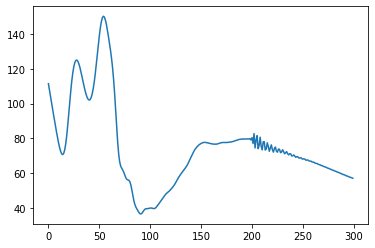

In [28]:
plt.plot(list_history[0].history['val_root_mean_squared_error'])

In [ ]:
patience = 25



In [21]:
df_errors = walk_forward_evaluation_untrainable(get_baseline, 250, 10, 30, verbose=0)

In [22]:
df_errors

,MAE(t+1),MSE(t+1),MAE(t+2),MSE(t+2),MAE(t+3),MSE(t+3),MAE(t+4),MSE(t+4),MAE(t+5),MSE(t+5),...,MAE(t+18),MSE(t+18),MAE(t+19),MSE(t+19),MAE(t+20),MSE(t+20),nb_test_datapoints,days_train,days_valid,days_test
walk,,,,,,,,,,,,,,,,,,,,,
walk 1,11.223367,419.951385,12.592270,494.268036,13.971225,576.372784,15.217859,657.960855,16.386790,742.291412,...,24.372085,1723.665982,24.585584,1768.025655,24.694536,1808.040367,690,250,10,30
walk 2,3.101914,22.359069,4.353674,39.381199,5.265475,55.684286,6.020548,69.989851,6.753053,84.382366,...,10.462370,212.903307,10.710610,218.919492,10.985765,226.035934,690,280,10,30
walk 3,2.604141,15.293640,3.829400,34.676307,5.030642,63.473999,6.127743,95.719460,7.176605,132.723659,...,12.077847,387.546949,12.246170,401.145027,12.360249,410.184217,690,310,10,30
walk 4,2.228447,10.143047,3.443768,24.835292,4.484025,44.268212,5.401248,65.417506,6.242656,91.372603,...,10.460871,268.446353,10.695198,276.449126,10.849749,284.907910,690,340,10,30
walk 5,2.975155,18.826079,4.908385,52.477583,6.726708,85.497325,7.608695,116.393062,8.104037,136.900831,...,8.731367,148.204325,9.187889,164.644877,10.091615,220.899539,92,370,10,4


In [13]:
# X% for training, remaining for test
ratio_training = 0.8
nb_datapoints = dg.batch_size
max_train = int(ratio_training * nb_datapoints)
train_idx = np.array(range(max_train))
val_idx = np.array(range(max_train, nb_datapoints))
X_train = dg.get_x(train_idx, scaled=True)
Y_train = dg.get_y(train_idx, scaled=True)
X_val = dg.get_x(val_idx, scaled=True, use_previous_scaler=True)
Y_val_unscaled = dg.get_y(val_idx, geo=dg.loc_init, scaled=False, use_previous_scaler=True)
Y_val_unpadded_unscaled = dg.remove_padded_y(Y_val_unscaled, idx=val_idx, geo=dg.loc_init)

model_generator = get_dense_model

batch_size_train = len(train_idx)
batch_size_val = len(X_val)
model = model_generator(batch_input_shape=(batch_size_train, n_samples, n_features))
model_validation = model_generator(batch_input_shape=(batch_size_val, n_samples, n_features))
val_log = ValidationLogger(model_validation, len(X_val), X_val, Y_val_unpadded_unscaled, val_idx, dg.loc_init)
callbacks = [val_log, EarlyStopping(monitor='val_root_mean_squared_error', mode='min', verbose=1, patience=1)]
    
start = time.time()
history = model.fit(X_train, Y_train, batch_size=batch_size_train, epochs=200, callbacks=callbacks)
end = time.time() - start
print(f"computed in {str(str(timedelta(seconds=end)))} s")

Epoch 1/200
66/66 [==============================] - 1s 2ms/step - loss: 0.3480 - mse: 0.3480 - mae: 0.3775 - root_mean_squared_error: 0.5843 - val_mean_squared_error: 493404.6562 - val_mean_absolute_error: 311.0318 - val_root_mean_squared_error: 702.4277
Epoch 2/200
66/66 [==============================] - 0s 1ms/step - loss: 0.0654 - mse: 0.0654 - mae: 0.1591 - root_mean_squared_error: 0.2550 - val_mean_squared_error: 63255.7500 - val_mean_absolute_error: 152.8721 - val_root_mean_squared_error: 251.5070
Epoch 3/200
66/66 [==============================] - 0s 1ms/step - loss: 0.0299 - mse: 0.0299 - mae: 0.1195 - root_mean_squared_error: 0.1729 - val_mean_squared_error: 54219.2266 - val_mean_absolute_error: 148.2310 - val_root_mean_squared_error: 232.8502
Epoch 4/200
66/66 [==============================] - 0s 1ms/step - loss: 0.0222 - mse: 0.0222 - mae: 0.1068 - root_mean_squared_error: 0.1489 - val_mean_squared_error: 37672.4297 - val_mean_absolute_error: 118.3708 - val_root_mean_squ

# Optimisation of hyperparameters

In [14]:
hyper_parameter = {
    'hidden_1': [4, 8, 16],
    'hidden_2': [0, 4, 8, 16],
    'lr': [0.001, 0.01],
    'activation': ['relu', 'elu'],
    'reg': [lambda x: regularizers.l1(l=x), lambda x: None],
    'regw': [5e-4, 1e-3],
    'optimizer': ['Adam', 'RMSprop'],
    'losses': ['mse', 'mae', custom_loss_function],
    'scaling': [MinMaxScaler, StandardScaler],
    'batch_size_div': [1],
    'epochs': [600]
}

def get_encoder_decoder(batch_input_shape, p):
    model = Sequential()
    model.add(LSTM(p['hidden_1'], return_sequences=(p['hidden_2'] != 0), 
                   batch_input_shape=batch_input_shape, kernel_regularizer=p['reg'](p['regw'])))
    if p['hidden_2'] != 0:
        model.add(LSTM(p['hidden_2'], return_sequences=False, kernel_regularizer=p['reg'](p['regw'])))
    model.add(RepeatVector(n_forecast))  # repeat
    if p['hidden_2'] != 0:
        model.add(LSTM(p['hidden_2'], return_sequences=True, kernel_regularizer=p['reg'](p['regw'])))  # dec
    if not predict_one:
        model.add(LSTM(p['hidden_1'], return_sequences=True, kernel_regularizer=p['reg'](p['regw'])))  # dec
        model.add(TimeDistributed(Dense(1, kernel_regularizer=p['reg'](p['regw']), activation=p['activation'])))
        model.add(Reshape((n_forecast,)))
    else:
        model.add(LSTM(p['hidden_1'], return_sequences=False, kernel_regularizer=p['reg'](p['regw'])))  # dec
        model.add(Dense(1, kernel_regularizer=p['reg'](p['regw']), activation=p['activation']))
        model.add(Reshape((1,)))
    model.compile(loss=p["losses"], optimizer=p["optimizer"], metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError()])
    K.set_value(model.optimizer.learning_rate, p['lr'])
    return model
    

def talos_walk(x_train, y_train, x_val, y_val, p):
    """
    walk forward evaluation used by talos to determine the best model to keep
    """
    dg.set_scaler(p['scaling'])
    model_generator = lambda batch_input_shape: get_encoder_decoder(batch_input_shape, p)

    batch_size_fun = lambda x : int(x.shape[0] / p['batch_size_div'])
    history_list = walk_forward_evaluation(model_generator, nb_fit_first=250, nb_validation=0, nb_test=30, 
                                      epochs=p['epochs'], plot=False, verbose=0, 
                                      batch_size_fun=batch_size_fun, return_history=True, es_stop_val=True)
    # compute history to return, based on the list of history
    history = History()
    # used to trick talos to compute the right amount of round_epochs. needs to be the first entry of the dict
    # create an array of len == mean of number of epoch of each history
    history.history['ep'] = np.arange(int(np.mean([len(hist.history['loss']) for hist in history_list]))) + 1
    for log in history_list[0].history.keys():
        history.history[log] = [np.mean([hist.history[log][-1] for hist in history_list])]
    return history, model_generator((1, n_samples, n_features))

scan_object = talos.Scan(
    x=[],
    y=[],
    x_val=[],
    y_val=[],
    params=hyper_parameter,
    model=talos_walk,
    experiment_name='trends1', 
    fraction_limit=0.01
)

  0%|          | 0/23 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
analyze_object = talos.Analyze(scan_object)
print("MAE", analyze_object.low('mae'))
print("MSE", analyze_object.low('mse'))
print("RMSE", analyze_object.low('root_mean_squared_error'))
print("TEST MAE", analyze_object.low('test_mae'))
print("TEST MSE", analyze_object.low('test_mse'))
print("TEST RMSE", analyze_object.low('test_root_mean_squared_error'))
df = analyze_object.table('test_root_mean_squared_error', ascending=True)
print(df.columns)
columns = [f"test_mae(t+{i})" for i in range(1, n_forecast+1)]
df[['hidden_1', 'hidden_2', 'lr', 'batch_size_div', 'scaling', 'test_mse', 'test_mae'] + columns]

# 2 estimators combined
The first estimator should be simple and output an estimate $ \hat{y}_{(1)}(t) $ of $ y(t) $
The correction factor ($ C(t) $) between the estimation and the real value is then computed:

$$ y(t) = \hat{y}_{(1)}(t) * ( 1 + C(t)) $$

$$ C(t) = \frac{y(t) - \hat{y}_{(1)}(t)}{\hat{y}_{(1)}(t)} $$

This formula is used such that $C(t)$ should be bounded in [-1, 1] if the target is a positive value and the first estimator is relatively closed to the expected value.

Anoter estimator is then trained based on the first one. The goal is to be able to predict the correction $ C(t) $ that should be done on the first estimator, in order to reduce the estimation error and get a better prediction. The prediction of $ C(t) $ is written $ \hat{C}(t) $. Once this estimator is computed, the final prediction can be constructed:

$$ \hat{y}(t) = \hat{y}_{(1)}(t) * ( 1 + \hat{C}(t)) $$



## First estimator
Construct the predition $\hat{y}_{(1)}(t)$ and compute $C(t)$ based on it

In [13]:
# X% for training, remaining for test
ratio_training = 0.8
epochs = 200

nb_datapoints = dg.batch_size
max_train = int(ratio_training * nb_datapoints)
train_idx = np.array(range(max_train))
valid_idx = np.array([])
test_idx = np.array(range(max_train, nb_datapoints))

X_train_1 = dg.get_x(train_idx, scaled=True)
Y_train = dg.get_y(train_idx, scaled=True)

if len(valid_idx) > 0:
    X_val_1 = dg.get_x(val_idx, geo=dg.loc_init, scaled=True, use_previous_scaler=True)
    Y_val_unscaled = dg.get_y(val_idx, geo=dg.loc_init, scaled=False)
    Y_val_real = dg.remove_padded_y(Y_val_unscaled, idx=val_idx, geo=dg.loc_init)

X_test_1 = dg.get_x(test_idx, scaled=True, geo=dg.loc_init, use_previous_scaler=True)
Y_test_unscaled = dg.get_y(test_idx, scaled=False, geo=dg.loc_init)
Y_test_real = dg.remove_padded_y(Y_test_unscaled, idx=test_idx, geo=dg.loc_init)
    
"""
X_train_val = dg.get_x(train_val_idx, scaled=True)
df_Y_real = {loc: dg.df[loc][dg.target_columns].iloc[train_val_idx] for loc in dg.df}
Y_real_train_val = dg.get_y(train_val_idx, scaled=True, use_previous_scaler=True)
"""

model_generator = get_dense_model

batch_size_train = len(X_train_1)
batch_size_test = len(X_test_1)

if len(valid_idx) > 0:  # use validation set for an early stop
    batch_size_val = len(X_val_1)
    model_validation = model_generator(batch_input_shape=(batch_size_val, n_samples, dg.n_features))
    val_log = ValidationLogger(model_validation, len(X_val), X_val, Y_val_real, valid_idx, dg.loc_init)
    callbacks = [val_log, EarlyStopping(monitor='val_root_mean_squared_error', mode='min', verbose=1, patience=20)]
else:
    callbacks = None

model = model_generator(batch_input_shape=(batch_size_train, n_samples, dg.n_features))
history = model.fit(X_train_1, Y_train, batch_size=batch_size_train, epochs=epochs, callbacks=callbacks)
# compute the predictions on both the training and the validation
Y_train_pred_1 = model.predict(X_train_1, batch_size=batch_size_train)

model_prediction = model_generator(batch_input_shape=(batch_size_test, n_samples, dg.n_features))
model_prediction.set_weights(model.get_weights())
Y_test_pred_1 = model_prediction.predict(X_test_1, batch_size=batch_size_test)
# unscale and unpad the data
Y_test_pred_unscaled_1 = dg.inverse_transform_y(Y_test_pred_1, idx=test_idx, geo=dg.loc_init)
Y_test_pred_real_1 = dg.remove_padded_y(Y_test_pred_unscaled_1, idx=test_idx, geo=dg.loc_init)

"""
df_predicted_1 = dg.inverse_transform_y(Y_train_val_pred, idx=train_val_idx, return_type='dict_df')
df_predicted_1

# predictions on the training set
model_prediction = model_generator(batch_input_shape=(batch_size_train, n_samples, dg.n_features))
model_prediction.set_weights(model.get_weights())
Y_train_pred = model_prediction.predict(X_train, batch_size=batch_size_train)

# predictions on the validation without augmented regions
model_prediction = model_generator(batch_input_shape=(batch_size_val, n_samples, dg.n_features))
model_prediction.set_weights(model.get_weights())
Y_val_pred = model_prediction.predict(X_val, batch_size=batch_size_val)
df_Y_real = {loc: dg.df[loc][dg.target_columns].iloc[train_val_idx] for loc in dg.df}
"""

Epoch 1/200
1/1 [==============================] - 1s 608ms/step - loss: 0.4331 - mse: 0.4331 - mae: 0.4510 - root_mean_squared_error: 0.6581
Epoch 2/200
1/1 [==============================] - 0s 3ms/step - loss: 0.3930 - mse: 0.3930 - mae: 0.4266 - root_mean_squared_error: 0.6269
Epoch 3/200
1/1 [==============================] - 0s 3ms/step - loss: 0.3669 - mse: 0.3669 - mae: 0.4106 - root_mean_squared_error: 0.6057
Epoch 4/200
1/1 [==============================] - 0s 2ms/step - loss: 0.3467 - mse: 0.3467 - mae: 0.3980 - root_mean_squared_error: 0.5888
Epoch 5/200
1/1 [==============================] - 0s 3ms/step - loss: 0.3299 - mse: 0.3299 - mae: 0.3873 - root_mean_squared_error: 0.5743
Epoch 6/200
1/1 [==============================] - 0s 2ms/step - loss: 0.3152 - mse: 0.3152 - mae: 0.3779 - root_mean_squared_error: 0.5614
Epoch 7/200
1/1 [==============================] - 0s 3ms/step - loss: 0.3022 - mse: 0.3022 - mae: 0.3694 - root_mean_squared_error: 0.5497
Epoch 8/200
1/1 [=

1/1 [==============================] - 0s 2ms/step - loss: 0.0325 - mse: 0.0325 - mae: 0.1232 - root_mean_squared_error: 0.1803
Epoch 118/200
1/1 [==============================] - 0s 3ms/step - loss: 0.0322 - mse: 0.0322 - mae: 0.1228 - root_mean_squared_error: 0.1794
Epoch 119/200
1/1 [==============================] - 0s 3ms/step - loss: 0.0319 - mse: 0.0319 - mae: 0.1221 - root_mean_squared_error: 0.1785
Epoch 120/200
1/1 [==============================] - 0s 3ms/step - loss: 0.0316 - mse: 0.0316 - mae: 0.1217 - root_mean_squared_error: 0.1777
Epoch 121/200
1/1 [==============================] - 0s 3ms/step - loss: 0.0313 - mse: 0.0313 - mae: 0.1211 - root_mean_squared_error: 0.1768
Epoch 122/200
1/1 [==============================] - 0s 3ms/step - loss: 0.0310 - mse: 0.0310 - mae: 0.1206 - root_mean_squared_error: 0.1760
Epoch 123/200
1/1 [==============================] - 0s 3ms/step - loss: 0.0307 - mse: 0.0307 - mae: 0.1201 - root_mean_squared_error: 0.1752
Epoch 124/200
1/1 [=

"\ndf_predicted_1 = dg.inverse_transform_y(Y_train_val_pred, idx=train_val_idx, return_type='dict_df')\ndf_predicted_1\n\n# predictions on the training set\nmodel_prediction = model_generator(batch_input_shape=(batch_size_train, n_samples, dg.n_features))\nmodel_prediction.set_weights(model.get_weights())\nY_train_pred = model_prediction.predict(X_train, batch_size=batch_size_train)\n\n# predictions on the validation without augmented regions\nmodel_prediction = model_generator(batch_input_shape=(batch_size_val, n_samples, dg.n_features))\nmodel_prediction.set_weights(model.get_weights())\nY_val_pred = model_prediction.predict(X_val, batch_size=batch_size_val)\ndf_Y_real = {loc: dg.df[loc][dg.target_columns].iloc[train_val_idx] for loc in dg.df}\n"

In [13]:
# compute the corrections and add them to a dataframe
data_dg_2 = [f'{topic}(t{i})' for i in range(-n_samples+1, 0, 1) for topic in list_topics] + [topic for topic in list_topics]
target_df_2 = [f'{target}(t+{i})' for i in range(1, n_forecast+1)]
df_c = {loc : dg.df[loc][data_dg_2 + target_df_2] for loc in dg.df}
"""
for k in dg.df:
    # add the data columns to the dataframe
    df_c[k] = dg.df[k][data_dg_2]
    for t in range(1, n_forecast+1):  # add the target columns
        target_t = f'{target}(t+{t})'
        df_c[k][f'C(t+{t})'] = (df_Y_real[k][target_t] - df_predicted_1[k][target_t]) / df_predicted_1[k][target_t]
"""

"\nfor k in dg.df:\n    # add the data columns to the dataframe\n    df_c[k] = dg.df[k][data_dg_2]\n    for t in range(1, n_forecast+1):  # add the target columns\n        target_t = f'{target}(t+{t})'\n        df_c[k][f'C(t+{t})'] = (df_Y_real[k][target_t] - df_predicted_1[k][target_t]) / df_predicted_1[k][target_t]\n"

In [14]:
df_c['BE']

Fièvre(t-29)  Mal de gorge(t-29)  Symptôme(t-29)  \
LOC DATE                                                           
BE  2020-03-04     25.402051           25.829284       22.034428   
    2020-03-05     25.245307           25.878495       21.941446   
    2020-03-06     24.616242           25.042280       21.586268   
    2020-03-07     24.280325           24.475947       21.198360   
    2020-03-08     24.268387           24.651690       20.792376   
...                      ...                 ...             ...   
    2021-03-17     22.274262           35.131666       22.239621   
    2021-03-18     22.250779           35.052849       22.831868   
    2021-03-19     22.082581           34.776027       23.138793   
    2021-03-20     21.799723           33.634505       23.251944   
    2021-03-21     21.560343           32.425871       23.347154   

                Fièvre(t-28)  Mal de gorge(t-28)  Symptôme(t-28)  \
LOC DATE                                                           
BE  2020-03-04     25.245307           25.878495       21.941446   
    2020-03-05     24.616242           25.042280       21.586268   
    2020-03-06     24.280325           24.475947       21.198360   
    2020-03-07     24.268387           24.651690       20.792376   
    2020-03-08     24.279004           24.994527       20.590845   
...                      ...                 ...             ...   
    2021-03-17     22.250779           35.052849       22.831868   
    2021-03-18     22.082581           34.776027       23.138793   
    2021-03-19     21.799723           33.634505       23.251944   
    2021-03-20     21.560343           32.425871       23.347154   
    2021-03-21     21.668993           31.181405       23.458170   

                Fièvre(t-27)  Mal de gorge(t-27)  Symptôme(t-27)  \
LOC DATE                                                           
BE  2020-03-04     24.616242           25.042280       21.586268   
    2020-03-05     24.280325           24.475947       21.198360   
    2020-03-06     24.268387           24.651690       20.792376   
    2020-03-07     24.279004           24.994527       20.590845   
    2020-03-08     24.030306           24.884379       20.461919   
...                      ...                 ...             ...   
    2021-03-17     22.082581           34.776027       23.138793   
    2021-03-18     21.799723           33.634505       23.251944   
    2021-03-19     21.560343           32.425871       23.347154   
    2021-03-20     21.668993           31.181405       23.458170   
    2021-03-21     21.891241           29.244671       23.651876   

                Fièvre(t-26)  ...  NEW_HOSP(t+11)  NEW_HOSP(t+12)  \
LOC DATE                      ...                                   
BE  2020-03-04     24.280325  ...       66.000000       96.428571   
    2020-03-05     24.268387  ...       96.428571      138.428571   
    2020-03-06     24.279004  ...      138.428571      184.428571   
    2020-03-07     24.030306  ...      184.428571      214.142857   
    2020-03-08     24.089472  ...      214.142857      239.857143   
...                      ...  ...             ...             ...   
    2021-03-17     21.799723  ...      254.714286      261.571429   
    2021-03-18     21.560343  ...      261.571429      274.571429   
    2021-03-19     21.668993  ...      274.571429      269.285714   
    2021-03-20     21.891241  ...      269.285714      263.285714   
    2021-03-21     21.963463  ...      263.285714      267.714286   

                NEW_HOSP(t+13)  NEW_HOSP(t+14)  NEW_HOSP(t+15)  \
LOC DATE                                                         
BE  2020-03-04      138.428571      184.428571      214.142857   
    2020-03-05      184.428571      214.142857      239.857143   
    2020-03-06      214.142857      239.857143      282.000000   
    2020-03-07      239.857143      282.000000      334.000000   
    2020-03-08      282.000000      334.000000      374.142857   
.

In [17]:
scaler_generator = MinMaxScaler
dg_2 = util.DataGenerator(df_c, n_samples, n_forecast, target=target, scaler_generator=scaler_generator, 
                          scaler_type='batch', augment_merge=0, predict_one=False, cumsum=False,
                          data_columns=[k for k in list_topics], no_lag=True)
dg_2.set_loc_init(dg.loc_init)  # consider the other localisations as being augmented

## Train the second estimator to compute $Y_2(t)$

In [17]:
X_train_2 = dg_2.get_x(train_idx, scaled=True)
Y_train_2 = dg_2.get_y(train_idx, scaled=True)

if len(valid_idx) > 0:
    X_val_2 = dg_2.get_x(valid_idx, scaled=True, use_previous_scaler=True, geo=dg_2.loc_init)
    Y_val_unscaled_2 = dg.get_y(valid_idx, geo=dg.loc_init, scaled=False)
    Y_val_real_2 = dg.remove_padded_y(Y_val_unscaled, idx=val_idx, geo=dg.loc_init)
    batch_size_val = len(X_val_2)
    
X_test_2 = dg_2.get_x(test_idx, scaled=True, use_previous_scaler=True, geo=dg_2.loc_init)
Y_test_unscaled_2 = dg.get_y(test_idx, scaled=False, geo=dg_2.loc_init)
Y_test_real_2 = dg.remove_padded_y(Y_test_unscaled_2, idx=test_idx, geo=dg_2.loc_init)

model_generator = get_dense_model

batch_size_train = len(X_train_2)
batch_size_test = len(X_test_2)
model = model_generator(batch_input_shape=(batch_size_train, n_samples, dg_2.n_features))
    
history = model.fit(X_train_2, Y_train_2, batch_size=batch_size_train, epochs=epochs, callbacks=None)
# compute the predictions on both the training and the validation
Y_train_pred_2 = model.predict(X_train_2, batch_size=batch_size_train)

model_prediction = model_generator(batch_input_shape=(batch_size_test, n_samples, dg_2.n_features))
model_prediction.set_weights(model.get_weights())
Y_test_pred_2 = model_prediction.predict(X_test_2, batch_size=batch_size_test)
# unscale and unpad the data
Y_test_pred_unscaled_2 = dg_2.inverse_transform_y(Y_test_pred_2, idx=test_idx, geo=dg_2.loc_init)
Y_test_pred_real_2 = dg.remove_padded_y(Y_test_pred_unscaled_2, idx=test_idx, geo=dg_2.loc_init)

Epoch 1/200
1/1 [==============================] - 0s 127ms/step - loss: 0.5092 - mse: 0.5092 - mae: 0.5694 - root_mean_squared_error: 0.7136
Epoch 2/200
1/1 [==============================] - 0s 3ms/step - loss: 0.4733 - mse: 0.4733 - mae: 0.5465 - root_mean_squared_error: 0.6879
Epoch 3/200
1/1 [==============================] - 0s 3ms/step - loss: 0.4491 - mse: 0.4491 - mae: 0.5306 - root_mean_squared_error: 0.6702
Epoch 4/200
1/1 [==============================] - 0s 4ms/step - loss: 0.4300 - mse: 0.4300 - mae: 0.5177 - root_mean_squared_error: 0.6557
Epoch 5/200
1/1 [==============================] - 0s 4ms/step - loss: 0.4137 - mse: 0.4137 - mae: 0.5065 - root_mean_squared_error: 0.6432
Epoch 6/200
1/1 [==============================] - 0s 3ms/step - loss: 0.3994 - mse: 0.3994 - mae: 0.4965 - root_mean_squared_error: 0.6320
Epoch 7/200
1/1 [==============================] - 0s 4ms/step - loss: 0.3865 - mse: 0.3865 - mae: 0.4874 - root_mean_squared_error: 0.6217
Epoch 8/200
1/1 [=

1/1 [==============================] - 0s 3ms/step - loss: 0.0906 - mse: 0.0906 - mae: 0.2469 - root_mean_squared_error: 0.3010
Epoch 118/200
1/1 [==============================] - 0s 3ms/step - loss: 0.0904 - mse: 0.0904 - mae: 0.2467 - root_mean_squared_error: 0.3006
Epoch 119/200
1/1 [==============================] - 0s 3ms/step - loss: 0.0901 - mse: 0.0901 - mae: 0.2463 - root_mean_squared_error: 0.3002
Epoch 120/200
1/1 [==============================] - 0s 3ms/step - loss: 0.0899 - mse: 0.0899 - mae: 0.2461 - root_mean_squared_error: 0.2998
Epoch 121/200
1/1 [==============================] - 0s 3ms/step - loss: 0.0897 - mse: 0.0897 - mae: 0.2458 - root_mean_squared_error: 0.2994
Epoch 122/200
1/1 [==============================] - 0s 3ms/step - loss: 0.0894 - mse: 0.0894 - mae: 0.2456 - root_mean_squared_error: 0.2991
Epoch 123/200
1/1 [==============================] - 0s 3ms/step - loss: 0.0892 - mse: 0.0892 - mae: 0.2453 - root_mean_squared_error: 0.2987
Epoch 124/200
1/1 [=

## Construct the final prediction by combining the two

In [20]:
class AssembleLayerTimeDist(tf.keras.Model):
    """
    assemble the prediction from the trends and the predictions from another model
    the same weight is used at every timestep (1 trainable parameter)
    """
    def __init__(self, input_shape):
        super(AssembleLayer, self).__init__(name='')
        self.dense_trends = tf.keras.layers.Dense(1, use_bias=False, 
                                                 kernel_constraint=tf.keras.constraints.MinMaxNorm(0.001, 0.2))
        batch_input_shape = (input_shape[0], input_shape[1], 1)
        self.time_dist = TimeDistributed(self.dense_trends, batch_input_shape=batch_input_shape)

    def call(self, input_tensor, training=False):
        x_trends = input_tensor[:, :, 1:]
        x_hosp = input_tensor[:, :, :1]
        x_trends = tf.keras.layers.Subtract()([x_trends, x_hosp])  # x_trends - x_hosp
        x_trends = self.time_dist(x_trends, training=training)  # apply simple weight
        return tf.keras.layers.Add()([x_trends, x_hosp])  # final prediction = x_hosp + (x_trends - x_hosp) * c

class AssembleLayer(tf.keras.Model):
    """
    assemble the prediction from the trends and the predictions from another model
    different weight are used at every timestep (n_forecast trainable parameter)
    """
    
    def __init__(self, batch_input_shape):
        super(AssembleLayer, self).__init__(name='')
        self.kernel = self.add_weight("kernel", shape=[1,batch_input_shape[1]], 
                                      constraint=tf.keras.constraints.MinMaxNorm(0.001, 0.2))

    """
    def build(self, input_shape):
        self.kernel = self.add_weight("kernel",
                              shape=[1,input_shape[1]], constraint=tf.keras.constraints.MinMaxNorm(0.001, 0.2))
    """

    def call(self, input_tensor, training=False):
        x_trends = input_tensor[:, :, 1]
        x_hosp = input_tensor[:, :, 0]
        x_trends = tf.keras.layers.Subtract()([x_trends, x_hosp])  # x_trends - x_hosp
        x_trends = tf.multiply(x_trends, self.kernel)  # apply simple weight: (x_trends - x_hosp) * c
        # x_trends = tf.reshape(x_trends, x_hosp.shape)
        return tf.keras.layers.Add()([x_hosp, x_trends])  # final prediction = x_hosp + (x_trends - x_hosp) * c

    
def get_assemble(batch_input_shape):
    model = AssembleLayer(batch_input_shape)
    model.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError()])
    return model

In [19]:
X_train_assembled = np.stack([Y_train_pred_1, Y_train_pred_2], axis=2)
Y_train_assembled = Y_train  # output the target of the first model
X_test_assembled = np.stack([Y_test_pred_1, Y_test_pred_2], axis=2)
Y_test_assembled_real = Y_test_real

batch_size_train = len(X_train_assembled)
batch_size_test = len(X_test_assembled)

model_generator = get_assemble

model_train = model_generator(batch_input_shape=(batch_size_train, n_forecast, 2))
model_train.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError()])
history = model_train.fit(X_train_assembled, Y_train_assembled, batch_size=batch_size_train, epochs=epochs)
Y_train_assembled_pred = model_train.predict(X_train_assembled, batch_size=batch_size_train)

model_prediction = model_generator(batch_input_shape=(batch_size_test, n_forecast, 2))
model_prediction.set_weights(model_train.get_weights())
Y_test_assembled_pred = model_prediction.predict(X_test_assembled, batch_size=batch_size_test)
# unscale and unpad the data
Y_test_assembled_pred_unscaled = dg_2.inverse_transform_y(Y_test_assembled_pred, idx=test_idx, geo=dg.loc_init)
Y_test_assembled_pred_real = dg.remove_padded_y(Y_test_assembled_pred_unscaled, idx=test_idx, geo=dg.loc_init)

Epoch 1/200
1/1 [==============================] - 0s 165ms/step - loss: 0.0253 - mse: 0.0253 - mae: 0.1184 - root_mean_squared_error: 0.1590
Epoch 2/200
1/1 [==============================] - 0s 2ms/step - loss: 0.0214 - mse: 0.0214 - mae: 0.1060 - root_mean_squared_error: 0.1464
Epoch 3/200
1/1 [==============================] - 0s 2ms/step - loss: 0.0214 - mse: 0.0214 - mae: 0.1059 - root_mean_squared_error: 0.1463
Epoch 4/200
1/1 [==============================] - 0s 2ms/step - loss: 0.0214 - mse: 0.0214 - mae: 0.1058 - root_mean_squared_error: 0.1462
Epoch 5/200
1/1 [==============================] - 0s 3ms/step - loss: 0.0213 - mse: 0.0213 - mae: 0.1057 - root_mean_squared_error: 0.1461
Epoch 6/200
1/1 [==============================] - 0s 2ms/step - loss: 0.0213 - mse: 0.0213 - mae: 0.1056 - root_mean_squared_error: 0.1460
Epoch 7/200
1/1 [==============================] - 0s 3ms/step - loss: 0.0213 - mse: 0.0213 - mae: 0.1055 - root_mean_squared_error: 0.1459
Epoch 8/200
1/1 [=

1/1 [==============================] - 0s 2ms/step - loss: 0.0199 - mse: 0.0199 - mae: 0.1005 - root_mean_squared_error: 0.1410
Epoch 118/200
1/1 [==============================] - 0s 3ms/step - loss: 0.0199 - mse: 0.0199 - mae: 0.1005 - root_mean_squared_error: 0.1410
Epoch 119/200
1/1 [==============================] - 0s 3ms/step - loss: 0.0199 - mse: 0.0199 - mae: 0.1005 - root_mean_squared_error: 0.1410
Epoch 120/200
1/1 [==============================] - 0s 2ms/step - loss: 0.0199 - mse: 0.0199 - mae: 0.1004 - root_mean_squared_error: 0.1410
Epoch 121/200
1/1 [==============================] - 0s 2ms/step - loss: 0.0199 - mse: 0.0199 - mae: 0.1004 - root_mean_squared_error: 0.1409
Epoch 122/200
1/1 [==============================] - 0s 2ms/step - loss: 0.0199 - mse: 0.0199 - mae: 0.1004 - root_mean_squared_error: 0.1409
Epoch 123/200
1/1 [==============================] - 0s 2ms/step - loss: 0.0198 - mse: 0.0198 - mae: 0.1004 - root_mean_squared_error: 0.1409
Epoch 124/200
1/1 [=

In [20]:
factors = model_prediction.weights[0].numpy().reshape(n_forecast)
for t in range(n_forecast):
    print(f'factor t+{t+1} = {factors[t]:.4f}')

factor t+1 = -0.0369
factor t+2 = 0.0094
factor t+3 = -0.0201
factor t+4 = -0.0503
factor t+5 = -0.0222
factor t+6 = 0.0086
factor t+7 = 0.0610
factor t+8 = -0.0460
factor t+9 = 0.0251
factor t+10 = 0.0206
factor t+11 = -0.0086
factor t+12 = 0.0465
factor t+13 = 0.0380
factor t+14 = -0.0035
factor t+15 = -0.0059
factor t+16 = 0.0511
factor t+17 = 0.0799
factor t+18 = -0.0015
factor t+19 = 0.1458
factor t+20 = 0.0549


In [21]:
error_1 = compute_error(Y_test_pred_real_1, Y_test_real)
error_1['model'] = 'model 1'
error_2 = compute_error(Y_test_pred_real_2, Y_test_real_2)
error_2['model'] = 'model trends'
error_assembled = compute_error(Y_test_assembled_pred_real, Y_test_assembled_real)
error_assembled['model'] = 'assembled'
pd.concat([error_1, error_2, error_assembled]).set_index('model')

,MAE(t+1),MSE(t+1),MAE(t+2),MSE(t+2),MAE(t+3),MSE(t+3),MAE(t+4),MSE(t+4),MAE(t+5),MSE(t+5),...,MAE(t+16),MSE(t+16),MAE(t+17),MSE(t+17),MAE(t+18),MSE(t+18),MAE(t+19),MSE(t+19),MAE(t+20),MSE(t+20)
model,,,,,,,,,,,,,,,,,,,,,
model 1,64.776166,8177.744198,85.544188,14000.047469,56.282541,6775.733298,92.281441,16304.983330,73.014681,12421.447863,...,171.245261,68173.437018,189.017537,79470.457678,216.303038,105515.005546,175.501428,73015.696985,199.017932,91250.922392
model trends,500.168623,448179.411747,490.743285,423056.173580,488.237584,428791.133248,481.568161,427597.078281,463.950663,402762.104273,...,462.392660,442370.553714,462.200601,440222.909615,478.446685,497911.997312,467.308769,461839.989367,468.023170,465973.809583
assembled,53.343115,5873.652453,88.448106,14906.556168,51.802158,5967.674274,78.317268,11706.270929,68.515821,11198.143498,...,181.193902,76003.897253,203.806071,91230.733219,216.146575,105285.687699,203.392486,94678.490116,208.180587,99320.488036


In [18]:
def walk_forward_assembly(model_generator_1: callable, dg_1: util.DataGenerator,
                          model_generator_2: callable, dg_2: util.DataGenerator,
                          model_generator_as: callable, 
                          nb_fit_first: int, nb_valid: int, nb_test: int, verbose: int = 1,
                          return_history: bool = False, batch_size_fun: callable = None,
                          es_stop_val: bool = False, epochs: int = 200) -> Union[pd.DataFrame, List[History]]:
    """
    evaluates a model using a walk forward evaluation: multiples fit are done, each followed by at most nb_test
    to evaluate the model
    :param model_generator_1: function returning the first model to evaluate
    :param target_1: target for the first model
    :param data_columns_1: data columns for the first model
    :param model_generator_2: function returning the second model to evaluate
    :param target_2: target for the second model
    :param data_columns_2: data columns for the second model
    :param model_generator_as: function returning the assembly model
    :param nb_fit_first: number of datapoints used for the first fit
    :param nb_valid: number of datapoints used for each validation set
    :param nb_test: number of datapoints used for the test set (at most)
    :param epochs: number of epochs used on each fit
    :param verbose: verbose level. Passed to fit and used to display the error dataframe
    :param return_history: if True, returns the list of history of each walk
    :param batch_size_fun: function used to compute the batch size based on the X_train tensor
        if not specified, default to batch_size = len(train_idx)
    """
    # initial index used
    max_len = dg.batch_size
    train_idx = np.arange(nb_fit_first)
    valid_idx = np.arange(nb_fit_first, nb_fit_first + nb_valid)
    if nb_fit_first + nb_valid >= max_len:
        finished = True  # no test can be done
    else:
        finished = False  # a test set can be created
        test_idx = np.arange(nb_fit_first + nb_valid, min(nb_fit_first + nb_valid + nb_test, max_len))
    df_error = pd.DataFrame()
    walk = 0
    last_iter = False  # True when the last iteration is reached
    all_history = []
    
    list_dg = [dg_1, dg_2]
    
    while not finished:
        X_train, Y_train, pred_train = [], [], []
        X_val, Y_val_unscaled, Y_val_real = [], [], []
        X_test, Y_test_unscaled, Y_test_real = [], [], []
        pred_test, pred_test_unscaled, pred_test_real = [], [], []
        
        # train the two first models
        for i, model_generator in enumerate([model_generator_1, model_generator_2]):
            dg_i = list_dg[i]
            X_train.append(dg_i.get_x(train_idx, scaled=True))
            Y_train.append(dg_i.get_y(train_idx, scaled=True))

            if len(valid_idx) > 0:  # validation set: validation logger and early stop if needed
                X_val.append(dg_i.get_x(valid_idx, geo=dg_i.loc_init, scaled=True, use_previous_scaler=True))
                Y_val_unscaled.append(dg_i.get_y(valid_idx, geo=dg_i.loc_init, scaled=False))
                Y_val_real.append(dg_i.remove_padded_y(Y_val_unscaled[-1], idx=valid_idx, geo=dg_i.loc_init))
                batch_size_val = len(X_val[-1])
                model_validation = model_generator(batch_input_shape=(batch_size_val, n_samples, dg_i.n_features))
                val_log = ValidationLogger(model_validation, batch_size_val, X_val[-1], Y_val_real[-1], 
                                             valid_idx, dg_i.loc_init)
                if es_stop_val:
                    callbacks = [val_log, EarlyStopping(monitor="val_root_mean_squared_error", patience=25)]
                else:
                    callbacks = [val_log]
            else:
                callbacks = None            

            # test set
            X_test.append(dg_i.get_x(test_idx, scaled=True, geo=dg_i.loc_init, use_previous_scaler=True))
            Y_test_unscaled.append(dg_i.get_y(test_idx, scaled=False, geo=dg_i.loc_init))
            Y_test_real.append(dg_i.remove_padded_y(Y_test_unscaled[-1], idx=test_idx, geo=dg_i.loc_init))

            batch_size_train = len(X_train[-1])
            batch_size_test = len(X_test[-1])

            # training of model 1
            model_train = model_generator(batch_input_shape=(batch_size_train, dg_i.n_samples, dg_i.n_features))
            history = model_train.fit(X_train[-1], Y_train[-1], batch_size=batch_size_train, epochs=epochs, 
                                      callbacks=callbacks, verbose=verbose)
            # prediction on the training set
            pred_train.append(model_train.predict(X_train[-1], batch_size=batch_size_train))
            # prediction on the test set
            model_prediction = model_generator(batch_input_shape=(batch_size_test, n_samples, dg_i.n_features))
            model_prediction.set_weights(model_train.get_weights())
            pred_test.append(model_prediction.predict(X_test[-1], batch_size=batch_size_test))
            pred_test_unscaled.append(dg_i.inverse_transform_y(pred_test[-1], idx=test_idx, geo=dg_i.loc_init))
            pred_test_real.append(dg_i.remove_padded_y(pred_test_unscaled[-1], idx=test_idx, geo=dg_i.loc_init))
        
        # train the assembly model
        X_train_as = np.stack(pred_train, axis=2)
        Y_train_as = Y_train[0]  # output the target of the first model
        X_test_as = np.stack(pred_test, axis=2)
        Y_test_as_real = Y_test_real[0]

        batch_size_train = len(X_train_as)
        batch_size_test = len(X_test_as)
        dg_as = list_dg[0]  # used for inverse scaling and unpadding

        model_train = model_generator_as(batch_input_shape=(batch_size_train, n_forecast, 2))
        model_train.compile(loss=tf.losses.MeanSquaredError(),
                              metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError()])
        history = model_train.fit(X_train_as, Y_train_as, batch_size=batch_size_train, epochs=epochs, 
                                  verbose=verbose)
        pred_train_as = model_train.predict(X_train_as, batch_size=batch_size_train)

        model_prediction = model_generator_as(batch_input_shape=(batch_size_test, n_forecast, 2))
        model_prediction.set_weights(model_train.get_weights())
        pred_test_as = model_prediction.predict(X_test_as, batch_size=batch_size_test)
        # unscale and unpad the data
        pred_test_as_unscaled = dg_as.inverse_transform_y(pred_test_as, idx=test_idx, geo=dg_as.loc_init)
        pred_test_as_real = dg_as.remove_padded_y(pred_test_as_unscaled, idx=test_idx, geo=dg_as.loc_init)
        
        """
        if return_history:
            # add test metrics to the history for this walk, based on the unpadded unscaled data 
            # except for the loss
            for metric in model_train.metrics:
                metric.reset_states()
                if metric.name == 'loss':
                    metric.update_state(Y_predicted_real, Y_test_real)
                else:
                    # compute metric accross each horizon
                    for i in range(n_forecast):
                        metric.update_state(Y_predicted_real[:, i], Y_test_real[:, i])
                        history.history[f"test_{metric.name}(t+{i+1})"] = [metric.result().numpy()]
                        metric.reset_states()
                    # compute mean of metric on all horizon
                    metric.update_state(Y_predicted_real, Y_test_real)
                # prepend name for test set
                history.history[f"test_{metric.name}"] = [metric.result().numpy()]
            # add number of unpadded datapoints
            history.history['nb_test_datapoints'] = [len(Y_test_real)]
            all_history.append(history)
        """
        if not return_history or verbose != 0:
            # compute the error using the unpadded and unscaled data
            for i in range(3):
                if i == 2:  # assembled model
                    error = compute_error(Y_test_as_real, pred_test_as_real)
                    name = f'walk {walk + 1} model assembled'
                    error['nb_test_datapoints'] = len(Y_test_as_real)
                else:  # two first model
                    error = compute_error(Y_test_real[i], pred_test_real[i])
                    name = f'walk {walk + 1} model {i+1}'
                    error['nb_test_datapoints'] = len(Y_test_real[i])
                error['name'] = name
                error['days_train'] = len(train_idx)
                error['days_valid'] = len(valid_idx)
                error['days_test'] = len(test_idx)
                error = error.set_index('name')
                df_error = df_error.append(error)
        
        if verbose != 0:
            display(df_error)
        if last_iter:
            finished = True
        # indexes for next fit
        train_idx = np.arange(train_idx[-1] + 1 + nb_test)
        valid_idx += nb_test
        if test_idx[-1] + nb_test >= max_len:  # last iteration, less points can be used for the test set
            last_iter = True  # last iteration to be done
            test_idx = np.arange(test_idx[-1], max_len)
        else:
            test_idx += nb_test
        walk += 1
    if not return_history:  # compute the mean across all walks
        len_df = len(df_error)
        df_error.loc['mean model 1'] = df_error.iloc[range(0, len_df, 3)].mean()
        df_error.loc['mean model 2'] = df_error.iloc[range(1, len_df, 3)].mean()
        df_error.loc['mean model as'] = df_error.iloc[range(2, len_df, 3)].mean()
    return df_error if not return_history else all_history

In [39]:
df_error = walk_forward_assembly(get_dense_model, dg, get_encoder_decoder, dg_2, get_assemble,
                     220, 30, 30, epochs=200, verbose=0)

In [40]:
df_error

,MAE(t+1),MSE(t+1),MAE(t+2),MSE(t+2),MAE(t+3),MSE(t+3),MAE(t+4),MSE(t+4),MAE(t+5),MSE(t+5),...,MAE(t+18),MSE(t+18),MAE(t+19),MSE(t+19),MAE(t+20),MSE(t+20),nb_test_datapoints,days_train,days_valid,days_test
name,,,,,,,,,,,,,,,,,,,,,
walk 1 model 1,84.359519,17172.500323,89.813538,2.042219e+04,112.391106,3.493799e+04,133.709972,5.574936e+04,162.788078,8.056094e+04,...,274.352663,2.349093e+05,266.400583,2.063037e+05,265.222337,1.836229e+05,690.0,250.0,0.0,30.0
walk 1 model 2,450.600920,364699.165079,421.811967,3.146787e+05,432.646109,3.303739e+05,437.511392,3.377634e+05,427.426859,3.221477e+05,...,402.364421,4.988358e+05,405.601952,5.181328e+05,408.784488,5.365369e+05,690.0,250.0,0.0,30.0
walk 1 model assembled,80.229933,15405.056767,94.533843,2.279574e+04,105.774797,3.109170e+04,136.053394,5.784007e+04,163.746402,8.160400e+04,...,245.472736,1.945924e+05,266.583363,2.066119e+05,235.938544,1.426686e+05,690.0,250.0,0.0,30.0
walk 2 model 1,24.286091,1180.521232,157.300306,4.594330e+04,135.788077,3.504677e+04,117.818483,2.704263e+04,208.914730,8.280504e+04,...,268.098850,1.077698e+05,222.236844,7.223126e+04,303.666583,1.367235e+05,690.0,280.0,0.0,30.0
walk 2 model 2,738.806763,973716.137758,765.629937,1.080124e+06,813.159996,1.245339e+06,842.099406,1.348647e+06,852.332266,1.382890e+06,...,826.388212,1.252091e+06,829.324643,1.258092e+06,832.707795,1.265583e+06,690.0,280.0,0.0,30.0
walk 2 model assembled,23.795614,1112.771730,150.065805,4.303688e+04,144.220197,3.821023e+04,101.586242,2.249797e+04,201.672379,7.903109e+04,...,284.723816,1.193197e+05,333.880978,1.605228e+05,393.198593,2.321580e+05,690.0,280.0,0.0,30.0
walk 3 model 1,39.497256,3147.437893,49.557288,4.749236e+03,45.528840,4.309270e+03,61.411482,7.343018e+03,80.037802,1.160291e+04,...,173.858495,5.855631e+04,194.819921,7.737171e+04,164.127304,5.723943e+04,690.0,310.0,0.0,30.0
walk 3 model 2,522.503503,371687.023222,432.838671,2.343321e+05,470.792789,2.835692e+05,516.808059,3.666708e+05,549.726193,4.306439e+05,...,483.482697,3.367390e+05,481.181985,3.356021e+05,478.756484,3.342417e+05,690.0,310.0,0.0,30.0
walk 3 model assembled,43.757012,3658.677410,46.480373,4.290812e+03,46.670262,4.463448e+03,50.326971,5.685681e+03,65.208359,8.302015e+03,...,171.004556,5.745480e+04,194.424415,7.722490e+04,183.711934,6.556798e+04,690.0,310.0,0.0,30.0


# Benchmark for all models
Run experiments for all models and save results to csv and source code of model to txt file

In [24]:
import logging
logging.getLogger('tensorflow').disabled = True  # remove warnings from tensorflow

result_dir = "../res/"

model_list_trainable = [
    get_dense_model,
    get_encoder_decoder
]

model_list_untrainable = [
    get_baseline,
    get_custom_linear_regression,
]

model_list_assemble = [
    (get_dense_model, dg, get_encoder_decoder, dg_2, get_assemble)
]

nb_fit = 250
nb_eval = 10
nb_test = 30
epochs = 300
es_stop_val = True

today_date = str(date.today())

def benchmark(model_generator, walk):
    model_name = model_generator.__name__
    print(model_name)
    df_errors = walk(model_generator, nb_fit, nb_eval, nb_test, 
                                        epochs=epochs, verbose=0, es_stop_val=es_stop_val)
    # register csv for error
    filename = f'{result_dir}{today_date}_{model_name}_{target}'
    file_csv = f'{filename}.csv'
    file_txt = f'{filename}.txt'
    
    i = 0
    while os.path.isfile(file_csv) or os.path.isfile(file_txt):
        i += 1
        file_csv = f'{filename}_{i}.csv'
        file_txt = f'{filename}_{i}.txt'
    df_errors.to_csv(file_csv)
    print(f'results saved to {file_csv}')
    
    # register source code of the model and additional infos
    info_txt = inspect.getsource(model_generator) + f'\n\nepochs = {epochs}, es_stop_val = {es_stop_val}' + \
        '\n\n' + str(dg)
    with open(file_txt, 'w') as file:
        file.write(info_txt)
    print(f'results saved to {file_txt}')

for model_generator in model_list_trainable:
    benchmark(model_generator, walk_forward_evaluation)
    
for model_generator in model_list_untrainable:
    benchmark(model_generator, walk_forward_evaluation_untrainable)

# assembly benchmark
for gen_1, dg_model_1, gen_2, dg_model_2, gen_as in model_list_assemble:
    model_name = gen_as.__name__
    print(model_name)
    df_errors = walk_forward_assembly(gen_1, dg_model_1, gen_2, dg_model_2, gen_as,
                     nb_fit, nb_eval, nb_test, epochs=epochs, verbose=0)
    # register csv for error
    filename = f'{result_dir}{today_date}_{model_name}'
    file_csv = f'{filename}.csv'
    file_txt = f'{filename}.txt'
    
    i = 0
    while os.path.isfile(file_csv) or os.path.isfile(file_txt):
        i += 1
        file_csv = f'{filename}_{i}.csv'
        file_txt = f'{filename}_{i}.txt'
    df_errors.to_csv(file_csv)
    print(f'results saved to {file_csv}')
    
    # register source code of the models and additional infos
    info_txt = 'model 1:\n\n' + inspect.getsource(gen_1) + \
        '\n\nmodel 2:\n\n' + inspect.getsource(gen_2) + \
        '\n\nmodel as:\n\n' + inspect.getsource(gen_as) + \
        f'\n\nepochs = {epochs}, es_stop_val = {es_stop_val}' + \
        '\n\ndg_1:\n' + str(dg_model_1) + \
        '\n\ndg_2:\n' + str(dg_model_2)
    with open(file_txt, 'w') as file:
        file.write(info_txt)
    print(f'results saved to {file_txt}')

get_dense_model
results saved to ../res/2021-04-19_get_dense_model.csv
results saved to ../res/2021-04-19_get_dense_model.txt
get_encoder_decoder
results saved to ../res/2021-04-19_get_encoder_decoder.csv
results saved to ../res/2021-04-19_get_encoder_decoder.txt
get_baseline
results saved to ../res/2021-04-19_get_baseline.csv
results saved to ../res/2021-04-19_get_baseline.txt
get_custom_linear_regression
results saved to ../res/2021-04-19_get_custom_linear_regression.csv
results saved to ../res/2021-04-19_get_custom_linear_regression.txt
get_assemble
results saved to ../res/2021-04-19_get_assemble.csv
results saved to ../res/2021-04-19_get_assemble.txt
